## 0.1. Importación de paquetes

In [1]:
# necessary imports 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
import plotly.express as px
import statsmodels.api as sm
import statsmodels.formula.api as smf
import shap
import js2py
import xgboost as xgb
import graphviz
import sklearn
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset 
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from statsmodels.formula.api import glm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from scipy import stats
from scipy.stats import poisson, gamma, expon, kstest, kendalltau
from shap import Explainer, Explanation
from datetime import datetime

# import warnings
# warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

plt.style.use('ggplot')

In [2]:
# Recupearación de variables de ejecuciones anteriores

%store -r pg17trainpol
%store -r pg17trainclaim
%store -r y
%store -r X
%store -r X_train
%store -r X_test
%store -r y_train
%store -r y_test
%store -r DensidadPoblacion
%store -r pg17trainpoldens
%store -r vh_make_group_dic
%store -r pg17trainclaim_group
%store -r pg17trainpolclaims
%store -r pg17trainpolclaims_pre
%store -r pg17trainpolclaims_pre2
%store -r pg17trainpolclaims_dum
%store -r dist_y_train
%store -r dist_y_test
%store -r dist_y
%store -r modelo_glm_Poisson
%store -r resultado_modelo_glm_Poisson
%store -r y_pred_glm_Poisson_train
%store -r y_pred_glm_Poisson_test
%store -r modelo_glm_Gamma
%store -r resultado_modelo_glm_Gamma
%store -r y_pred_glm_Gamma_train
%store -r y_pred_glm_Gamma_test
%store -r glm_Poisson_shap_values
# %store -r glm_Poisson_explainer

%store -r t_Kendall_local_shap
%store -r t_Kendall_local_global
%store -r mse_local_shap
%store -r mse_local_global
%store -r sign_local_shap
%store -r sign_local_global
%store -r compare_GLM_Poisson_results
%store -r compare_GLM_Poisson_indexes

%store -r tree_model_Gini_atrib
%store -r atrib_CART_local
%store -r CART_shap_values
%store -r CART_tree_shap_values
%store -r compare_count_CART_results

## 0.2. Importación de ficheros

In [11]:
pg17trainpol = pd.read_csv('dataset/claims/pg17trainpol.csv')
pg17trainclaim = pd.read_csv('dataset/claims/pg17trainclaim.csv')
# pg17testyear1 = pd.read_csv('dataset/claims/pg17testyear1.csv')
# pg17testyear2 = pd.read_csv('dataset/claims/pg17testyear2.csv')
# pg17testyear3 = pd.read_csv('dataset/claims/pg17testyear3.csv')
# pg17testyear4 = pd.read_csv('dataset/claims/pg17testyear4.csv')
DensidadPoblacion = pd.read_csv('dataset/claims/DensidadPoblacion.csv')

## 0.3. Definición de funciones

In [3]:
# Función para obtener la atribución local de una GLM con función de enlace logarítmica

def atrib_local_LR(model, X, X_mean):
    
    # Obtención de los coeficientes
    coef_LR = model.params
    
    # Cálculo de atribución local
    atrib = coef_LR*(X-X_mean)
    return atrib

# Función para obtener la atribución global de una GLM con función de enlace logarítmica

def atrib_global_LR(model, X_mean):
    
    # Obtención de los coeficientes
    coef_LR = model.params
    atrib = coef_LR*X_mean
    return atrib

# Función para obtener la atribución local de una GLM con función de enlace logarítmica

def atrib_local_GLM(model, X, X_mean):
    
    # Obtención de los coeficientes
    coef_GLM_Poisson = model.params
    
    # Cálculo de atribución local
    rr = np.exp(coef_GLM_Poisson*(X-X_mean))
    atrib = np.sign(rr-1)*((rr-1)**2)
    return atrib

# Función para obtener la atribución global de una GLM con función de enlace logarítmica

def atrib_global_GLM(model):
    
    # Obtención de los coeficientes
    coef_GLM_Poisson = model.params
    
    # Cálculo de atribución local
    rr = np.exp(coef_GLM_Poisson)
    atrib = np.sign(rr-1)*((rr-1)**2)
    return atrib
    
# Función para obtener el orden de mayor a menor de un vector ordenando por su valor abosoluto

def get_order_list(atrib):
    
    # Cálculo del orden por valor absoluto
    atrib_neg = -abs(atrib)
    orden_arg = np.argsort(atrib_neg)
    orden = atrib_neg.copy()
    orden[orden_arg] = np.arange(len(atrib)) + 1
    orden.sort_index()
    return orden

# Use SHAP values to show the effect of each feature of a given patient

def Kernel_SHAP_shap_values(model, train_data, n_sample):
    # Create object that can calculate shap values
    if n_sample == 0:
        explainer = shap.KernelExplainer(model, train_data)
    else:
        explainer = shap.KernelExplainer(model, train_data[0:n_sample])
    return explainer

# Use SHAP values to show the effect of each feature of a given patient

def shap_force_plot(expected_value, shap_values, explain_data):
    shap.initjs()
    return shap.force_plot(expected_value, shap_values, explain_data, matplotlib=True)

# Función para obtener predicciones del modelo de regresión lineal para E[N]

def modelo_LR_count_wrapper(X):
    return modelo_LR_count.predict(X)

# Función para obtener predicciones del modelo GLM de Poisson

def resultado_modelo_glm_Poisson_wrapper(X):
    return resultado_modelo_glm_Poisson.predict(X)

def shap_waterfall_plot(shap_explainer, X_test, interp_index, n_sample, feature_names, n_features_plot):
    if n_sample == 0:
        sample_shap = X_test
    else:
        sample_shap = X_test[0:n_sample-1]
    sv_glm = shap_explainer(sample_shap)
    expl = shap.Explanation(sv_glm, sv_glm.base_values, sample_shap, feature_names=feature_names)
    return shap.waterfall_plot(expl[interp_index], n_features_plot)

def custom_format(x):
    if x == int(x):
        return '{:d}'.format(int(x))
    else:
        return '{:.6f}'.format(x)
    
def atrib_local_CART(model, X_pred):
    expected_value = model.tree_.value[0]
    prediction_path = model.decision_path(np.array(X_pred).reshape(1, -1))
    nodos_visitados = prediction_path.indices[prediction_path.indptr[0]:prediction_path.indptr[1]]
    nodos_atrib = X_pred.copy()
    nodos_atrib[0:len(X_pred)] = np.full(len(X_pred),0)

    nodos_visitados_prev = nodos_visitados[0:len(nodos_visitados)-1]
    nodos_visitados_post = nodos_visitados[1:len(nodos_visitados)]

    # Acceder a la información de los nodos

    for nodo_prev, nodo_post in zip(nodos_visitados_prev, nodos_visitados_post):
        # help(sklearn.tree._tree.Tree)
        feature = X_pred.index[model.tree_.feature[nodo_prev]]
        atrib = model.tree_.value[nodo_post] - model.tree_.value[nodo_prev]
        nodos_atrib[feature] = nodos_atrib[feature] + atrib[0][0]

    return nodos_atrib

# Use SHAP values to show the effect of each feature of a given patient

def Tree_SHAP_shap_values(model, train_data, n_sample):
    # Create object that can calculate shap values
    if n_sample == 0:
        explainer = shap.TreeExplainer(model, train_data)
    else:
        explainer = shap.TreeExplainer(model, train_data[0:n_sample])
    return explainer

# 1. Preprocesamiento de datos

## 1.1. Visualización de datos

In [4]:
pg17trainpol

id_client id_vehicle      id_policy id_year  pol_bonus pol_coverage  \
0      A00000001        V01  A00000001-V01  Year 0        0.5         Maxi   
1      A00000002        V01  A00000002-V01  Year 0        0.5         Maxi   
2      A00000003        V01  A00000003-V01  Year 0        0.5         Maxi   
3      A00000004        V01  A00000004-V01  Year 0        0.5      Median2   
4      A00000005        V01  A00000005-V01  Year 0        0.5         Maxi   
...          ...        ...            ...     ...        ...          ...   
99995  A00091485        V01  A00091485-V01  Year 0        0.5         Maxi   
99996  A00091485        V02  A00091485-V02  Year 0        0.5         Maxi   
99997  A00091486        V01  A00091486-V01  Year 0        0.5         Maxi   
99998  A00091487        V01  A00091487-V01  Year 0        0.5         Maxi   
99999  A00091488        V01  A00091488-V01  Year 0        0.5         Maxi   

       pol_duration  pol_sit_duration pol_pay_freq pol_payd     pol_usage  \
0                29                 9     Biannual       No       Retired   
1                 3                 1     Biannual       No       Retired   
2                 2                 2       Yearly       No   WorkPrivate   
3                22                 1       Yearly       No   WorkPrivate   
4                16                 4     Biannual       No       Retired   
...             ...               ...          ...      ...           ...   
99995             7                 4     Biannual       No       Retired   
99996             4                 2     Biannual       No       Retired   
99997             6                 6      Monthly       No  Professional   
99998            11                 5     Biannual       No   WorkPrivate   
99999            10                 2     Biannual       No   WorkPrivate   

      pol_insee_code drv_drv2  drv_age1  drv_age2 drv_sex1 drv_sex2  \
0              36233       No        85         0        M      NaN   
1              92073       No        69         0        M      NaN   
2              92026       No        37         0        M      NaN   
3              78537      Yes        81        21        M        F   
4              38544      Yes        62        68        F        M   
...              ...      ...       ...       ...      ...      ...   
99995          90010       No        65         0        M      NaN   
99996          90010       No        65         0        M      NaN   
99997          82025      Yes        65        67        M        F   
99998          45234       No        47         0        F      NaN   
99999          64024      Yes        49        24        F        M   

       drv_age_lic1  drv_age_lic2  vh_age  vh_cyl  vh_din   vh_fuel  \
0                62             0    10.0    1587      98  Gasoline   
1                39             0     4.0    2149     170    Diesel   
2                18             0    11.0    1991     150  Gasoline   
3                54             3    16.0    1781      90  Gasoline   
4                37            48    11.0    1598     108  Gasoline   
...             ...           ...     ...     ...     ...       ...   
99995            46             0    14.0    2499      75    Diesel   
99996            46             0    15.0    1761     111  Gasoline   
99997            45            26    15.0    2874     123    Diesel   
99998            28             0     5.0    1242      66  Gasoline   
99999            31             6     2.0    1397      96  Gasoline   

             vh_make  vh_model  vh_sale_begin  vh_sale_end  vh_speed  \
0            PEUGEOT       306             10            9       182   
1      MERCEDES BENZ      C220              4            2       229   
2                BMW        Z3             12           11       210   
3         VOLKSWAGEN      GOLF             18           15       180   
4            RENAULT    LAGUNA             13           11       195   
...    

In [5]:
pg17trainpol.describe()

pol_bonus   pol_duration  pol_sit_duration       drv_age1  \
count  100000.000000  100000.000000     100000.000000  100000.000000   
mean        0.537337      11.081790          2.733490      54.683820   
std         0.098050       8.553126          2.364288      14.871759   
min         0.500000       1.000000          1.000000      19.000000   
25%         0.500000       4.000000          1.000000      43.000000   
50%         0.500000       9.000000          2.000000      54.000000   
75%         0.500000      16.000000          3.000000      65.000000   
max         2.160000      41.000000         25.000000     103.000000   

            drv_age2   drv_age_lic1   drv_age_lic2        vh_age  \
count  100000.000000  100000.000000  100000.000000  99999.000000   
mean       15.581220      32.489850       9.125290      9.551956   
std        24.003759      13.465298      16.997527      7.027118   
min         0.000000       1.000000       0.000000      1.000000   
25%         0.000000      22.000000       0.000000      4.000000   
50%         0.000000      33.000000       0.000000      8.000000   
75%        34.000000      42.000000      15.000000     13.000000   
max        99.000000     111.000000     111.000000     66.000000   

              vh_cyl        vh_din  vh_sale_begin    vh_sale_end  \
count  100000.000000  100000.00000  100000.000000  100000.000000   
mean     1645.883360      91.39245      11.653720       8.673170   
std       461.929974      34.31132       7.789755       6.643753   
min         0.000000      13.00000       1.000000       1.000000   
25%      1360.000000      68.00000       6.000000       4.000000   
50%      1587.000000      87.00000      10.000000       7.000000   
75%      1910.000000     109.00000      15.000000      12.000000   
max      6997.000000     555.00000      74.000000      55.000000   

            vh_speed      vh_value      vh_weight  
count  100000.000000  100000.00000  100000.000000  
mean      170.683010   18058.69148    1128.207520  
std        23.367833    8663.26866     360.640938  
min        25.000000       0.00000       0.000000  
25%       157.000000   11950.00000     950.000000  
50%       170.000000   16229.50000    1130.000000  
75%       185.000000   22106.00000    1320.000000  
max       310.000000  155498.00000    7901.000000

In [6]:
pg17trainpol.describe(include='object')

id_client id_vehicle      id_policy id_year pol_coverage pol_pay_freq  \
count      100000     100000         100000  100000       100000       100000   
unique      91488          9         100000       1            4            4   
top     A00054291        V01  A00000001-V01  Year 0         Maxi       Yearly   
freq            9      91488              1  100000        64515        37733   

       pol_payd    pol_usage pol_insee_code drv_drv2 drv_sex1 drv_sex2  \
count    100000       100000         100000   100000   100000    33186   
unique        2            4          17794        2        2        2   
top          No  WorkPrivate          31555       No        M        F   
freq      95848        66015            511    66814    60201    20332   

       vh_fuel  vh_make vh_model  vh_type  
count   100000   100000   100000   100000  
unique       3      101     1023        2  
top     Diesel  RENAULT     CLIO  Tourism  
freq     54872    26795     7287    90151

In [7]:
pg17trainpol.dtypes

id_client            object
id_vehicle           object
id_policy            object
id_year              object
pol_bonus           float64
pol_coverage         object
pol_duration          int64
pol_sit_duration      int64
pol_pay_freq         object
pol_payd             object
pol_usage            object
pol_insee_code       object
drv_drv2             object
drv_age1              int64
drv_age2              int64
drv_sex1             object
drv_sex2             object
drv_age_lic1          int64
drv_age_lic2          int64
vh_age              float64
vh_cyl                int64
vh_din                int64
vh_fuel              object
vh_make              object
vh_model             object
vh_sale_begin         int64
vh_sale_end           int64
vh_speed              int64
vh_type              object
vh_value              int64
vh_weight             int64
dtype: object

In [8]:
pg17trainclaim

id_client id_vehicle id_year id_claim  claim_nb  claim_amount
0      A00000009        V01  Year 0     CL01         1        927.16
1      A00000016        V01  Year 0     CL01         1        555.48
2      A00000026        V01  Year 0     CL01         1        478.01
3      A00000040        V01  Year 0     CL01         1        512.83
4      A00000056        V01  Year 0     CL01         1       1236.00
...          ...        ...     ...      ...       ...           ...
14238  A00091459        V01  Year 0     CL01         1        310.79
14239  A00091466        V01  Year 0     CL01         1        856.64
14240  A00091466        V01  Year 0     CL02         1        618.00
14241  A00091468        V01  Year 0     CL01         1       2781.05
14242  A00091476        V01  Year 0     CL01         1       1236.00

[14243 rows x 6 columns]

In [9]:
pg17trainclaim.describe()

claim_nb   claim_amount
count   14243.0   14243.000000
mean        1.0     823.183906
std         0.0    2296.000274
min         1.0   -1863.920000
25%         1.0     118.235000
50%         1.0     472.200000
75%         1.0    1192.965000
max         1.0  141828.260000

In [10]:
pg17trainclaim.describe(include = 'object')

id_client id_vehicle id_year id_claim
count       14243      14243   14243    14243
unique      12529          5       1        6
top     A00033511        V01  Year 0     CL01
freq            6      13186   14243    12654

## 1.2. Adherencia de la densidad de población al dataframe

In [11]:
DensidadPoblacion

pol_insee_code    pol_insee_description  pol_insee_density
0              01001  L'Abergement-Clémenciat                  6
1              01002    L'Abergement-de-Varey                  6
2              01004        Ambérieu-en-Bugey                  2
3              01005      Ambérieux-en-Dombes                  5
4              01006                  Ambléon                  6
...              ...                      ...                ...
34940          97613            M'Tsangamouji                  3
34941          97614                 Ouangani                  3
34942          97615                 Pamandzi                  2
34943          97616                     Sada                  2
34944          97617                 Tsingoni                  2

[34945 rows x 3 columns]

In [12]:
pg17trainpoldens = pd.merge(pg17trainpol, DensidadPoblacion[['pol_insee_code','pol_insee_density']], how="left", on="pol_insee_code")

In [13]:
pg17trainpoldens

id_client id_vehicle      id_policy id_year  pol_bonus pol_coverage  \
0      A00000001        V01  A00000001-V01  Year 0        0.5         Maxi   
1      A00000002        V01  A00000002-V01  Year 0        0.5         Maxi   
2      A00000003        V01  A00000003-V01  Year 0        0.5         Maxi   
3      A00000004        V01  A00000004-V01  Year 0        0.5      Median2   
4      A00000005        V01  A00000005-V01  Year 0        0.5         Maxi   
...          ...        ...            ...     ...        ...          ...   
99995  A00091485        V01  A00091485-V01  Year 0        0.5         Maxi   
99996  A00091485        V02  A00091485-V02  Year 0        0.5         Maxi   
99997  A00091486        V01  A00091486-V01  Year 0        0.5         Maxi   
99998  A00091487        V01  A00091487-V01  Year 0        0.5         Maxi   
99999  A00091488        V01  A00091488-V01  Year 0        0.5         Maxi   

       pol_duration  pol_sit_duration pol_pay_freq pol_payd     pol_usage  \
0                29                 9     Biannual       No       Retired   
1                 3                 1     Biannual       No       Retired   
2                 2                 2       Yearly       No   WorkPrivate   
3                22                 1       Yearly       No   WorkPrivate   
4                16                 4     Biannual       No       Retired   
...             ...               ...          ...      ...           ...   
99995             7                 4     Biannual       No       Retired   
99996             4                 2     Biannual       No       Retired   
99997             6                 6      Monthly       No  Professional   
99998            11                 5     Biannual       No   WorkPrivate   
99999            10                 2     Biannual       No   WorkPrivate   

      pol_insee_code drv_drv2  drv_age1  drv_age2 drv_sex1 drv_sex2  \
0              36233       No        85         0        M      NaN   
1              92073       No        69         0        M      NaN   
2              92026       No        37         0        M      NaN   
3              78537      Yes        81        21        M        F   
4              38544      Yes        62        68        F        M   
...              ...      ...       ...       ...      ...      ...   
99995          90010       No        65         0        M      NaN   
99996          90010       No        65         0        M      NaN   
99997          82025      Yes        65        67        M        F   
99998          45234       No        47         0        F      NaN   
99999          64024      Yes        49        24        F        M   

       drv_age_lic1  drv_age_lic2  vh_age  vh_cyl  vh_din   vh_fuel  \
0                62             0    10.0    1587      98  Gasoline   
1                39             0     4.0    2149     170    Diesel   
2                18             0    11.0    1991     150  Gasoline   
3                54             3    16.0    1781      90  Gasoline   
4                37            48    11.0    1598     108  Gasoline   
...             ...           ...     ...     ...     ...       ...   
99995            46             0    14.0    2499      75    Diesel   
99996            46             0    15.0    1761     111  Gasoline   
99997            45            26    15.0    2874     123    Diesel   
99998            28             0     5.0    1242      66  Gasoline   
99999            31             6     2.0    1397      96  Gasoline   

             vh_make  vh_model  vh_sale_begin  vh_sale_end  vh_speed  \
0            PEUGEOT       306             10            9       182   
1      MERCEDES BENZ      C220              4            2       229   
2                BMW        Z3             12           11       210   
3         VOLKSWAGEN      GOLF             18           15       180   
4            RENAULT    LAGUNA             13           11       195   
...    

## 1.3. Agrupación de la marca del vehículo

In [14]:
#Creamos el diccionario para agrupar las marcas de los vehículos

vh_make_group_dic = {'MERCEDES BENZ' : 'GERMANY', 'BMW' : 'GERMANY', 'VOLKSWAGEN' : 'GERMANY', 'AUDI' : 'GERMANY', 'SEAT' : 'GERMANY', 'SMART' : 'GERMANY', 'PORSCHE' : 'GERMANY', 'MINI' : 'GERMANY', 'SKODA' : 'GERMANY', 'BENTLEY' : 'GERMANY', 'DAIMLER' : 'GERMANY', 'UNIMOG' : 'GERMANY', 'VW PORSCHE' : 'GERMANY', 'NSU' : 'GERMANY', 'JAGUAR' : 'ASIA', 'VOLVO' : 'ASIA', 'LAND ROVER' : 'ASIA', 'ROVER' : 'ASIA', 'LADA VAZ' : 'ASIA', 'MG' : 'ASIA', 'LOTUS' : 'ASIA', 'MAHINDRA' : 'ASIA', 'PININFARINA' : 'ASIA', 'LDV' : 'ASIA', 'APAL' : 'ASIA', 'FORD' : 'USA', 'BEDFORD' : 'USA', 'CHEVROLET' : 'USA', 'DAEWOO' : 'USA', 'PONTIAC' : 'USA', 'HUMMER' : 'USA', 'DAF' : 'USA', 'GME' : 'USA', 'CORVETTE' : 'USA', 'CADILLAC' : 'USA', 'BUICK' : 'USA', 'RILEY' : 'USA', 'SANTANA' : 'EUROPE', 'IVECO' : 'EUROPE', 'SAAB' : 'EUROPE', 'UNIC' : 'EUROPE', 'TRIUMPH' : 'EUROPE', 'SAVIEM' : 'EUROPE', 'AUSTIN' : 'EUROPE', 'ARO' : 'EUROPE', 'UMM' : 'EUROPE', 'MORGAN' : 'EUROPE', 'PIAGGIO' : 'EUROPE', 'MORRIS' : 'EUROPE', 'BERTONE' : 'EUROPE', 'AUSTIN HEALEY' : 'EUROPE', 'OM' : 'EUROPE', 'BREMACH' : 'EUROPE', 'FERRARI' : 'EUROPE', 'STEYR PUCH' : 'EUROPE', 'FSO' : 'EUROPE', 'RENAULT' : 'FRANCE', 'DACIA' : 'FRANCE', 'ACL' : 'FRANCE', 'TEILHOL' : 'FRANCE', 'VD 4 ROUES' : 'FRANCE', 'HOTCHKISS' : 'FRANCE', 'PANHARD' : 'FRANCE', 'AUVERLAND' : 'FRANCE', 'ALPINE' : 'FRANCE', 'MEGA' : 'FRANCE', 'COURNIL' : 'FRANCE', 'BABOULIN' : 'FRANCE', 'MATRA' : 'FRANCE', 'LM SOVRA' : 'FRANCE', 'MAZDA' : 'JAPAN', 'KIA' : 'JAPAN', 'TOYOTA' : 'JAPAN', 'SUZUKI' : 'JAPAN', 'HONDA' : 'JAPAN', 'NISSAN' : 'JAPAN', 'LEXUS' : 'JAPAN', 'HYUNDAI' : 'JAPAN', 'MITSUBISHI' : 'JAPAN', 'DAIHATSU' : 'JAPAN', 'SUBARU' : 'JAPAN', 'SSANGYONG' : 'JAPAN', 'INFINITI' : 'JAPAN', 'ISUZU' : 'JAPAN', 'EBRO' : 'JAPAN', 'DATSUN' : 'JAPAN', 'ASIA' : 'JAPAN', 'PEUGEOT' : 'STELLANTIS', 'CITROEN' : 'STELLANTIS', 'OPEL' : 'STELLANTIS', 'FIAT' : 'STELLANTIS', 'CHRYSLER' : 'STELLANTIS', 'LANCIA' : 'STELLANTIS', 'ALFA ROMEO' : 'STELLANTIS', 'JEEP' : 'STELLANTIS', 'DODGE' : 'STELLANTIS', 'WILLYS' : 'STELLANTIS', 'SIMCA' : 'STELLANTIS', 'TALBOT' : 'STELLANTIS', 'AUTOBIANCHI' : 'STELLANTIS', 'MASERATI' : 'STELLANTIS'}

In [15]:
# Crear la nueva columna utilizando el diccionario de mapeo
pg17trainpoldens['vh_make_group'] = pg17trainpoldens['vh_make'].map(vh_make_group_dic)

In [16]:
pg17trainpoldens

id_client id_vehicle      id_policy id_year  pol_bonus pol_coverage  \
0      A00000001        V01  A00000001-V01  Year 0        0.5         Maxi   
1      A00000002        V01  A00000002-V01  Year 0        0.5         Maxi   
2      A00000003        V01  A00000003-V01  Year 0        0.5         Maxi   
3      A00000004        V01  A00000004-V01  Year 0        0.5      Median2   
4      A00000005        V01  A00000005-V01  Year 0        0.5         Maxi   
...          ...        ...            ...     ...        ...          ...   
99995  A00091485        V01  A00091485-V01  Year 0        0.5         Maxi   
99996  A00091485        V02  A00091485-V02  Year 0        0.5         Maxi   
99997  A00091486        V01  A00091486-V01  Year 0        0.5         Maxi   
99998  A00091487        V01  A00091487-V01  Year 0        0.5         Maxi   
99999  A00091488        V01  A00091488-V01  Year 0        0.5         Maxi   

       pol_duration  pol_sit_duration pol_pay_freq pol_payd     pol_usage  \
0                29                 9     Biannual       No       Retired   
1                 3                 1     Biannual       No       Retired   
2                 2                 2       Yearly       No   WorkPrivate   
3                22                 1       Yearly       No   WorkPrivate   
4                16                 4     Biannual       No       Retired   
...             ...               ...          ...      ...           ...   
99995             7                 4     Biannual       No       Retired   
99996             4                 2     Biannual       No       Retired   
99997             6                 6      Monthly       No  Professional   
99998            11                 5     Biannual       No   WorkPrivate   
99999            10                 2     Biannual       No   WorkPrivate   

      pol_insee_code drv_drv2  drv_age1  drv_age2 drv_sex1 drv_sex2  \
0              36233       No        85         0        M      NaN   
1              92073       No        69         0        M      NaN   
2              92026       No        37         0        M      NaN   
3              78537      Yes        81        21        M        F   
4              38544      Yes        62        68        F        M   
...              ...      ...       ...       ...      ...      ...   
99995          90010       No        65         0        M      NaN   
99996          90010       No        65         0        M      NaN   
99997          82025      Yes        65        67        M        F   
99998          45234       No        47         0        F      NaN   
99999          64024      Yes        49        24        F        M   

       drv_age_lic1  drv_age_lic2  vh_age  vh_cyl  vh_din   vh_fuel  \
0                62             0    10.0    1587      98  Gasoline   
1                39             0     4.0    2149     170    Diesel   
2                18             0    11.0    1991     150  Gasoline   
3                54             3    16.0    1781      90  Gasoline   
4                37            48    11.0    1598     108  Gasoline   
...             ...           ...     ...     ...     ...       ...   
99995            46             0    14.0    2499      75    Diesel   
99996            46             0    15.0    1761     111  Gasoline   
99997            45            26    15.0    2874     123    Diesel   
99998            28             0     5.0    1242      66  Gasoline   
99999            31             6     2.0    1397      96  Gasoline   

             vh_make  vh_model  vh_sale_begin  vh_sale_end  vh_speed  \
0            PEUGEOT       306             10            9       182   
1      MERCEDES BENZ      C220              4            2       229   
2                BMW        Z3             12           11       210   
3         VOLKSWAGEN      GOLF             18           15       180   
4            RENAULT    LAGUNA             13           11       195   
...    

In [17]:
pg17trainpoldens['vh_make_group'].unique()

array(['STELLANTIS', 'GERMANY', 'FRANCE', 'JAPAN', 'USA', 'ASIA',
       'EUROPE'], dtype=object)

## 1.4. Adherencia la información de siniestros al dataframe principal

En primer lugar eliminamos del data frame de claims la columna _claim_nb_, pues sólo contiene el valor 1

In [18]:
pg17trainclaim[pg17trainclaim['claim_nb'] != 1]

Empty DataFrame
Columns: [id_client, id_vehicle, id_year, id_claim, claim_nb, claim_amount]
Index: []

In [19]:
pg17trainclaim = pg17trainclaim.drop(columns=['claim_nb'])

Eliminamos aquellos siniestros con importe negativo, pues se corresponden con recursos legales que no le han supuesto a la compañía una pérdida de dinero, sino un beneficio.

In [20]:
pg17trainclaim = pg17trainclaim[pg17trainclaim['claim_amount'] > 0]

Agrupamos por póliza para calcular el número de siniestros por póliza y el coste total por póliza

In [21]:
pg17trainclaim[pg17trainclaim['claim_amount'] <= 0]

Empty DataFrame
Columns: [id_client, id_vehicle, id_year, id_claim, claim_amount]
Index: []

In [22]:
# Agrupar por las columnas id_client y id_vehicle y calcular el conteo y el valor medio
pg17trainclaim_group = pg17trainclaim.groupby(['id_client', 'id_vehicle']).agg({'claim_amount': ['count', 'mean']})

# Resetear el índice para obtener un DataFrame plano
pg17trainclaim_group.reset_index(inplace=True)

# Renombrar las columnas para mayor claridad
pg17trainclaim_group.columns = ['id_client', 'id_vehicle', 'count_claim_amount', 'mean_claim_amount']

# Mostrar el nuevo DataFrame agrupado
print(pg17trainclaim_group)

       id_client id_vehicle  count_claim_amount  mean_claim_amount
0      A00000009        V01                   1             927.16
1      A00000016        V01                   1             555.48
2      A00000026        V01                   1             478.01
3      A00000040        V01                   1             512.83
4      A00000056        V01                   1            1236.00
...          ...        ...                 ...                ...
11177  A00091457        V01                   1            1236.00
11178  A00091459        V01                   1             310.79
11179  A00091466        V01                   2             737.32
11180  A00091468        V01                   1            2781.05
11181  A00091476        V01                   1            1236.00

[11182 rows x 4 columns]


In [23]:
# Verificar duplicados después de agrupar
duplicados_despues_agrupar = pg17trainpoldens.groupby(['id_client', 'id_vehicle']).size().reset_index(name='count')
duplicados_despues_agrupar = duplicados_despues_agrupar[duplicados_despues_agrupar['count'] > 1]

# Mostrar los duplicados después de agrupar
print("Duplicados después de agrupar:")
print(duplicados_despues_agrupar)

# Verificar duplicados en todo el DataFrame
duplicados_en_todo_dataframe = pg17trainpoldens.duplicated(subset=['id_client', 'id_vehicle'])
duplicados_en_todo_dataframe = pg17trainpoldens[duplicados_en_todo_dataframe]

# Mostrar los duplicados en todo el DataFrame
print("\nDuplicados en todo el DataFrame:")
print(duplicados_en_todo_dataframe)

Duplicados después de agrupar:
Empty DataFrame
Columns: [id_client, id_vehicle, count]
Index: []

Duplicados en todo el DataFrame:
Empty DataFrame
Columns: [id_client, id_vehicle, id_policy, id_year, pol_bonus, pol_coverage, pol_duration, pol_sit_duration, pol_pay_freq, pol_payd, pol_usage, pol_insee_code, drv_drv2, drv_age1, drv_age2, drv_sex1, drv_sex2, drv_age_lic1, drv_age_lic2, vh_age, vh_cyl, vh_din, vh_fuel, vh_make, vh_model, vh_sale_begin, vh_sale_end, vh_speed, vh_type, vh_value, vh_weight, pol_insee_density, vh_make_group]
Index: []


In [24]:
# Realizar la fusión (merge) en las columnas 'id_client' y 'id_vehicle'
pg17trainpolclaims = pd.merge(pg17trainpoldens, pg17trainclaim_group, on=['id_client', 'id_vehicle'], how='left')

# Rellenar los valores NaN con 0
pg17trainpolclaims['count_claim_amount'].fillna(0, inplace=True)
pg17trainpolclaims['mean_claim_amount'].fillna(0, inplace=True)

# Mostrar el resultado de la fusión
pg17trainpolclaims

id_client id_vehicle      id_policy id_year  pol_bonus pol_coverage  \
0      A00000001        V01  A00000001-V01  Year 0        0.5         Maxi   
1      A00000002        V01  A00000002-V01  Year 0        0.5         Maxi   
2      A00000003        V01  A00000003-V01  Year 0        0.5         Maxi   
3      A00000004        V01  A00000004-V01  Year 0        0.5      Median2   
4      A00000005        V01  A00000005-V01  Year 0        0.5         Maxi   
...          ...        ...            ...     ...        ...          ...   
99995  A00091485        V01  A00091485-V01  Year 0        0.5         Maxi   
99996  A00091485        V02  A00091485-V02  Year 0        0.5         Maxi   
99997  A00091486        V01  A00091486-V01  Year 0        0.5         Maxi   
99998  A00091487        V01  A00091487-V01  Year 0        0.5         Maxi   
99999  A00091488        V01  A00091488-V01  Year 0        0.5         Maxi   

       pol_duration  pol_sit_duration pol_pay_freq pol_payd     pol_usage  \
0                29                 9     Biannual       No       Retired   
1                 3                 1     Biannual       No       Retired   
2                 2                 2       Yearly       No   WorkPrivate   
3                22                 1       Yearly       No   WorkPrivate   
4                16                 4     Biannual       No       Retired   
...             ...               ...          ...      ...           ...   
99995             7                 4     Biannual       No       Retired   
99996             4                 2     Biannual       No       Retired   
99997             6                 6      Monthly       No  Professional   
99998            11                 5     Biannual       No   WorkPrivate   
99999            10                 2     Biannual       No   WorkPrivate   

      pol_insee_code drv_drv2  drv_age1  drv_age2 drv_sex1 drv_sex2  \
0              36233       No        85         0        M      NaN   
1              92073       No        69         0        M      NaN   
2              92026       No        37         0        M      NaN   
3              78537      Yes        81        21        M        F   
4              38544      Yes        62        68        F        M   
...              ...      ...       ...       ...      ...      ...   
99995          90010       No        65         0        M      NaN   
99996          90010       No        65         0        M      NaN   
99997          82025      Yes        65        67        M        F   
99998          45234       No        47         0        F      NaN   
99999          64024      Yes        49        24        F        M   

       drv_age_lic1  drv_age_lic2  vh_age  vh_cyl  vh_din   vh_fuel  \
0                62             0    10.0    1587      98  Gasoline   
1                39             0     4.0    2149     170    Diesel   
2                18             0    11.0    1991     150  Gasoline   
3                54             3    16.0    1781      90  Gasoline   
4                37            48    11.0    1598     108  Gasoline   
...             ...           ...     ...     ...     ...       ...   
99995            46             0    14.0    2499      75    Diesel   
99996            46             0    15.0    1761     111  Gasoline   
99997            45            26    15.0    2874     123    Diesel   
99998            28             0     5.0    1242      66  Gasoline   
99999            31             6     2.0    1397      96  Gasoline   

             vh_make  vh_model  vh_sale_begin  vh_sale_end  vh_speed  \
0            PEUGEOT       306             10            9       182   
1      MERCEDES BENZ      C220              4            2       229   
2                BMW        Z3             12           11       210   
3         VOLKSWAGEN      GOLF             18           15       180   
4            RENAULT    LAGUNA             13           11       195   
...    

## 1.5. Eliminación de las columnas irrelevantes

In [25]:
# Lista de columnas a eliminar
columnas_a_eliminar = ['id_client', 'id_vehicle', 'id_policy', 'id_year', 'vh_make', 'vh_model', 'pol_insee_code']

# Eliminar las columnas especificadas
pg17trainpolclaims_pre = pg17trainpolclaims.drop(columnas_a_eliminar, axis=1)

# Mostrar el nuevo DataFrame sin las columnas ºespecificadas
pg17trainpolclaims_pre

pol_bonus pol_coverage  pol_duration  pol_sit_duration pol_pay_freq  \
0            0.5         Maxi            29                 9     Biannual   
1            0.5         Maxi             3                 1     Biannual   
2            0.5         Maxi             2                 2       Yearly   
3            0.5      Median2            22                 1       Yearly   
4            0.5         Maxi            16                 4     Biannual   
...          ...          ...           ...               ...          ...   
99995        0.5         Maxi             7                 4     Biannual   
99996        0.5         Maxi             4                 2     Biannual   
99997        0.5         Maxi             6                 6      Monthly   
99998        0.5         Maxi            11                 5     Biannual   
99999        0.5         Maxi            10                 2     Biannual   

      pol_payd     pol_usage drv_drv2  drv_age1  drv_age2 drv_sex1 drv_sex2  \
0           No       Retired       No        85         0        M      NaN   
1           No       Retired       No        69         0        M      NaN   
2           No   WorkPrivate       No        37         0        M      NaN   
3           No   WorkPrivate      Yes        81        21        M        F   
4           No       Retired      Yes        62        68        F        M   
...        ...           ...      ...       ...       ...      ...      ...   
99995       No       Retired       No        65         0        M      NaN   
99996       No       Retired       No        65         0        M      NaN   
99997       No  Professional      Yes        65        67        M        F   
99998       No   WorkPrivate       No        47         0        F      NaN   
99999       No   WorkPrivate      Yes        49        24        F        M   

       drv_age_lic1  drv_age_lic2  vh_age  vh_cyl  vh_din   vh_fuel  \
0                62             0    10.0    1587      98  Gasoline   
1                39             0     4.0    2149     170    Diesel   
2                18             0    11.0    1991     150  Gasoline   
3                54             3    16.0    1781      90  Gasoline   
4                37            48    11.0    1598     108  Gasoline   
...             ...           ...     ...     ...     ...       ...   
99995            46             0    14.0    2499      75    Diesel   
99996            46             0    15.0    1761     111  Gasoline   
99997            45            26    15.0    2874     123    Diesel   
99998            28             0     5.0    1242      66  Gasoline   
99999            31             6     2.0    1397      96  Gasoline   

       vh_sale_begin  vh_sale_end  vh_speed     vh_type  vh_value  vh_weight  \
0                 10            9       182     Tourism     20700       1210   
1                  4            2       229     Tourism     34250       1510   
2                 12           11       210     Tourism     28661       1270   
3                 18           15       180     Tourism     14407       1020   
4                 13           11       195     Tourism     16770       1230   
...              ...          ...       ...         ...       ...        ...   
99995             15           13       130  Commercial     24269          0   
99996             15           13       192     Tourism     18050       1234   
99997             16           11       141  Commercial     24416          0   
99998              6            4       155     Tourism     10950       1015   
99999              4            2       185     Tourism     14550       1165   

       pol_insee_density vh_make_group  count_claim_amount  mean_claim_amount  
0                    6.0    STELLANTIS                 0.0                0.0  
1                    1.0       GERMANY                 0.0                0.0  
2                    1.0       GERMANY                 0.0         

In [26]:
pg17trainpolclaims_pre.dtypes

pol_bonus             float64
pol_coverage           object
pol_duration            int64
pol_sit_duration        int64
pol_pay_freq           object
pol_payd               object
pol_usage              object
drv_drv2               object
drv_age1                int64
drv_age2                int64
drv_sex1               object
drv_sex2               object
drv_age_lic1            int64
drv_age_lic2            int64
vh_age                float64
vh_cyl                  int64
vh_din                  int64
vh_fuel                object
vh_sale_begin           int64
vh_sale_end             int64
vh_speed                int64
vh_type                object
vh_value                int64
vh_weight               int64
pol_insee_density     float64
vh_make_group          object
count_claim_amount    float64
mean_claim_amount     float64
dtype: object

## 1.6. Tratamiento de nulos

In [27]:
pg17trainpolclaims_pre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   pol_bonus           100000 non-null  float64
 1   pol_coverage        100000 non-null  object 
 2   pol_duration        100000 non-null  int64  
 3   pol_sit_duration    100000 non-null  int64  
 4   pol_pay_freq        100000 non-null  object 
 5   pol_payd            100000 non-null  object 
 6   pol_usage           100000 non-null  object 
 7   drv_drv2            100000 non-null  object 
 8   drv_age1            100000 non-null  int64  
 9   drv_age2            100000 non-null  int64  
 10  drv_sex1            100000 non-null  object 
 11  drv_sex2            33186 non-null   object 
 12  drv_age_lic1        100000 non-null  int64  
 13  drv_age_lic2        100000 non-null  int64  
 14  vh_age              99999 non-null   float64
 15  vh_cyl              100000 non-null

Obervamos que las únicas variables que presentan nulos son las variables _drv_sex2_, _vh_age_ y _pol_insee_density_. Vamos a estudiar primero los casos en que el sexo del segundo conductor es nula.

In [28]:
pg17trainpolclaims_pre[pg17trainpolclaims_pre['drv_sex2'].isna()].head(20)

pol_bonus pol_coverage  pol_duration  pol_sit_duration pol_pay_freq  \
0        0.50         Maxi            29                 9     Biannual   
1        0.50         Maxi             3                 1     Biannual   
2        0.50         Maxi             2                 2       Yearly   
5        0.50      Median1             5                 1      Monthly   
6        0.50         Maxi             5                 3     Biannual   
7        0.50         Maxi             2                 2     Biannual   
8        0.64      Median2             5                 1      Monthly   
11       0.50         Maxi             4                 4       Yearly   
12       0.50         Maxi            21                 1     Biannual   
13       0.50         Maxi            25                 8      Monthly   
16       0.50         Maxi             6                 3    Quarterly   
17       0.50      Median2             8                 3      Monthly   
18       0.50         Maxi            19                 4     Biannual   
19       0.50      Median2            23                15      Monthly   
22       0.50         Maxi            12                 4     Biannual   
24       0.65         Maxi            16                 1       Yearly   
25       0.57      Median2             1                 1      Monthly   
27       0.60         Mini             1                 1      Monthly   
28       0.50         Mini             4                 1     Biannual   
31       0.50         Maxi             4                 2     Biannual   

   pol_payd     pol_usage drv_drv2  drv_age1  drv_age2 drv_sex1 drv_sex2  \
0        No       Retired       No        85         0        M      NaN   
1        No       Retired       No        69         0        M      NaN   
2        No   WorkPrivate       No        37         0        M      NaN   
5        No   WorkPrivate       No        68         0        M      NaN   
6        No       Retired       No        77         0        M      NaN   
7        No       Retired       No        64         0        M      NaN   
8        No   WorkPrivate       No        38         0        M      NaN   
11       No       Retired       No        61         0        M      NaN   
12      Yes       Retired       No        65         0        F      NaN   
13       No       Retired       No        72         0        M      NaN   
16       No   WorkPrivate       No        41         0        F      NaN   
17       No   WorkPrivate       No        38         0        M      NaN   
18       No       Retired       No        83         0        M      NaN   
19       No   WorkPrivate       No        56         0        F      NaN   
22       No       Retired       No        74         0        M      NaN   
24       No       Retired       No        71         0        F      NaN   
25       No   WorkPrivate       No        33         0        M      NaN   
27       No   WorkPrivate       No        31         0        F      NaN   
28       No  Professional       No        40         0        M      NaN   
31       No   WorkPrivate       No        42         0        F      NaN   

    drv_age_lic1  drv_age_lic2  vh_age  vh_cyl  vh_din   vh_fuel  \
0             62             0    10.0    1587      98  Gasoline   
1             39             0     4.0    2149     170    Diesel   
2             18             0    11.0    1991     150  Gasoline   
5             40             0    14.0    1769      60    Diesel   
6             55             0     7.0    1870     108    Diesel   
7             37             0    11.0    1595     101  Gasoline   
8             19             0     9.0    1997     109    Diesel   
11            43             0     5.0    1798     127  Gasoline   
12            43             0     5.0     999      62  Gasoline   
13            46             0    13.0    1905      68    Diesel   
16            22             0     8.0    1870      81    Diesel   
17            2

In [29]:
pg17trainpolclaims_pre[(pg17trainpolclaims_pre['drv_sex2'].isna()) & (pg17trainpolclaims_pre['drv_drv2'] != 'No')].head(20)

Empty DataFrame
Columns: [pol_bonus, pol_coverage, pol_duration, pol_sit_duration, pol_pay_freq, pol_payd, pol_usage, drv_drv2, drv_age1, drv_age2, drv_sex1, drv_sex2, drv_age_lic1, drv_age_lic2, vh_age, vh_cyl, vh_din, vh_fuel, vh_sale_begin, vh_sale_end, vh_speed, vh_type, vh_value, vh_weight, pol_insee_density, vh_make_group, count_claim_amount, mean_claim_amount]
Index: []

Resulta que se corresponde con aquellas pólizas que no tienen conductor secundario. Al tratarse de una variable categórica, para poder sacar partido de esta variable en los modelos de machine learning tendremos que convertirla en variables dummy, de modo que aquellos registros con valores nulos simplemente tendrán a cero todas las variables dummy y no supondrá ningún inconveniente.

Observemos ahora el registro en con la edad del vehículo a missing

In [30]:
pg17trainpolclaims_pre[pg17trainpolclaims_pre['vh_age'].isna()]

pol_bonus pol_coverage  pol_duration  pol_sit_duration pol_pay_freq  \
839       0.53      Median2             3                 1      Monthly   

    pol_payd    pol_usage drv_drv2  drv_age1  drv_age2 drv_sex1 drv_sex2  \
839       No  WorkPrivate       No        32         0        M      NaN   

     drv_age_lic1  drv_age_lic2  vh_age  vh_cyl  vh_din   vh_fuel  \
839            14             0     NaN    1796     116  Gasoline   

     vh_sale_begin  vh_sale_end  vh_speed  vh_type  vh_value  vh_weight  \
839             21           17       198  Tourism     21526       1145   

     pol_insee_density vh_make_group  count_claim_amount  mean_claim_amount  
839                5.0       GERMANY                 0.0                0.0

El registro a simple vista no ofrece una explicación lógica. Dado que tan solo se trata de un único registro, se opta por eliminarlo

In [31]:
pg17trainpolclaims_pre = pg17trainpolclaims_pre[pg17trainpolclaims_pre['vh_age'].notna()]

Por último, queda la densidad de población, la cual no se ha podido rellenar debido a que faltan esos datos en la fuente de origen externa. En este caso, dado que se trata de una variable numérica y el número de nulos es elevado vamos a rellenarlo con un valor intermedio, de tal modo que la influencia de esta variable sea lo menor posible para estos casos.

Como vemos en la siguiente tabla, de los niveles intermedios, el que aparece con una mayor frecuencia es el nivel 5, por lo que será el que emplearemos para rellenar los valores faltantes.

In [32]:
pg17trainpolclaims_pre.groupby(['pol_insee_density']).agg({'pol_insee_density': ['count']})

pol_insee_density
                              count
pol_insee_density                  
1.0                           30220
2.0                           12719
3.0                            5773
4.0                           11657
5.0                           15694
6.0                           15405
7.0                            2214

In [33]:
pg17trainpolclaims_pre2 = pg17trainpolclaims_pre.copy()
pg17trainpolclaims_pre['pol_insee_density'].fillna(5.0, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [34]:
pg17trainpolclaims_pre.groupby(['pol_insee_density']).agg({'pol_insee_density': ['count']})

pol_insee_density
                              count
pol_insee_density                  
1.0                           30220
2.0                           12719
3.0                            5773
4.0                           11657
5.0                           22011
6.0                           15405
7.0                            2214

In [35]:
pg17trainpolclaims_pre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99999 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   pol_bonus           99999 non-null  float64
 1   pol_coverage        99999 non-null  object 
 2   pol_duration        99999 non-null  int64  
 3   pol_sit_duration    99999 non-null  int64  
 4   pol_pay_freq        99999 non-null  object 
 5   pol_payd            99999 non-null  object 
 6   pol_usage           99999 non-null  object 
 7   drv_drv2            99999 non-null  object 
 8   drv_age1            99999 non-null  int64  
 9   drv_age2            99999 non-null  int64  
 10  drv_sex1            99999 non-null  object 
 11  drv_sex2            33186 non-null  object 
 12  drv_age_lic1        99999 non-null  int64  
 13  drv_age_lic2        99999 non-null  int64  
 14  vh_age              99999 non-null  float64
 15  vh_cyl              99999 non-null  int64  
 16  vh_d

## 1.7. Creación de las variables dummy para las variables categóricas

In [36]:
# Obtener valores únicos de cada columna categórica
for columna in pg17trainpolclaims_pre.select_dtypes(include='object').columns:
    valores_unicos = pg17trainpolclaims_pre[columna].unique()
    print(f'Valores únicos en la columna {columna}: {valores_unicos}')

Valores únicos en la columna pol_coverage: ['Maxi' 'Median2' 'Median1' 'Mini']
Valores únicos en la columna pol_pay_freq: ['Biannual' 'Yearly' 'Monthly' 'Quarterly']
Valores únicos en la columna pol_payd: ['No' 'Yes']
Valores únicos en la columna pol_usage: ['Retired' 'WorkPrivate' 'Professional' 'AllTrips']
Valores únicos en la columna drv_drv2: ['No' 'Yes']
Valores únicos en la columna drv_sex1: ['M' 'F']
Valores únicos en la columna drv_sex2: [nan 'F' 'M']
Valores únicos en la columna vh_fuel: ['Gasoline' 'Diesel' 'Hybrid']
Valores únicos en la columna vh_type: ['Tourism' 'Commercial']
Valores únicos en la columna vh_make_group: ['STELLANTIS' 'GERMANY' 'FRANCE' 'JAPAN' 'USA' 'ASIA' 'EUROPE']


In [37]:
df_dummies_pol_coverage = pd.get_dummies(pg17trainpolclaims_pre['pol_coverage'], prefix='pol_coverage')
df_dummies_pol_pay_freq = pd.get_dummies(pg17trainpolclaims_pre['pol_pay_freq'], prefix='pol_pay_freq')
df_dummies_pol_payd = pd.get_dummies(pg17trainpolclaims_pre['pol_payd'], prefix='pol_payd')
df_dummies_pol_usage = pd.get_dummies(pg17trainpolclaims_pre['pol_usage'], prefix='pol_usage')
df_dummies_drv_sex1 = pd.get_dummies(pg17trainpolclaims_pre['drv_sex1'], prefix='drv_sex1')
df_dummies_drv_sex2 = pd.get_dummies(pg17trainpolclaims_pre['drv_sex2'], prefix='drv_sex2')
df_dummies_vh_fuel = pd.get_dummies(pg17trainpolclaims_pre['vh_fuel'], prefix='vh_fuel')
df_dummies_vh_type = pd.get_dummies(pg17trainpolclaims_pre['vh_type'], prefix='vh_type')
df_dummies_vh_make_group = pd.get_dummies(pg17trainpolclaims_pre['vh_make_group'], prefix='vh_make_group')
pg17trainpolclaims_dum = pd.concat([pg17trainpolclaims_pre, df_dummies_pol_coverage, df_dummies_pol_pay_freq, df_dummies_pol_payd, df_dummies_pol_usage, df_dummies_drv_sex1, df_dummies_drv_sex2, df_dummies_vh_fuel, df_dummies_vh_type, df_dummies_vh_make_group], axis=1)

In [38]:
pg17trainpolclaims_dum.drop('pol_coverage', axis=1, inplace=True)
pg17trainpolclaims_dum.drop('pol_pay_freq', axis=1, inplace=True)
pg17trainpolclaims_dum.drop('pol_payd', axis=1, inplace=True)
pg17trainpolclaims_dum.drop('pol_usage', axis=1, inplace=True)
pg17trainpolclaims_dum.drop('drv_sex1', axis=1, inplace=True)
pg17trainpolclaims_dum.drop('drv_sex2', axis=1, inplace=True)
pg17trainpolclaims_dum.drop('vh_fuel', axis=1, inplace=True)
pg17trainpolclaims_dum.drop('vh_type', axis=1, inplace=True)
pg17trainpolclaims_dum.drop('vh_make_group', axis=1, inplace=True)
pg17trainpolclaims_dum.drop('drv_drv2', axis=1, inplace=True) # Pasa a ser redundante a partir de las columnas dummy de drv_sex2

In [39]:
pg17trainpolclaims_dum.head(20)

pol_bonus  pol_duration  pol_sit_duration  drv_age1  drv_age2  \
0        0.50            29                 9        85         0   
1        0.50             3                 1        69         0   
2        0.50             2                 2        37         0   
3        0.50            22                 1        81        21   
4        0.50            16                 4        62        68   
5        0.50             5                 1        68         0   
6        0.50             5                 3        77         0   
7        0.50             2                 2        64         0   
8        0.64             5                 1        38         0   
9        0.50            26                 6        59        33   
10       0.50             8                 1        66        32   
11       0.50             4                 4        61         0   
12       0.50            21                 1        65         0   
13       0.50            25                 8        72         0   
14       0.50             9                 1        38        34   
15       0.50             6                 2        54        56   
16       0.50             6                 3        41         0   
17       0.50             8                 3        38         0   
18       0.50            19                 4        83         0   
19       0.50            23                15        56         0   

    drv_age_lic1  drv_age_lic2  vh_age  vh_cyl  vh_din  vh_sale_begin  \
0             62             0    10.0    1587      98             10   
1             39             0     4.0    2149     170              4   
2             18             0    11.0    1991     150             12   
3             54             3    16.0    1781      90             18   
4             37            48    11.0    1598     108             13   
5             40             0    14.0    1769      60             28   
6             55             0     7.0    1870     108             10   
7             37             0    11.0    1595     101             16   
8             19             0     9.0    1997     109              9   
9             41            15     6.0    1997      90              9   
10            45            14     4.0    1560      90              4   
11            43             0     5.0    1798     127              6   
12            43             0     5.0     999      62              7   
13            46             0    13.0    1905      68             14   
14            19            14     1.0    1560     109              3   
15            32            37     2.0    1248      75              5   
16            22             0     8.0    1870      81             10   
17            20             0    29.0    1124      51             31   
18            58             0     5.0    1398      68              9   
19            32             0    22.0    1905      71             23   

    vh_sale_end  vh_speed  vh_value  vh_weight  pol_insee_density  \
0             9       182     20700       1210                6.0   
1             2       229     34250       1510                1.0   
2            11       210     28661       1270                1.0   
3            15       180     14407       1020                3.0   
4            11       195     16770       1230                2.0   
5            18       155     11564        850                2.0   
6             6       193     22450       1350                4.0   
7            13       191     20535       1195                1.0   
8             7       183     23460       1260                2.0   
9             7       163     18550       1110                3.0   
10            3       180     20300       1311                1.0   
11            3       196     22450       1080                6.0   
12            4       150      7990        910                2.0   
13           13       162     14773       1106        

# 2. Preparación para la aplicación de modelos

## 2.1. Separación de conjuntos de entrenamiento y test

En primer lugar, se dividirán los datos en un conjunto de entrenamiento y otro de test, partición que será empleada para todos los modelos de aprendizaje automático.

In [40]:
# Variable dependiente (respuesta)
y = pg17trainpolclaims_dum[['count_claim_amount', 'mean_claim_amount']]

# Variables independientes (predictoras) - Excluyendo mean_claim_amount
X = pg17trainpolclaims_dum.drop(['count_claim_amount', 'mean_claim_amount'], axis=1)

# Supongamos que 'X' son tus características y 'y' es tu variable objetivo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20231104)

In [41]:
pg17trainpolclaims_dum['count_claim_amount'].describe()

count    99999.000000
mean         0.123911
std          0.367694
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.000000
Name: count_claim_amount, dtype: float64

Al menos de manera gráfica, parece que la variable objetivo (en este caso el conteo de siniestros) ha quedado distribuída de manera similar para los conjuntos de train y de test

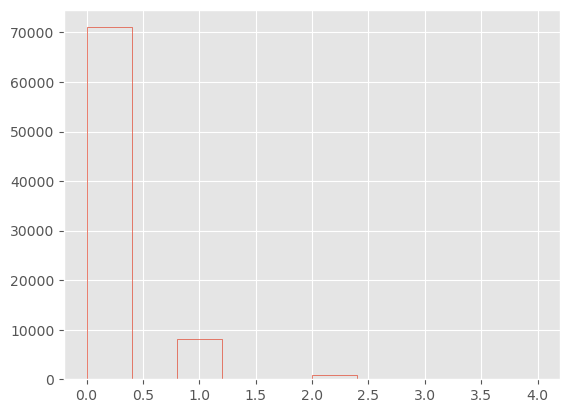

In [42]:
counts, bins = np.histogram(y_train['count_claim_amount'])
plt.stairs(counts, bins)

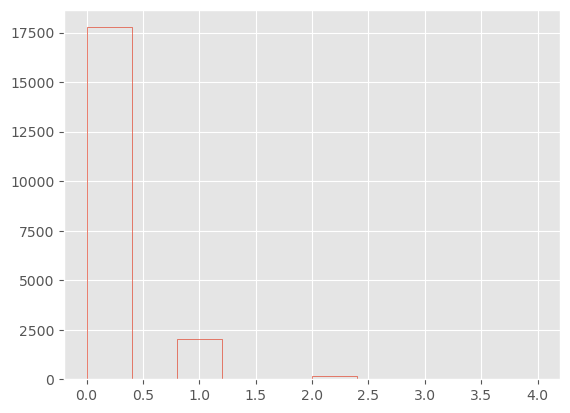

In [43]:
counts, bins = np.histogram(y_test['count_claim_amount'])
plt.stairs(counts, bins)

In [44]:
dist_y_train = y_train['count_claim_amount'].value_counts(normalize=True)
dist_y_train

0.0    0.888136
1.0    0.100714
2.0    0.010138
3.0    0.000913
4.0    0.000100
Name: count_claim_amount, dtype: float64

In [45]:
dist_y_test = y_test['count_claim_amount'].value_counts(normalize=True)
dist_y_test

0.0    0.88835
1.0    0.10150
2.0    0.00895
3.0    0.00115
4.0    0.00005
Name: count_claim_amount, dtype: float64

Comprobemos ahora que siguen una distribución de Poisson

In [46]:
mu = np.mean(y_train)
dist_poisson = np.array([stats.poisson.pmf(k=0, mu=mu)[0],
                         stats.poisson.pmf(k=1, mu=mu)[0],
                         stats.poisson.pmf(k=2, mu=mu)[0],
                         stats.poisson.pmf(k=3, mu=mu)[0],
                         stats.poisson.pmf(k=4, mu=mu)[0],
                         stats.poisson.pmf(k=5, mu=mu)[0]])

stats.chisquare(np.append(np.array(dist_y_train),0),dist_poisson)

In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'


Power_divergenceResult(statistic=0.004753594546258599, pvalue=0.9999999172692633)

In [47]:
mu = np.mean(y_test)

stats.chisquare(np.append(np.array(dist_y_test),0),dist_poisson)

Power_divergenceResult(statistic=0.004183763937360179, pvalue=0.9999999398663103)

In [48]:
dist_y = y['count_claim_amount'].value_counts(normalize=True)
dist_y

0.0    0.888179
1.0    0.100871
2.0    0.009900
3.0    0.000960
4.0    0.000090
Name: count_claim_amount, dtype: float64

In [49]:
mu = np.mean(y['count_claim_amount'])

stats.chisquare(np.append(np.array(dist_y),0), dist_poisson)

Power_divergenceResult(statistic=0.004527710353778977, pvalue=0.9999999267440048)

In [50]:
mu

0.12391123911239113

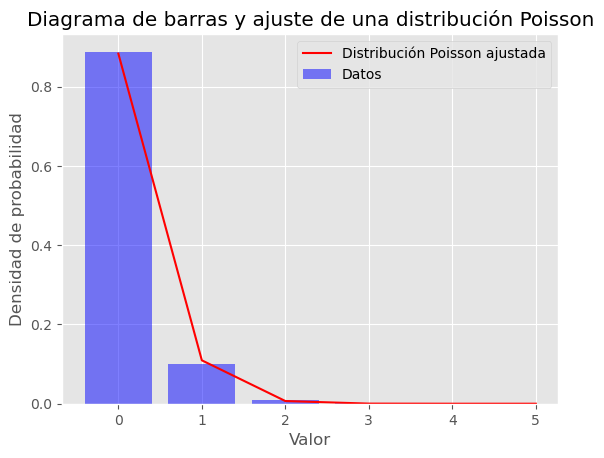

In [51]:
# 1. Visualiza el histograma de los datos
plt.bar(dist_y.index.values, dist_y, alpha=0.5, color='blue', label='Datos')

# 2. Ajusta una distribución Poisson a los datos
mu = np.mean(y['count_claim_amount'])

# 3. Grafica la distribución gamma ajustada
x_plot = np.linspace(0, 5, 6)  # Define el rango de valores en el eje x
distribucion_ajustada = poisson(mu)
y_plot = distribucion_ajustada.pmf(x_plot)
plt.plot(x_plot, y_plot, 'r-', label='Distribución Poisson ajustada')

# Ajusta los límites del eje x
# plt.xlim(0, 20000)

# Añade etiquetas y título al gráfico
plt.xlabel('Valor')
plt.ylabel('Densidad de probabilidad')
plt.title('Diagrama de barras y ajuste de una distribución Poisson')
plt.legend()

# Muestra el gráfico
plt.show()

In [52]:
dist_y

0.0    0.888179
1.0    0.100871
2.0    0.009900
3.0    0.000960
4.0    0.000090
Name: count_claim_amount, dtype: float64

In [53]:
dist_poisson

array([8.83268055e-01, 1.09637018e-01, 6.80443247e-03, 2.81536913e-04,
       8.73655153e-06, 2.16887603e-07])

# 3. Estimación de E[N]

## 3.0. Ajuste e interpretabilidad de una regresión lineal

### 3.0.1. Ajustes de una regresión lineal

In [9]:
# Crear y ajustar el modelo
modelo_LR_count = sm.OLS(y_train['count_claim_amount'], sm.add_constant(X_train)).fit()

# Realizar predicciones
y_pred_LR_count_train = modelo_LR_count.predict(sm.add_constant(X_train))
y_pred_LR_count_test = modelo_LR_count.predict(sm.add_constant(X_test))

# Evaluar el modelo
mse_LR_count_train_pred = mean_squared_error(y_train['count_claim_amount'], y_pred_LR_count_train)
mse_LR_count_test_pred = mean_squared_error(y_test['count_claim_amount'], y_pred_LR_count_test)
print(f"mse_LR_count_train_pred: {mse_LR_count_train_pred}")
print(f"mse_LR_count_test_pred: {mse_LR_count_test_pred}")

mse_LR_count_train_pred: 0.13283475404916076
mse_LR_count_test_pred: 0.13037814032030862


In [11]:
sum_LR_count_train_pred = sum(y_pred_LR_count_train)
sum_LR_count_train_pred

9929.99999995211

In [12]:
sum_LR_count_test_pred = sum(y_pred_LR_count_test)
sum_LR_count_test_pred

2490.798677356703

### 3.0.2. Interpretabilidad directa de una regresión lineal

In [17]:
LR_explainer_low = Kernel_SHAP_shap_values(modelo_LR_count_wrapper, sm.add_constant(X_train), 500)

Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [18]:
X_train_mean = np.insert(X_train.mean().values, 0, 1)
X_train_mean

array([1.00000000e+00, 5.37435218e-01, 1.10596257e+01, 2.73278416e+00,
       5.46730209e+01, 1.55778322e+01, 3.24701184e+01, 9.11853898e+00,
       9.56465706e+00, 1.64664430e+03, 9.14314804e+01, 1.16616083e+01,
       8.68240853e+00, 1.70699721e+02, 1.80618150e+04, 1.12915070e+03,
       3.37285466e+00, 6.43845548e-01, 9.44761810e-02, 1.75414693e-01,
       8.62635783e-02, 2.96616208e-01, 3.00878761e-01, 2.52503156e-02,
       3.77254716e-01, 9.58149477e-01, 4.18505231e-02, 9.37511719e-04,
       7.25509069e-02, 2.66678333e-01, 6.59833248e-01, 3.98479981e-01,
       6.01520019e-01, 2.02915036e-01, 1.28426605e-01, 5.48244353e-01,
       4.50993137e-01, 7.62509531e-04, 9.80012250e-02, 9.01998775e-01,
       1.30376630e-02, 6.37507969e-03, 2.80628508e-01, 1.35051688e-01,
       8.57135714e-02, 4.30180377e-01, 4.90131127e-02])

In [43]:
general_atrib_LR_count = atrib_global_LR(modelo_LR_count)
order_general_atrib_LR_count = get_order_list(general_atrib_LR_count)

In [100]:
t_Kendall_local_shap_LR_count = []
t_Kendall_local_global_LR_count = []
mse_local_shap_LR_count = []
mse_local_global_LR_count = []
sign_local_shap_LR_count = []
sign_local_global_LR_count = []
compare_LR_count_results = []

n_sample = 5
i = 0
print(i, "|", i*100/n_sample, "%,", datetime.now().time())

for X_interpret_count in X_test[0:n_sample].iloc:
    
    X_interpret_count_i = np.insert(np.array(X_interpret_count), 0, 1)
    atrib = atrib_local_LR(modelo_LR_count, X_interpret_count_i, X_train_mean)
    orden = get_order_list(atrib)

    LR_count_shap_values = LR_explainer_low.shap_values(np.array(X_interpret_count_i)) 

    # Comparación de resultados de interpretabilidad de atribución local directa contra KernelSHAP

    LR_count_shap_values_feat = atrib.copy()
    LR_count_shap_values_feat[0:len(LR_count_shap_values_feat)] = LR_count_shap_values
    order_shap = get_order_list(LR_count_shap_values_feat)
    
    compare_LR_count_results_i = pd.DataFrame({'LR local attribution': atrib, 'LR local attribution order': orden, 'SHAP values': LR_count_shap_values, 'SHAP values order': order_shap, 'LR general attribution': general_atrib_LR_count, 'LR general attribution order': order_general_atrib_LR_count})
    compare_LR_count_results.append(compare_LR_count_results_i)

    t_Kendall_local_shap_i, _ = kendalltau(compare_LR_count_results_i['LR local attribution order'], compare_LR_count_results_i['SHAP values order'])
    t_Kendall_global_shap_i, _ = kendalltau(compare_LR_count_results_i['LR local attribution order'], compare_LR_count_results_i['LR general attribution order'])
    
    t_Kendall_local_shap_LR_count.append(t_Kendall_local_shap_i)
    t_Kendall_local_global_LR_count.append(t_Kendall_global_shap_i)
    mse_local_shap_LR_count.append(mean_squared_error(compare_LR_count_results_i['LR local attribution'], compare_LR_count_results_i['SHAP values']))
    mse_local_global_LR_count.append(mean_squared_error(compare_LR_count_results_i['LR local attribution'], compare_LR_count_results_i['LR general attribution']))
    sign_local_shap_LR_count.append(sum(np.sign(compare_LR_count_results_i['LR local attribution']) == np.sign(compare_LR_count_results_i['SHAP values']))/len(compare_LR_count_results_i))
    sign_local_global_LR_count.append(sum(np.sign(compare_LR_count_results_i['LR local attribution']) == np.sign(compare_LR_count_results_i['LR general attribution']))/len(compare_LR_count_results_i))
    
    i = i+1
    if i/10 == int(i/10):
        print(i, "|", i*100/n_sample, "%,", datetime.now().time())

# %store t_Kendall_local_shap_LR_count
# %store t_Kendall_local_global_LR_count
# %store mse_local_shap_LR_count
# %store mse_local_global_LR_count
# %store sign_local_shap_LR_count
# %store sign_local_global_LR_count
# %store compare_LR_count_results

compare_LR_count_indexes = pd.DataFrame({'Tau Kendall: local vs SHAP': np.array(t_Kendall_local_shap_LR_count), 'Tau Kendall: local vs global': np.array(t_Kendall_local_global_LR_count), 'MSE: local vs SHAP': np.array(mse_local_shap_LR_count), 'MSE: local vs global': np.array(mse_local_global_LR_count), 'Sign: local vs SHAP': np.array(sign_local_shap_LR_count), 'Sign: local vs global': np.array(sign_local_global_LR_count)})
# %store compare_LR_count_indexes
compare_LR_count_indexes

0 | 0.0 %, 08:46:49.332003


Tau Kendall: local vs SHAP  Tau Kendall: local vs global  \
0                    0.979648                      0.043478   
1                    0.970398                      0.121184   
2                    0.972248                      0.137835   
3                    0.983349                      0.100833   
4                    0.979648                      0.012026   

   MSE: local vs SHAP  MSE: local vs global  Sign: local vs SHAP  \
0        5.667666e-08              0.000796             0.978723   
1        5.667666e-08              0.000763             0.978723   
2        5.667666e-08              0.000750             0.978723   
3        5.667666e-08              0.000739             0.978723   
4        5.667666e-08              0.000826             0.978723   

   Sign: local vs global  
0               0.404255  
1               0.276596  
2               0.319149  
3               0.255319  
4               0.404255

## 3.1. Ajuste de una GLM Poisson

In [39]:
# Aplicamos una GLM Poisson

modelo_glm_Poisson = sm.GLM(y_train['count_claim_amount'], sm.add_constant(X_train), family=sm.families.Poisson())
resultado_modelo_glm_Poisson = modelo_glm_Poisson.fit()
y_pred_glm_Poisson_train = resultado_modelo_glm_Poisson.predict(sm.add_constant(X_train))
y_pred_glm_Poisson_test = resultado_modelo_glm_Poisson.predict(sm.add_constant(X_test))

In [114]:
mse_glm_Poisson_train_med = mean_squared_error(y_train['count_claim_amount'], np.full(len(y_train), np.mean(y_train['count_claim_amount'])))
mse_glm_Poisson_train_med

0.13566948765349296

In [115]:
mse_glm_Poisson_train_pred = mean_squared_error(y_train['count_claim_amount'], y_pred_glm_Poisson_train)
mse_glm_Poisson_train_pred

0.13271491035505714

In [117]:
mse_glm_Poisson_test_med = mean_squared_error(y_test['count_claim_amount'], np.full(len(y_test), np.mean(y_train['count_claim_amount'])))
mse_glm_Poisson_test_med

0.13330985646330845

In [118]:
mse_glm_Poisson_test_pred = mean_squared_error(y_test['count_claim_amount'], y_pred_glm_Poisson_test)
mse_glm_Poisson_test_pred

0.1303170127925368

In [59]:
sum(y_train['count_claim_amount'])

9930.0

In [120]:
sum_glm_Poisson_train_pred = sum(y_pred_glm_Poisson_train)
sum_glm_Poisson_train_pred

9930.000000641103

In [61]:
sum(y_test['count_claim_amount'])

2461.0

In [121]:
sum_glm_Poisson_test_pred = sum(y_pred_glm_Poisson_test)
sum_glm_Poisson_test_pred

2492.2581642715695

## 3.2. Interpretabilidad de la GLM Poisson

### 3.2.1. Interpretabilidad directa de la GLM Poisson

In [73]:
# Entrada que deseamos interpretar

X_interpret_count_1 = sm.add_constant(X_test).iloc[1]
X_interpret_count_1_np = np.array(X_interpret_count_1)
X_interpret_count_1

const                           1.0
pol_bonus                       0.5
pol_duration                    9.0
pol_sit_duration                5.0
drv_age1                       54.0
drv_age2                        0.0
drv_age_lic1                   35.0
drv_age_lic2                    0.0
vh_age                         13.0
vh_cyl                       1149.0
vh_din                         59.0
vh_sale_begin                  13.0
vh_sale_end                    11.0
vh_speed                      160.0
vh_value                    10962.0
vh_weight                     890.0
pol_insee_density               1.0
pol_coverage_Maxi               0.0
pol_coverage_Median1            0.0
pol_coverage_Median2            1.0
pol_coverage_Mini               0.0
pol_pay_freq_Biannual           0.0
pol_pay_freq_Monthly            1.0
pol_pay_freq_Quarterly          0.0
pol_pay_freq_Yearly             0.0
pol_payd_No                     1.0
pol_payd_Yes                    0.0
pol_usage_AllTrips          

In [74]:
# Otra forma de asegurar la predicción

resultado_modelo_glm_Poisson.predict(sm.add_constant(X_test).iloc[1])[0]

0.08027313125104872

In [75]:
# Interpretación local directa, vemos que cuadra con la total

np.exp(np.dot(resultado_modelo_glm_Poisson.params, X_interpret_count_1))

0.08027313125104872

In [77]:
np.prod(np.exp(resultado_modelo_glm_Poisson.params*X_interpret_count_1))

0.08027313125104871

In [79]:
atrib_1 = atrib_local_GLM(resultado_modelo_glm_Poisson, X_interpret_count_1, X_train_mean)
orden_1 = get_order_list(atrib_1)

In [80]:
atrib_1

const                       0.000000e+00
pol_bonus                  -7.118291e-04
pol_duration                4.323548e-05
pol_sit_duration           -8.348851e-04
drv_age1                   -3.521116e-05
drv_age2                    4.809771e-03
drv_age_lic1               -9.724485e-05
drv_age_lic2               -9.215357e-05
vh_age                     -7.052360e-03
vh_cyl                     -6.068016e-03
vh_din                      3.763363e-04
vh_sale_begin              -2.949784e-04
vh_sale_end                 4.657808e-05
vh_speed                   -3.854881e-04
vh_value                   -5.425207e-04
vh_weight                   1.742717e-05
pol_insee_density           2.947970e-03
pol_coverage_Maxi          -1.696614e-02
pol_coverage_Median1        2.827148e-07
pol_coverage_Median2       -7.647329e-05
pol_coverage_Mini           9.055643e-03
pol_pay_freq_Biannual       6.861363e-03
pol_pay_freq_Monthly       -1.620021e-02
pol_pay_freq_Quarterly      5.254925e-06
pol_pay_freq_Yea

In [81]:
orden_1

const                       47.0
pol_bonus                   22.0
pol_duration                35.0
pol_sit_duration            21.0
drv_age1                    36.0
drv_age2                    14.0
drv_age_lic1                31.0
drv_age_lic2                32.0
vh_age                      11.0
vh_cyl                      13.0
vh_din                      27.0
vh_sale_begin               29.0
vh_sale_end                 34.0
vh_speed                    26.0
vh_value                    25.0
vh_weight                   39.0
pol_insee_density           15.0
pol_coverage_Maxi            5.0
pol_coverage_Median1        44.0
pol_coverage_Median2        33.0
pol_coverage_Mini           10.0
pol_pay_freq_Biannual       12.0
pol_pay_freq_Monthly         6.0
pol_pay_freq_Quarterly      42.0
pol_pay_freq_Yearly          8.0
pol_payd_No                 30.0
pol_payd_Yes                24.0
pol_usage_AllTrips          45.0
pol_usage_Professional      28.0
pol_usage_Retired            7.0
pol_usage_

### 3.2.2. Interpretabilidad de la GLM Poisson mediante SHAP values

In [82]:
glm_Poisson_explainer = Kernel_SHAP_shap_values(resultado_modelo_glm_Poisson_wrapper, sm.add_constant(X_train), 10000)

Using 10000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [83]:
glm_Poisson_shap_values = glm_Poisson_explainer.shap_values(np.array(X_interpret_count_1)) 
glm_Poisson_shap_values

array([ 0.        , -0.00279557,  0.00081356, -0.00341793,  0.        ,
        0.00754043, -0.00097733, -0.00115525, -0.01298187, -0.00915031,
        0.00224648, -0.00367419,  0.00147239, -0.00262987, -0.00292556,
        0.00059772,  0.00535031, -0.01624175,  0.00012668, -0.00095098,
        0.00410098,  0.00855417, -0.01392795,  0.00021186,  0.01144751,
       -0.00119953,  0.00203074,  0.        ,  0.00193961,  0.01216035,
       -0.01317567, -0.02560827,  0.02919323, -0.00516256, -0.00307375,
        0.01568125, -0.02805704, -0.0001057 ,  0.00375807, -0.00437692,
        0.00023867,  0.00024019, -0.00599127,  0.00015741,  0.00068334,
        0.00487845,  0.00046059])

In [84]:
glm_Poisson_explainer.expected_value

0.12396841001588188

In [85]:
glm_Poisson_explainer.expected_value + sum(glm_Poisson_shap_values)

0.08027313125104872

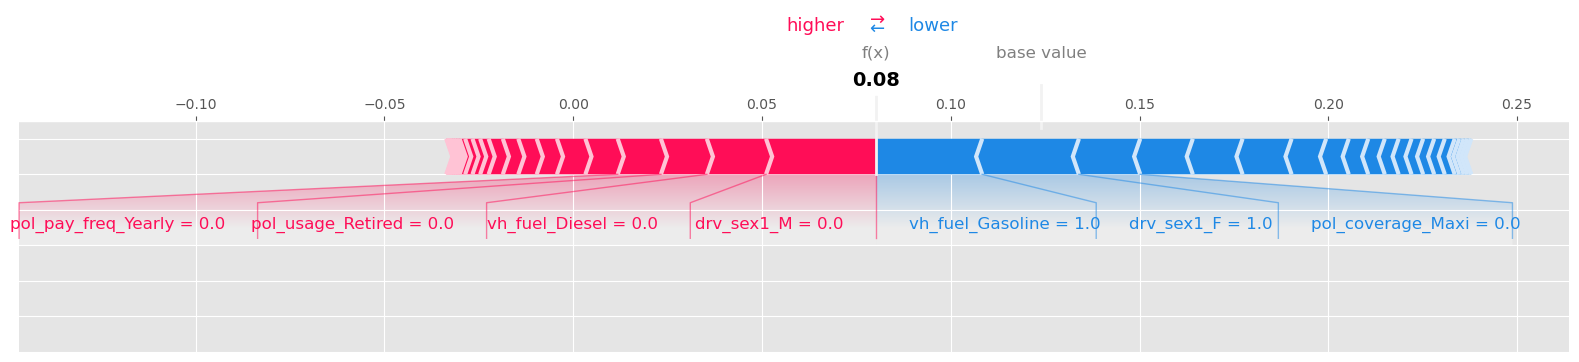

In [86]:
shap_force_plot(glm_Poisson_explainer.expected_value, glm_Poisson_shap_values, X_interpret_count_1)

In [60]:
# Reducimos el número de iteraciones para que la máquina lo pueda soportar

glm_Poisson_explainer_low = Kernel_SHAP_shap_values(resultado_modelo_glm_Poisson_wrapper, sm.add_constant(X_train), 500)
# glm_Poisson_shap_values_low = glm_Poisson_explainer_low.shap_values(np.array(X_interpret_count_1))

Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/9 [00:00<?, ?it/s]

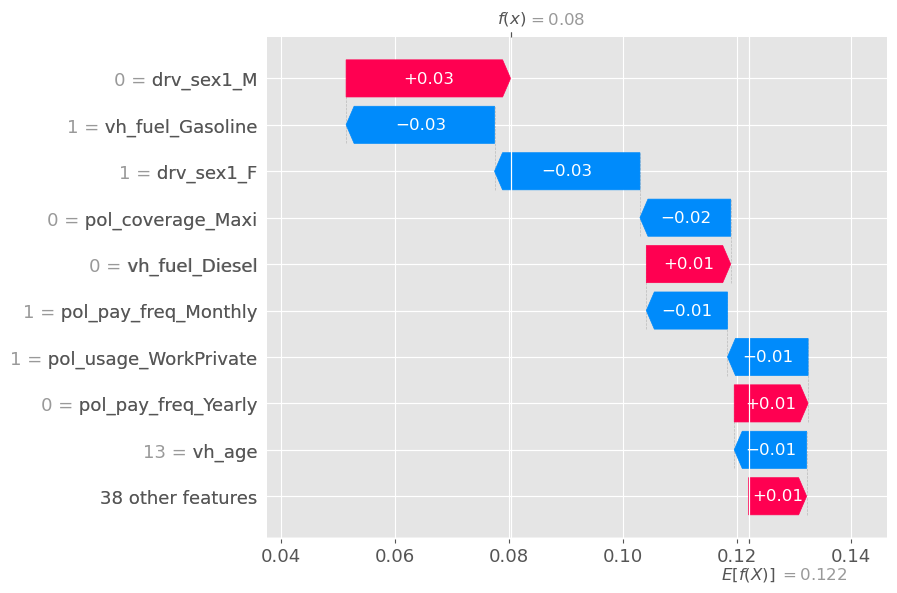

In [88]:
shap_waterfall_plot(glm_Poisson_explainer_low, sm.add_constant(X_test), 1, 10, X_interpret_count_1.index.tolist(), 10)

In [62]:
general_atrib_GLM_Poisson = atrib_global_GLM(resultado_modelo_glm_Poisson)
order_general_atrib_GLM_Poisson = get_order_list(general_atrib_GLM_Poisson)

### 3.2.3. Contraste de atribuciones de la GLM Poisson

In [113]:
# Comparación de resultados de interpretabilidad de atribución local directa contra KernelSHAP

glm_Poisson_shap_values_feat = atrib_1.copy()
glm_Poisson_shap_values_feat[0:len(glm_Poisson_shap_values_feat)] = glm_Poisson_shap_values
order_shap = get_order_list(glm_Poisson_shap_values_feat)
pd.options.display.float_format = custom_format

compare_GLM_Poisson_results = pd.DataFrame({'GLM local attribution': atrib_1, 'GLM local attribution order': orden_1, 'SHAP values': glm_Poisson_shap_values, 'SHAP values order': order_shap, 'GLM general attribution': general_atrib_GLM_Poisson, 'GLM general attribution order': order_general_atrib_GLM_Poisson})
compare_GLM_Poisson_results.sort_values(by='GLM local attribution order')

GLM local attribution  GLM local attribution order  \
drv_sex1_M                             0.095470                            1   
vh_fuel_Gasoline                      -0.047059                            2   
drv_sex1_F                            -0.046885                            3   
vh_fuel_Diesel                         0.020196                            4   
pol_coverage_Maxi                     -0.016966                            5   
pol_pay_freq_Monthly                  -0.016200                            6   
pol_usage_Retired                      0.014922                            7   
pol_pay_freq_Yearly                    0.014317                            8   
pol_usage_WorkPrivate                 -0.014120                            9   
pol_coverage_Mini                      0.009056                           10   
vh_age                                -0.007052                           11   
pol_pay_freq_Biannual                  0.006861                           12   
vh_cyl                                -0.006068                           13   
drv_age2                               0.004810                           14   
pol_insee_density                      0.002948                           15   
vh_make_group_FRANCE                  -0.002788                           16   
vh_make_group_STELLANTIS               0.002327                           17   
drv_sex2_F                            -0.001991                           18   
vh_type_Tourism                       -0.001952                           19   
vh_type_Commercial                     0.001535                           20   
pol_sit_duration                      -0.000835                           21   
pol_bonus                             -0.000712                           22   
drv_sex2_M                            -0.000697                           23   
pol_payd_Yes                           0.000565                           24   
vh_value                              -0.000543                           25   
vh_speed                              -0.000385                           26   
vh_din                                 0.000376                           27   
pol_usage_Professional                 0.000301                           28   
vh_sale_begin                         -0.000295                           29   
pol_payd_No                           -0.000147                           30   
drv_age_lic1                          -0.000097                           31   
drv_age_lic2                          -0.000092                           32   
pol_coverage_Median2                  -0.000076                           33   
vh_sale_end                            0.000047                           34   
pol_duration                           0.000043                           35   
drv_age1                              -0.000035                           36   
vh_make_group_JAPAN                    0.000027                           37   
vh_make_group_USA                      0.000024                           38   
vh_weight                              0.000017                           39   
vh_make_group_GERMANY                  0.000014                           40   
vh_make_group_ASIA                     0.000007                           41   
pol_pay_freq_Quarterly                 0.000005                           42   
vh_make_group_EUROPE                   0.000003                           43   
pol_coverage_Median1                   0.000000                           44   
pol_usage_AllTrips                    -0.000000                           45   
vh_fuel_Hybrid                         0.000000                           46   
const                                         0                           47   

                          SHAP values  SHAP values order  \
drv_sex1_M                  -0.015852                  7   
vh_fuel_Gasoline            -0.022478                  2   
drv_s

### Caso 1

#### Índices de coherencia de órdenes

In [ ]:
# Tau de Kendall

# from scipy.stats import kendalltau

# list1 = [1, 2, 3, 4, 5]
# list2 = [5, 4, 3, 2, 1]
# list3 = [2, 5, 4, 1, 3]

# coef, _ = kendalltau(list1, list3)
# print('Kendall Tau coefficient:', coef)


In [ ]:
t_Kendall_local_shap_1, _ = kendalltau(compare_GLM_Poisson_results['GLM local attribution order'], compare_GLM_Poisson_results['SHAP values order'])
t_Kendall_local_shap_1

In [ ]:
t_Kendall_local_global_1, _ = kendalltau(compare_GLM_Poisson_results['GLM local attribution order'], compare_GLM_Poisson_results['GLM general attribution order'])
t_Kendall_local_global_1

#### Error cuadrático medio

In [ ]:
mse_local_shap_1 = mean_squared_error(compare_GLM_Poisson_results['GLM local attribution'], compare_GLM_Poisson_results['SHAP values'])
mse_local_shap_1

In [ ]:
mse_local_general_1 = mean_squared_error(compare_GLM_Poisson_results['GLM local attribution'], compare_GLM_Poisson_results['GLM general attribution'])
mse_local_general_1

#### Comparación de signos

In [ ]:
sign_local_shap_1 = sum(np.sign(compare_GLM_Poisson_results['GLM local attribution']) == np.sign(compare_GLM_Poisson_results['SHAP values']))/len(compare_GLM_Poisson_results)
sign_local_shap_1

In [ ]:
sign_local_general_1 = sum(np.sign(compare_GLM_Poisson_results['GLM local attribution']) == np.sign(compare_GLM_Poisson_results['GLM general attribution']))/len(compare_GLM_Poisson_results)
sign_local_general_1

### Caso 3

In [ ]:
X_interpret_count_3 = sm.add_constant(X_test).iloc[3]

atrib_3 = atrib_local_GLM(resultado_modelo_glm_Poisson, X_interpret_count_3, X_train_mean)
orden_3 = get_order_list(atrib_3)

glm_Poisson_shap_values_3 = glm_Poisson_explainer_low.shap_values(np.array(X_interpret_count_3)) 

# Comparación de resultados de interpretabilidad de atribución local directa contra KernelSHAP

glm_Poisson_shap_values_feat_3 = atrib_3.copy()
glm_Poisson_shap_values_feat_3[0:len(glm_Poisson_shap_values_feat_3)] = glm_Poisson_shap_values_3
order_shap_3 = get_order_list(glm_Poisson_shap_values_feat_3)

compare_GLM_Poisson_results_3 = pd.DataFrame({'GLM local attribution': atrib_3, 'GLM local attribution order': orden_3, 'SHAP values': glm_Poisson_shap_values_3, 'SHAP values order': order_shap_3, 'GLM general attribution': general_atrib_GLM_Poisson, 'GLM general attribution order': order_general_atrib_GLM_Poisson})
compare_GLM_Poisson_results_3.sort_values(by='GLM local attribution order')

#### Índices de coherencia de órdenes

In [ ]:
t_Kendall_local_shap_3, _ = kendalltau(compare_GLM_Poisson_results_3['GLM local attribution order'], compare_GLM_Poisson_results_3['SHAP values order'])
t_Kendall_local_shap_3

In [ ]:
t_Kendall_local_global_3, _ = kendalltau(compare_GLM_Poisson_results_3['GLM local attribution order'], compare_GLM_Poisson_results_3['GLM general attribution order'])
t_Kendall_local_global_3

#### Error cuadrático medio

In [ ]:
mse_local_shap_3 = mean_squared_error(compare_GLM_Poisson_results_3['GLM local attribution'], compare_GLM_Poisson_results_3['SHAP values'])
mse_local_shap_3

In [ ]:
mse_local_general_3 = mean_squared_error(compare_GLM_Poisson_results_3['GLM local attribution'], compare_GLM_Poisson_results_3['GLM general attribution'])
mse_local_general_3

#### Comparación de signos

In [ ]:
sign_local_shap_3 = sum(np.sign(compare_GLM_Poisson_results_3['GLM local attribution']) == np.sign(compare_GLM_Poisson_results_3['SHAP values']))/len(compare_GLM_Poisson_results)
sign_local_shap_3

In [ ]:
sign_local_general_3 = sum(np.sign(compare_GLM_Poisson_results_3['GLM local attribution']) == np.sign(compare_GLM_Poisson_results_3['GLM general attribution']))/len(compare_GLM_Poisson_results)
sign_local_general_3

### Caso 2

In [ ]:
X_interpret_count_2 = sm.add_constant(X_test).iloc[2]

atrib_2 = atrib_local_GLM(resultado_modelo_glm_Poisson, X_interpret_count_2, X_train_mean)
orden_2 = get_order_list(atrib_2)

glm_Poisson_shap_values_2 = glm_Poisson_explainer_low.shap_values(np.array(X_interpret_count_2)) 

# Comparación de resultados de interpretabilidad de atribución local directa contra KernelSHAP

glm_Poisson_shap_values_feat_2 = atrib_2.copy()
glm_Poisson_shap_values_feat_2[0:len(glm_Poisson_shap_values_feat_2)] = glm_Poisson_shap_values_2
order_shap_2 = get_order_list(glm_Poisson_shap_values_feat_2)

compare_GLM_Poisson_results_2 = pd.DataFrame({'GLM local attribution': atrib_2, 'GLM local attribution order': orden_2, 'SHAP values': glm_Poisson_shap_values_2, 'SHAP values order': order_shap_2, 'GLM general attribution': general_atrib_GLM_Poisson, 'GLM general attribution order': order_general_atrib_GLM_Poisson})
compare_GLM_Poisson_results_2.sort_values(by='GLM local attribution order')

#### Índices de coherencia de órdenes

In [ ]:
t_Kendall_local_shap_2, _ = kendalltau(compare_GLM_Poisson_results_2['GLM local attribution order'], compare_GLM_Poisson_results_2['SHAP values order'])
t_Kendall_local_shap_2

In [ ]:
t_Kendall_local_global_2, _ = kendalltau(compare_GLM_Poisson_results_2['GLM local attribution order'], compare_GLM_Poisson_results_2['GLM general attribution order'])
t_Kendall_local_global_2

#### Error cuadrático medio

In [ ]:
mse_local_shap_2 = mean_squared_error(compare_GLM_Poisson_results_2['GLM local attribution'], compare_GLM_Poisson_results_2['SHAP values'])
mse_local_shap_2

In [ ]:
mse_local_general_2 = mean_squared_error(compare_GLM_Poisson_results_2['GLM local attribution'], compare_GLM_Poisson_results_2['GLM general attribution'])
mse_local_general_2

#### Comparación de signos

In [ ]:
sign_local_shap_2 = sum(np.sign(compare_GLM_Poisson_results_2['GLM local attribution']) == np.sign(compare_GLM_Poisson_results_2['SHAP values']))/len(compare_GLM_Poisson_results)
sign_local_shap_2

In [ ]:
sign_local_general_2 = sum(np.sign(compare_GLM_Poisson_results_2['GLM local attribution']) == np.sign(compare_GLM_Poisson_results_2['GLM general attribution']))/len(compare_GLM_Poisson_results)
sign_local_general_2

In [ ]:
t_Kendall_local_shap = np.array([t_Kendall_local_shap_1, t_Kendall_local_shap_2, t_Kendall_local_shap_3])
t_Kendall_local_global = np.array([t_Kendall_local_global_1, t_Kendall_local_global_2, t_Kendall_local_global_3])
mse_local_shap = np.array([mse_local_shap_1, mse_local_shap_2, mse_local_shap_3])
mse_local_global = np.array([mse_local_general_1, mse_local_general_2, mse_local_general_3])
sign_local_shap = np.array([sign_local_shap_1, sign_local_shap_2, sign_local_shap_3])
sign_local_global = np.array([sign_local_general_1, sign_local_general_2, sign_local_general_3])

In [ ]:
compare_GLM_Poisson_indexes = pd.DataFrame({'Tau Kendall: local vs SHAP': t_Kendall_local_shap, 'Tau Kendall: local vs global': t_Kendall_local_global, 'MSE: local vs SHAP': mse_local_shap, 'MSE: local vs global': mse_local_global, 'Sign: local vs SHAP': sign_local_shap, 'Sign: local vs global': sign_local_global})
compare_GLM_Poisson_indexes.index = ['Caso 1', 'Caso 2', 'Caso 3']
compare_GLM_Poisson_indexes #.sort_values(by='GLM local attribution order')

In [ ]:
# Exportar el DataFrame a un archivo Excel (.xlsx)

# compare_GLM_Poisson_results.to_excel('compare_GLM_Poisson_results.xlsx', index=False)
# compare_GLM_Poisson_indexes.to_excel('compare_GLM_Poisson_indexes.xlsx', index=False)

### Muestra de casos para GLM de conteo

In [79]:
t_Kendall_local_shap = []
t_Kendall_local_global = []
mse_local_shap = []
mse_local_global = []
sign_local_shap = []
sign_local_global = []
compare_GLM_Poisson_results = []

n_sample = 5
i = 0
print(i, "|", i*100/n_sample, "%,", datetime.now().time())

for X_interpret_count in X_test[0:n_sample].iloc:
    
    X_interpret_count_i = np.insert(np.array(X_interpret_count), 0, 1)
    atrib = atrib_local_GLM(resultado_modelo_glm_Poisson, X_interpret_count_i, X_train_mean)
    orden = get_order_list(atrib)

    glm_Poisson_shap_values = glm_Poisson_explainer_low.shap_values(np.array(X_interpret_count_i)) 

    # Comparación de resultados de interpretabilidad de atribución local directa contra KernelSHAP

    glm_Poisson_shap_values_feat = atrib.copy()
    glm_Poisson_shap_values_feat[0:len(glm_Poisson_shap_values_feat)] = glm_Poisson_shap_values
    order_shap = get_order_list(glm_Poisson_shap_values_feat)
    
    compare_GLM_Poisson_results_i = pd.DataFrame({'GLM local attribution': atrib, 'GLM local attribution order': orden, 'SHAP values': glm_Poisson_shap_values, 'SHAP values order': order_shap, 'GLM general attribution': general_atrib_GLM_Poisson, 'GLM general attribution order': order_general_atrib_GLM_Poisson})
    compare_GLM_Poisson_results.append(compare_GLM_Poisson_results_i)

    t_Kendall_local_shap_i, _ = kendalltau(compare_GLM_Poisson_results_i['GLM local attribution order'], compare_GLM_Poisson_results_i['SHAP values order'])
    t_Kendall_global_shap_i, _ = kendalltau(compare_GLM_Poisson_results_i['GLM local attribution order'], compare_GLM_Poisson_results_i['GLM general attribution order'])
    
    t_Kendall_local_shap.append(t_Kendall_local_shap_i)
    t_Kendall_local_global.append(t_Kendall_global_shap_i)
    mse_local_shap.append(mean_squared_error(compare_GLM_Poisson_results_i['GLM local attribution'], compare_GLM_Poisson_results_i['SHAP values']))
    mse_local_global.append(mean_squared_error(compare_GLM_Poisson_results_i['GLM local attribution'], compare_GLM_Poisson_results_i['GLM general attribution']))
    sign_local_shap.append(sum(np.sign(compare_GLM_Poisson_results_i['GLM local attribution']) == np.sign(compare_GLM_Poisson_results_i['SHAP values']))/len(compare_GLM_Poisson_results_i))
    sign_local_global.append(sum(np.sign(compare_GLM_Poisson_results_i['GLM local attribution']) == np.sign(compare_GLM_Poisson_results_i['GLM general attribution']))/len(compare_GLM_Poisson_results_i))
    
    i = i+1
    if i/10 == int(i/10):
        print(i, "|", i*100/n_sample, "%,", datetime.now().time())

# %store t_Kendall_local_shap
# %store t_Kendall_local_global
# %store mse_local_shap
# %store mse_local_global
# %store sign_local_shap
# %store sign_local_global
# %store compare_GLM_Poisson_results

compare_GLM_Poisson_indexes = pd.DataFrame({'Tau Kendall: local vs SHAP': np.array(t_Kendall_local_shap), 'Tau Kendall: local vs global': np.array(t_Kendall_local_global), 'MSE: local vs SHAP': np.array(mse_local_shap), 'MSE: local vs global': np.array(mse_local_global), 'Sign: local vs SHAP': np.array(sign_local_shap), 'Sign: local vs global': np.array(sign_local_global)})
# %store compare_GLM_Poisson_indexes
compare_GLM_Poisson_indexes

0 | 0.0 %, 11:38:59.851597


Tau Kendall: local vs SHAP  Tau Kendall: local vs global  \
0                    0.219241                      0.900093   
1                    0.197040                      0.898242   
2                    0.195190                      0.966698   
3                    0.187789                      0.953747   
4                    0.104533                      0.962997   

   MSE: local vs SHAP  MSE: local vs global  Sign: local vs SHAP  \
0            0.084709              0.041170             0.404255   
1            0.089239              0.068069             0.276596   
2            0.100415              0.044695             0.319149   
3            0.097375              0.044692             0.234043   
4            0.101212              0.044694             0.425532   

   Sign: local vs global  
0               0.978723  
1               1.000000  
2               0.978723  
3               0.978723  
4               1.000000

In [16]:
# Veamos qué ocurre si en vez de aplicar la tau de Kendall al vector de orden, se lo aplicamos al valor absoluto de las
#atribuciones directamente

aux = compare_GLM_Poisson_results[3]
print(kendalltau(aux['GLM local attribution order'], aux['SHAP values order']))
print(kendalltau(abs(aux['GLM local attribution']), abs(aux['SHAP values'])))

KendalltauResult(correlation=0.8982423681776134, pvalue=5.362223520548662e-19)
KendalltauResult(correlation=0.9098611245400264, pvalue=2.6068894410915167e-19)


## 3.3. Ajuste de un árbol de decisión CART

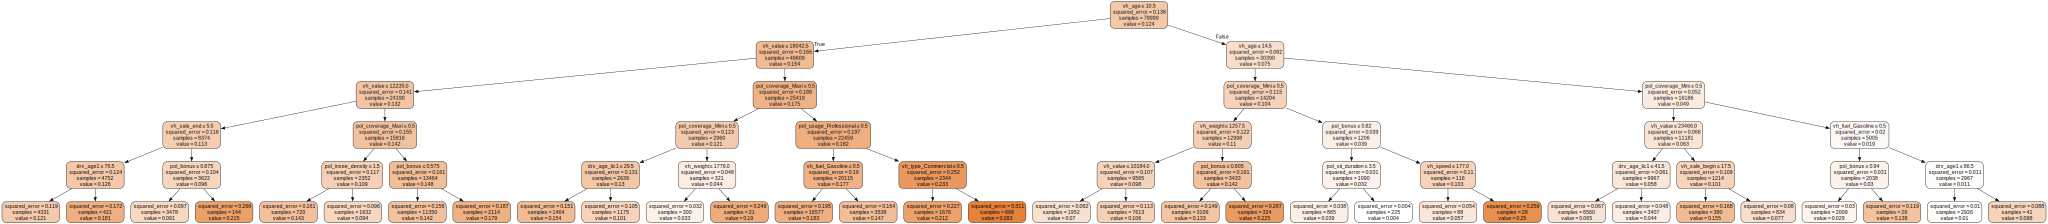

In [4]:
# Crear un modelo de árbol de decisión
tree_model = DecisionTreeRegressor(max_depth=5, min_samples_leaf=20)  # Puedes ajustar max_depth según sea necesario

# Entrenar el modelo
tree_model.fit(X_train, y_train['count_claim_amount'])

# Realizar predicciones en el conjunto de entrenamiento
y_pred_CART_train = tree_model.predict(X_train)
y_pred_CART_test = tree_model.predict(X_test)

# Visualizar el árbol usando plot_tree
# plt.figure(figsize=(12, 8))

# Exportar el árbol a un archivo DOT
dot_data = export_graphviz(tree_model, out_file=None, 
                           feature_names=X_train.columns,  
                           filled=True, rounded=True,  
                           special_characters=True)  

# Usar graphviz para visualizar el archivo DOT
graph = graphviz.Source(dot_data)  
graph.render("decision_tree")  # Esto guarda el árbol como un archivo PDF llamado 'decision_tree.pdf'

# Mostrar el gráfico directamente en el notebook (si estás usando Jupyter Notebook)
graph

In [229]:
mse_glm_Poisson_train_med

0.13566948765349296

In [232]:
mse_glm_Poisson_train_pred

0.13271491035505714

In [231]:
mse_CART_train_pred = mean_squared_error(y_train['count_claim_amount'], y_pred_CART_train)
mse_CART_train_pred

0.1327127994443208

In [233]:
mse_glm_Poisson_test_med

0.13330985646330845

In [234]:
mse_glm_Poisson_test_pred

0.1303170127925368

In [235]:
mse_CART_test_pred = mean_squared_error(y_test['count_claim_amount'], y_pred_CART_test)
mse_CART_test_pred

0.13075082340720068

In [236]:
sum(y_train['count_claim_amount'])

9930.0

In [237]:
sum_glm_Poisson_train_pred

9930.000000641103

In [238]:
sum_CART_train_pred = sum(y_pred_CART_train)
sum_CART_train_pred

9929.999999997497

In [239]:
sum(y_test['count_claim_amount'])

2461.0

In [240]:
sum_glm_Poisson_test_pred

2492.2581642715695

In [241]:
sum_CART_test_pred = sum(y_pred_CART_test)
sum_CART_test_pred

2490.784555922531

## 3.4. Interpretabilidad del árbol de decisión CART

### 3.4.1. Interpretabilidad directa del árbol de decisión CART

In [413]:
# Interpretabilidad global de Gini

tree_model_Gini_atrib = X_train.iloc[0].copy()
tree_model_Gini_atrib[0:len(X_train.iloc[0])] = tree_model.feature_importances_
tree_model_Gini_atrib

pol_bonus                  0.033421
pol_duration                      0
pol_sit_duration           0.000917
drv_age1                   0.007008
drv_age2                          0
drv_age_lic1               0.011781
drv_age_lic2                      0
vh_age                     0.597633
vh_cyl                            0
vh_din                            0
vh_sale_begin              0.006805
vh_sale_end                0.008027
vh_speed                   0.003351
vh_value                   0.132884
vh_weight                  0.022413
pol_insee_density          0.005135
pol_coverage_Maxi          0.054820
pol_coverage_Median1              0
pol_coverage_Median2              0
pol_coverage_Mini          0.060559
pol_pay_freq_Biannual             0
pol_pay_freq_Monthly              0
pol_pay_freq_Quarterly            0
pol_pay_freq_Yearly               0
pol_payd_No                       0
pol_payd_Yes                      0
pol_usage_AllTrips                0
pol_usage_Professional     0

In [203]:
X_test.iloc[1]

pol_bonus                  0.500000
pol_duration                      9
pol_sit_duration                  5
drv_age1                         54
drv_age2                          0
drv_age_lic1                     35
drv_age_lic2                      0
vh_age                           13
vh_cyl                         1149
vh_din                           59
vh_sale_begin                    13
vh_sale_end                      11
vh_speed                        160
vh_value                      10962
vh_weight                       890
pol_insee_density                 1
pol_coverage_Maxi                 0
pol_coverage_Median1              0
pol_coverage_Median2              1
pol_coverage_Mini                 0
pol_pay_freq_Biannual             0
pol_pay_freq_Monthly              1
pol_pay_freq_Quarterly            0
pol_pay_freq_Yearly               0
pol_payd_No                       1
pol_payd_Yes                      0
pol_usage_AllTrips                0
pol_usage_Professional      

In [244]:
expected_value_CART = tree_model.tree_.value[0][0][0]
expected_value_CART

0.12412655158189477

In [414]:
local_CART_atrib = atrib_local_CART(tree_model,  X_test.iloc[1])
local_CART_atrib[local_CART_atrib != 0]

X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


vh_age              -0.020142
vh_value             0.007256
vh_weight           -0.011533
pol_coverage_Mini    0.006032
Name: 47735, dtype: float64

In [415]:
expected_value_CART + sum(local_CART_atrib)

0.10574018126888217

In [248]:
tree_model.predict(np.array(X_test.iloc[1]).reshape(1, -1))

X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


array([0.10574018])

In [274]:
X_train_mean_CART = X_test.iloc[1].copy()
X_train_mean_CART[0:len(X_train_mean_CART)] = X_train_mean[1:len(X_train_mean)]

In [280]:
nodos_atrib_mean = atrib_local_CART(tree_model,  X_train_mean_CART)
nodos_atrib_mean[nodos_atrib_mean != 0]

X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


vh_age                    0.030160
vh_value                  0.020937
pol_coverage_Maxi         0.007154
pol_usage_Professional   -0.005842
vh_fuel_Gasoline          0.006248
Name: 47735, dtype: float64

### 3.4.2. Interpretabilidad del árbol de decisión CART mediante los SHAP values

In [9]:
CART_explainer = Kernel_SHAP_shap_values(tree_model.predict, X_train, 10000)
CART_explainer_low = Kernel_SHAP_shap_values(tree_model.predict, X_train, 500)

Using 10000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [307]:
CART_shap_values = X_test.iloc[1].copy()
CART_shap_values[0:len(CART_shap_values)] = CART_explainer.shap_values(np.array(X_test.iloc[1])) 
CART_shap_values

pol_bonus                  -0.000833
pol_duration                       0
pol_sit_duration                   0
drv_age1                   -0.000263
drv_age2                           0
drv_age_lic1               -0.000354
drv_age_lic2                       0
vh_age                      0.001310
vh_cyl                             0
vh_din                             0
vh_sale_begin                      0
vh_sale_end                -0.002501
vh_speed                           0
vh_value                   -0.007869
vh_weight                  -0.005598
pol_insee_density           0.001047
pol_coverage_Maxi          -0.006800
pol_coverage_Median1               0
pol_coverage_Median2       -0.000141
pol_coverage_Mini           0.006285
pol_pay_freq_Biannual              0
pol_pay_freq_Monthly               0
pol_pay_freq_Quarterly             0
pol_pay_freq_Yearly                0
pol_payd_No                -0.000221
pol_payd_Yes               -0.000235
pol_usage_AllTrips                 0
p

In [315]:
CART_shap_values[CART_shap_values != 0]

pol_bonus                -0.000833
drv_age1                 -0.000263
drv_age_lic1             -0.000354
vh_age                    0.001310
vh_sale_end              -0.002501
vh_value                 -0.007869
vh_weight                -0.005598
pol_insee_density         0.001047
pol_coverage_Maxi        -0.006800
pol_coverage_Median2     -0.000141
pol_coverage_Mini         0.006285
pol_payd_No              -0.000221
pol_payd_Yes             -0.000235
pol_usage_Professional   -0.000388
drv_sex2_M               -0.000107
vh_fuel_Diesel           -0.000013
vh_fuel_Gasoline         -0.001426
vh_type_Commercial       -0.000178
vh_make_group_ASIA       -0.000277
vh_make_group_GERMANY    -0.000147
Name: 47735, dtype: float64

In [278]:
expected_value_CART + sum(CART_shap_values)

0.10537306683512809

In [317]:
nodos_atrib[nodos_atrib != 0]

vh_age              -0.020142
vh_value             0.007256
vh_weight           -0.011533
pol_coverage_Mini    0.006032
Name: 47735, dtype: float64

In [319]:
tree_model_Gini[tree_model_Gini != 0]

pol_bonus                0.056814
pol_sit_duration         0.002065
drv_age1                 0.005573
drv_age_lic1             0.018190
vh_age                   0.583800
vh_cyl                   0.008347
vh_sale_end              0.007841
vh_speed                 0.001910
vh_value                 0.129808
vh_weight                0.023710
pol_insee_density        0.005016
pol_coverage_Maxi        0.053551
pol_coverage_Mini        0.059157
pol_usage_Professional   0.027164
vh_fuel_Diesel           0.001857
vh_fuel_Gasoline         0.015197
Name: 33463, dtype: float64

In [10]:
CART_tree_explainer = Kernel_SHAP_shap_values(tree_model.predict, X_train, 10000)
CART_tree_explainer_low = Kernel_SHAP_shap_values(tree_model.predict, X_train, 500)

Using 10000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [311]:
CART_tree_shap_values = X_test.iloc[1].copy()
CART_tree_shap_values[0:len(CART_tree_shap_values)] = CART_tree_explainer.shap_values(np.array(X_test.iloc[1])) 
CART_tree_shap_values

pol_bonus                  -0.001363
pol_duration                       0
pol_sit_duration           -0.000687
drv_age1                   -0.000415
drv_age2                   -0.000532
drv_age_lic1               -0.000159
drv_age_lic2                       0
vh_age                      0.001970
vh_cyl                             0
vh_din                             0
vh_sale_begin               0.000903
vh_sale_end                -0.002475
vh_speed                   -0.000178
vh_value                   -0.007754
vh_weight                  -0.005447
pol_insee_density          -0.000289
pol_coverage_Maxi          -0.006241
pol_coverage_Median1               0
pol_coverage_Median2               0
pol_coverage_Mini           0.006422
pol_pay_freq_Biannual              0
pol_pay_freq_Monthly               0
pol_pay_freq_Quarterly             0
pol_pay_freq_Yearly                0
pol_payd_No                        0
pol_payd_Yes                       0
pol_usage_AllTrips                 0
p

In [411]:
get_order_list(CART_tree_shap_values)

pol_bonus                   8
pol_duration               27
pol_sit_duration           10
drv_age1                   13
drv_age2                   11
drv_age_lic1               17
drv_age_lic2               28
vh_age                      6
vh_cyl                     29
vh_din                     44
vh_sale_begin               9
vh_sale_end                 5
vh_speed                   16
vh_value                    1
vh_weight                   4
pol_insee_density          14
pol_coverage_Maxi           3
pol_coverage_Median1       45
pol_coverage_Median2       20
pol_coverage_Mini           2
pol_pay_freq_Biannual      43
pol_pay_freq_Monthly       42
pol_pay_freq_Quarterly     46
pol_pay_freq_Yearly        40
pol_payd_No                39
pol_payd_Yes               38
pol_usage_AllTrips         37
pol_usage_Professional     36
pol_usage_Retired          35
pol_usage_WorkPrivate      34
drv_sex1_F                 33
drv_sex1_M                 32
drv_sex2_F                 19
drv_sex2_M

In [312]:
CART_tree_shap_values[CART_tree_shap_values != 0]

pol_bonus            -0.001363
pol_sit_duration     -0.000687
drv_age1             -0.000415
drv_age2             -0.000532
drv_age_lic1         -0.000159
vh_age                0.001970
vh_sale_begin         0.000903
vh_sale_end          -0.002475
vh_speed             -0.000178
vh_value             -0.007754
vh_weight            -0.005447
pol_insee_density    -0.000289
pol_coverage_Maxi    -0.006241
pol_coverage_Mini     0.006422
drv_sex2_F           -0.000028
vh_fuel_Gasoline     -0.001731
vh_fuel_Hybrid       -0.000188
vh_type_Commercial   -0.000417
vh_make_group_USA    -0.000101
Name: 47735, dtype: float64

In [313]:
expected_value_CART + sum(CART_tree_shap_values)

0.10541814268729477

In [412]:
# model = tree_model

# expected_value = model.tree_.value[0][0][0]
# n_train_samples = model.tree_.n_node_samples[0]
# feature_names = model.feature_names_in_

# nodos_atrib = pd.Series(np.full(len(feature_names),0))
# nodos_atrib.index = feature_names

# # Acceder a la información de los nodos

# for nodo in np.arange(model.tree_.node_count)[model.tree_.feature > -1]:
#     feature = model.tree_.feature[nodo]
#     children_left = model.tree_.children_left[nodo]
#     n_samples_left = model.tree_.n_node_samples[children_left]
#     atrib_left = (model.tree_.value[children_left] - model.tree_.value[nodo])[0][0]
#     children_right = model.tree_.children_right[nodo]
#     n_samples_right = model.tree_.n_node_samples[children_right]
#     atrib_right = (model.tree_.value[children_right] - model.tree_.value[nodo])[0][0]
#     atrib = (n_samples_left * atrib_left + n_samples_right * atrib_right)/n_train_samples
    
#     nodos_atrib[feature_names[feature]] = nodos_atrib[feature] + atrib

# nodos_atrib

1

In [416]:
tree_model_Gini_atrib_order = get_order_list(tree_model_Gini_atrib)
local_CART_atrib_order = get_order_list(local_CART_atrib)
CART_shap_values_order = get_order_list(CART_shap_values)
CART_tree_shap_values_order = get_order_list(CART_tree_shap_values)

compare_count_CART_results = pd.DataFrame({'CART local attribution': local_CART_atrib, 'CART local attribution order': local_CART_atrib_order, 'CART global Gini attribution': tree_model_Gini_atrib, 'CART global Gini attribution order': tree_model_Gini_atrib_order, 'Kernel SHAP values': CART_shap_values, 'Kernel SHAP values order': CART_shap_values_order, 'Tree SHAP values': CART_tree_shap_values, 'Tree SHAP values order': CART_tree_shap_values_order})
compare_count_CART_results.sort_values(by='CART local attribution order')

CART local attribution  \
vh_age                                 -0.020142   
vh_weight                              -0.011533   
vh_value                                0.007256   
pol_coverage_Mini                       0.006032   
pol_bonus                                      0   
pol_usage_Professional                         0   
pol_usage_Retired                              0   
pol_usage_WorkPrivate                          0   
drv_sex1_F                                     0   
drv_sex1_M                                     0   
drv_sex2_F                                     0   
drv_sex2_M                                     0   
vh_fuel_Diesel                                 0   
vh_fuel_Gasoline                               0   
vh_fuel_Hybrid                                 0   
vh_type_Commercial                             0   
vh_type_Tourism                                0   
vh_make_group_ASIA                             0   
vh_make_group_EUROPE                           0   
vh_make_group_FRANCE                           0   
vh_make_group_GERMANY                          0   
vh_make_group_JAPAN                            0   
pol_usage_AllTrips                             0   
pol_payd_Yes                                   0   
pol_pay_freq_Quarterly                         0   
pol_pay_freq_Yearly                            0   
pol_duration                                   0   
pol_sit_duration                               0   
drv_age1                                       0   
drv_age2                                       0   
drv_age_lic1                                   0   
drv_age_lic2                                   0   
vh_cyl                                         0   
vh_din                                         0   
pol_payd_No                                    0   
vh_sale_begin                                  0   
vh_speed                                       0   
pol_insee_density                              0   
pol_coverage_Maxi                              0   
pol_coverage_Median1                           0   
pol_coverage_Median2                           0   
pol_pay_freq_Biannual                          0   
pol_pay_freq_Monthly                           0   
vh_make_group_STELLANTIS                       0   
vh_sale_end                                    0   
vh_make_group_USA                              0   

                          CART local attribution order  \
vh_age                                               1   
vh_weight                                            2   
vh_value                                             3   
pol_coverage_Mini                                    4   
pol_bonus                                            5   
pol_usage_Professional                               6   
pol_usage_Retired                                    7   
pol_usage_WorkPrivate                                8   
drv_sex1_F                                           9   
drv_sex1_M                                          10   
drv_sex2_F                                          11   
drv_sex2_M                                          12   
vh_fuel_Diesel                                      13   
vh_fuel_Gasoline                                    14   
vh_fuel_Hybrid                                      15   
vh_type_Commercial                                  16   
vh_type_Tourism                                     17   
vh_make_group_ASIA                                  18   
vh_make_group_EUROPE                                19   
vh_make_group_FRANCE                                20   
vh_make_group_GERMANY                               21   
vh_make_group_JAPAN                                 22   
pol_usage_AllTrips                                  23   
pol_payd_Yes                                        24   
pol_pay_freq_Quarterly                              25   
pol_pay_freq_Yearly                                 26   
pol_duration   

### Muestra de casos para CART de conteos

In [14]:
tree_model_Gini_atrib = []
atrib_CART_local = []
CART_shap_values = []
CART_tree_shap_values = []
compare_count_CART_results = []

# Interpretabilidad global mediante el índice de Gini

tree_model_Gini_atrib = pd.Series(tree_model.feature_importances_)
tree_model_Gini_atrib.index = X_train.columns
tree_model_Gini_atrib_order = get_order_list(tree_model_Gini_atrib)
expected_value_CART = tree_model.tree_.value[0][0][0]

# Preparación para cálculo de valores SHAP

CART_explainer_low = Kernel_SHAP_shap_values(tree_model.predict, X_train, 100)
CART_tree_explainer_low = Kernel_SHAP_shap_values(tree_model.predict, X_train, 100)

n_sample = 20
i = 0
print(i, "|", i*100/n_sample, "%,", datetime.now().time())

for X_interpret_count in sm.add_constant(X_test[0:n_sample]).iloc:
    
    # Interpretabilidad local directa
    
    atrib_CART_local_i = atrib_local_CART(tree_model, X_interpret_count)
    
    # Interpretabilidad por Kernel SHAP
    
    CART_shap_values_i = pd.Series(CART_explainer.shap_values(np.array(X_interpret_count)))
    CART_shap_values_i.index = X_train.columns
    
    #Interpretabilidad por Tree SHAP
    
    CART_tree_shap_values_i = pd.Series(CART_tree_explainer.shap_values(np.array(X_interpret_count)))
    CART_tree_shap_values_i.index = X_train.columns   
    
    atrib_CART_local_order_i = get_order_list(atrib_CART_local_i)
    CART_shap_values_order_i = get_order_list(CART_shap_values_i)
    CART_tree_shap_values_order_i = get_order_list(CART_tree_shap_values_i)

    compare_count_CART_results_i = pd.DataFrame({'CART local attribution': atrib_CART_local_i, 'CART local attribution order': atrib_CART_local_order_i, 'CART global Gini attribution': tree_model_Gini_atrib, 'CART global Gini attribution order': tree_model_Gini_atrib_order, 'Kernel SHAP values': CART_shap_values_i, 'Kernel SHAP values order': CART_shap_values_order_i, 'Tree SHAP values': CART_tree_shap_values_i, 'Tree SHAP values order': CART_tree_shap_values_order_i})
    
    atrib_CART_local.append(atrib_CART_local_i)
    CART_shap_values.append(CART_shap_values_i)
    CART_tree_shap_values.append(CART_tree_shap_values_i)
    compare_count_CART_results.append(compare_count_CART_results_i)

    i = i+1
#     if i/10 == int(i/10):
    print(i, "|", i*100/n_sample, "%,", datetime.now().time())
    
%store tree_model_Gini_atrib
%store atrib_CART_local
%store CART_shap_values
%store CART_tree_shap_values
%store compare_count_CART_results

0 | 0.0 %, 00:09:38.448875


X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


1 | 5.0 %, 00:13:31.084135


X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


2 | 10.0 %, 00:17:35.904137


X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


3 | 15.0 %, 00:21:26.142186


X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


4 | 20.0 %, 00:25:14.756938


X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


5 | 25.0 %, 00:28:47.690232


X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


6 | 30.0 %, 00:32:31.839311


X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


7 | 35.0 %, 00:36:08.247465


X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


8 | 40.0 %, 00:39:42.446469


X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


9 | 45.0 %, 00:43:24.568508


X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


10 | 50.0 %, 00:46:45.672063


X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


11 | 55.0 %, 00:50:30.960113


X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


12 | 60.0 %, 00:54:10.630730


X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


13 | 65.0 %, 00:57:37.781018


X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


14 | 70.0 %, 01:01:12.922609


X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


15 | 75.0 %, 01:05:15.867986


X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


16 | 80.0 %, 01:08:49.118418


X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


17 | 85.0 %, 01:12:14.268720


X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


18 | 90.0 %, 01:15:45.706295


X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


19 | 95.0 %, 01:19:22.273999


X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


20 | 100.0 %, 01:22:45.070911


In [92]:
compare_count_CART_results[1].sort_values(by='CART local attribution order')
# abs(compare_count_CART_results[0]['CART local attribution'])

CART local attribution  \
vh_age                                 -0.020142   
vh_weight                              -0.011533   
vh_value                                0.007256   
pol_coverage_Mini                       0.006032   
pol_bonus                               0.000000   
pol_usage_Professional                  0.000000   
pol_usage_Retired                       0.000000   
pol_usage_WorkPrivate                   0.000000   
drv_sex1_F                              0.000000   
drv_sex1_M                              0.000000   
drv_sex2_F                              0.000000   
drv_sex2_M                              0.000000   
vh_fuel_Diesel                          0.000000   
vh_fuel_Gasoline                        0.000000   
vh_fuel_Hybrid                          0.000000   
vh_type_Commercial                      0.000000   
vh_type_Tourism                         0.000000   
vh_make_group_ASIA                      0.000000   
vh_make_group_EUROPE                    0.000000   
vh_make_group_FRANCE                    0.000000   
vh_make_group_GERMANY                   0.000000   
vh_make_group_JAPAN                     0.000000   
pol_usage_AllTrips                      0.000000   
pol_payd_Yes                            0.000000   
pol_pay_freq_Quarterly                  0.000000   
pol_pay_freq_Yearly                     0.000000   
pol_duration                            0.000000   
pol_sit_duration                        0.000000   
drv_age1                                0.000000   
drv_age2                                0.000000   
drv_age_lic1                            0.000000   
drv_age_lic2                            0.000000   
vh_cyl                                  0.000000   
vh_din                                  0.000000   
pol_payd_No                             0.000000   
vh_sale_begin                           0.000000   
vh_speed                                0.000000   
pol_insee_density                       0.000000   
pol_coverage_Maxi                       0.000000   
pol_coverage_Median1                    0.000000   
pol_coverage_Median2                    0.000000   
pol_pay_freq_Biannual                   0.000000   
pol_pay_freq_Monthly                    0.000000   
vh_make_group_STELLANTIS                0.000000   
vh_sale_end                             0.000000   
vh_make_group_USA                       0.000000   

                          CART local attribution order  \
vh_age                                             1.0   
vh_weight                                          2.0   
vh_value                                           3.0   
pol_coverage_Mini                                  4.0   
pol_bonus                                          5.0   
pol_usage_Professional                             6.0   
pol_usage_Retired                                  7.0   
pol_usage_WorkPrivate                              8.0   
drv_sex1_F                                         9.0   
drv_sex1_M                                        10.0   
drv_sex2_F                                        11.0   
drv_sex2_M                                        12.0   
vh_fuel_Diesel                                    13.0   
vh_fuel_Gasoline                                  14.0   
vh_fuel_Hybrid                                    15.0   
vh_type_Commercial                                16.0   
vh_type_Tourism                                   17.0   
vh_make_group_ASIA                                18.0   
vh_make_group_EUROPE                              19.0   
vh_make_group_FRANCE                              20.0   
vh_make_group_GERMANY                             21.0   
vh_make_group_JAPAN                               22.0   
pol_usage_AllTrips                                23.0   
pol_payd_Yes                                      24.0   
pol_pay_freq_Quarterly                            25.0   
pol_pay_freq_Yearly                               26.0   
pol_duration   

In [50]:
t_Kendall_local_Kernel_shap_count_CART = []
t_Kendall_local_Tree_shap_count_CART = []
t_Kendall_local_global_count_CART = []
mse_local_Kernel_shap_count_CART = []
mse_local_Tree_shap_count_CART = []
mse_local_global_count_CART = []
sign_local_Kernel_shap_count_CART = []
sign_local_Tree_shap_count_CART = []
sign_local_global_count_CART = []

for index in range(0,len(compare_count_CART_results)):
    t_Kendall_local_Kernel_shap_count_CART_i, _ = kendalltau(abs(compare_count_CART_results[index]['CART local attribution']), abs(compare_count_CART_results[index]['Kernel SHAP values']))
    t_Kendall_local_Tree_shap_count_CART_i, _ = kendalltau(abs(compare_count_CART_results[index]['CART local attribution']), abs(compare_count_CART_results[index]['Tree SHAP values']))
    t_Kendall_local_global_count_CART_i, _ = kendalltau(abs(compare_count_CART_results[index]['CART local attribution']), abs(compare_count_CART_results[index]['CART global Gini attribution']))
    
    t_Kendall_local_Kernel_shap_count_CART.append(t_Kendall_local_Kernel_shap_count_CART_i)
    t_Kendall_local_Tree_shap_count_CART.append(t_Kendall_local_Tree_shap_count_CART_i)
    t_Kendall_local_global_count_CART.append(t_Kendall_local_global_count_CART_i)
    mse_local_Kernel_shap_count_CART.append(mean_squared_error(compare_count_CART_results[index]['CART local attribution'], compare_count_CART_results[index]['Kernel SHAP values']))
    mse_local_Tree_shap_count_CART.append(mean_squared_error(compare_count_CART_results[index]['CART local attribution'], compare_count_CART_results[index]['Tree SHAP values']))
    mse_local_global_count_CART.append(mean_squared_error(compare_count_CART_results[index]['CART local attribution'], compare_count_CART_results[index]['CART global Gini attribution']))
    sign_local_Kernel_shap_count_CART.append(sum(np.sign(compare_count_CART_results[index]['CART local attribution']) == np.sign(compare_count_CART_results[index]['Kernel SHAP values']))/len(compare_count_CART_results[index]))
    sign_local_Tree_shap_count_CART.append(sum(np.sign(compare_count_CART_results[index]['CART local attribution']) == np.sign(compare_count_CART_results[index]['Tree SHAP values']))/len(compare_count_CART_results[index]))
    sign_local_global_count_CART.append(sum(np.sign(compare_count_CART_results[index]['CART local attribution']) == np.sign(compare_count_CART_results[index]['CART global Gini attribution']))/len(compare_count_CART_results[index]))
    
%store t_Kendall_local_Kernel_shap_count_CART
%store t_Kendall_local_Tree_shap_count_CART
%store t_Kendall_local_global_count_CART
%store mse_local_Kernel_shap_count_CART
%store mse_local_Tree_shap_count_CART
%store mse_local_global_count_CART
%store sign_local_Kernel_shap_count_CART
%store sign_local_Tree_shap_count_CART
%store sign_local_global_count_CART

compare_CART_count_indexes = pd.DataFrame({'Tau Kendall: local vs Kernel SHAP': np.array(t_Kendall_local_Kernel_shap_count_CART),
                                           'Tau Kendall: local vs Tree SHAP': np.array(t_Kendall_local_Tree_shap_count_CART),
                                           'Tau Kendall: local vs global': np.array(t_Kendall_local_global_count_CART),
                                           'MSE: local vs Kernel SHAP': np.array(mse_local_Kernel_shap_count_CART),
                                           'MSE: local vs Tree SHAP': np.array(mse_local_Tree_shap_count_CART),
                                           'MSE: local vs global': np.array(mse_local_global_count_CART),
                                           'Sign: local vs Kernel SHAP': np.array(sign_local_Kernel_shap_count_CART),
                                           'Sign: local vs Tree SHAP': np.array(sign_local_Tree_shap_count_CART),
                                           'Sign: local vs global': np.array(sign_local_global_count_CART)})
%store compare_GLM_Poisson_indexes
compare_CART_count_indexes

Stored 't_Kendall_local_Kernel_shap_count_CART' (list)
Stored 't_Kendall_local_Tree_shap_count_CART' (list)
Stored 't_Kendall_local_global_count_CART' (list)
Stored 'mse_local_Kernel_shap_count_CART' (list)
Stored 'mse_local_Tree_shap_count_CART' (list)
Stored 'mse_local_global_count_CART' (list)
Stored 'sign_local_Kernel_shap_count_CART' (list)
Stored 'sign_local_Tree_shap_count_CART' (list)
Stored 'sign_local_global_count_CART' (list)
Stored 'compare_GLM_Poisson_indexes' (DataFrame)


Tau Kendall: local vs Kernel SHAP  Tau Kendall: local vs Tree SHAP  \
0                            0.455440                         0.507819   
1                            0.452191                         0.422909   
2                            0.438144                         0.425036   
3                            0.446394                         0.469583   
4                            0.524693                         0.519574   
5                            0.522458                         0.538693   
6                            0.412758                         0.401041   
7                            0.520753                         0.460905   
8                            0.525956                         0.538516   
9                            0.492772                         0.492772   
10                           0.532327                         0.546156   
11                           0.450018                         0.490965   
12                           0.519947                         0.469776   
13                           0.520724                         0.576336   
14                           0.501377                         0.508052   
15                           0.485050                         0.495729   
16                           0.602734                         0.500998   
17                           0.443412                         0.490965   
18                           0.502796                         0.526137   
19                           0.406461                         0.431813   

    Tau Kendall: local vs global  MSE: local vs Kernel SHAP  \
0                       0.488998                   0.000033   
1                       0.507567                   0.000018   
2                       0.507567                   0.000012   
3                       0.451859                   0.000025   
4                       0.531788                   0.000039   
5                       0.526137                   0.000007   
6                       0.451859                   0.000018   
7                       0.470428                   0.000026   
8                       0.507567                   0.000022   
9                       0.433289                   0.000013   
10                      0.526137                   0.000005   
11                      0.495188                   0.000037   
12                      0.433289                   0.000014   
13                      0.559630                   0.000011   
14                      0.526137                   0.000008   
15                      0.470428                   0.000031   
16                      0.548493                   0.000012   
17                      0.488998                   0.000012   
18                      0.507567                   0.000013   
19                      0.451859                   0.000017   

    MSE: local vs Tree SHAP  MSE: local vs global  Sign: local vs Kernel SHAP  \
0                  0.000035              0.010433                    0.586957   
1                  0.000018              0.008852                    0.630435   
2                  0.000011              0.008852                    0.630435   
3                  0.000024              0.010532                    0.673913   
4                  0.000038              0.007482                    0.673913   
5                  0.000007              0.007666                    0.760870   
6                  0.000018              0.010532                    0.608696   
7                  0.000027              0.007891                    0.739130   
8                  0.000022              0.007632                    0.695652   
9                  0.000013              0.007872                    0.673913   
10                 0.000005              0.007666                    0.739130   
11                 0.000036              0.010419                    0.586957   
12                 0.000014              0.007872                    0.7

In [6]:
# Crear un modelo de árbol de decisión
tree_model_extra = DecisionTreeRegressor(min_samples_leaf=20)  # Puedes ajustar max_depth según sea necesario

# Entrenar el modelo
tree_model_extra.fit(X_train, y_train['count_claim_amount'])

# Realizar predicciones en el conjunto de entrenamiento
y_pred_CART_train_extra = tree_model_extra.predict(X_train)
y_pred_CART_test_extra = tree_model_extra.predict(X_test)

# Visualizar el árbol usando plot_tree
# plt.figure(figsize=(12, 8))

# Exportar el árbol a un archivo DOT
dot_data_extra = export_graphviz(tree_model_extra, out_file=None, 
                           feature_names=X_train.columns,  
                           filled=True, rounded=True,  
                           special_characters=True)  

# Usar graphviz para visualizar el archivo DOT
graph_extra = graphviz.Source(dot_data_extra)  
graph_extra.render("decision_tree_extra")  # Esto guarda el árbol como un archivo PDF llamado 'decision_tree.pdf'

# Mostrar el gráfico directamente en el notebook (si estás usando Jupyter Notebook)
graph_extra

In [13]:
tree_model_Gini_atrib_extra = []
atrib_CART_local_extra = []
CART_shap_values_extra = []
CART_tree_shap_values_extra = []
compare_count_CART_results_extra = []

# Interpretabilidad global mediante el índice de Gini

tree_model_Gini_atrib_extra = pd.Series(tree_model_extra.feature_importances_)
tree_model_Gini_atrib_extra.index = X_train.columns
tree_model_Gini_atrib_order_extra = get_order_list(tree_model_Gini_atrib_extra)
expected_value_CART_extra = tree_model_extra.tree_.value[0][0][0]

# Preparación para cálculo de valores SHAP


CART_explainer_extra = Kernel_SHAP_shap_values(tree_model_extra.predict, X_train, 2000)
CART_explainer_low_extra = Kernel_SHAP_shap_values(tree_model_extra.predict, X_train, 100)
CART_tree_explainer_extra = Kernel_SHAP_shap_values(tree_model_extra.predict, X_train, 2000)
CART_tree_explainer_low_extra = Kernel_SHAP_shap_values(tree_model_extra.predict, X_train, 100)

n_sample = 20
i = 0
print(i, "|", i*100/n_sample, "%,", datetime.now().time())

for X_interpret_count in sm.add_constant(X_test[0:n_sample]).iloc:
    
    # Interpretabilidad local directa
    
    atrib_CART_local_i = atrib_local_CART(tree_model_extra, X_interpret_count)
    
    # Interpretabilidad por Kernel SHAP
    
    CART_shap_values_i = pd.Series(CART_explainer_extra.shap_values(np.array(X_interpret_count)))
    CART_shap_values_i.index = X_train.columns
    
    #Interpretabilidad por Tree SHAP
    
    CART_tree_shap_values_i = pd.Series(CART_tree_explainer_extra.shap_values(np.array(X_interpret_count)))
    CART_tree_shap_values_i.index = X_train.columns   
    
    atrib_CART_local_order_i = get_order_list(atrib_CART_local_i)
    CART_shap_values_order_i = get_order_list(CART_shap_values_i)
    CART_tree_shap_values_order_i = get_order_list(CART_tree_shap_values_i)

    compare_count_CART_results_i = pd.DataFrame({'CART local attribution': atrib_CART_local_i, 'CART local attribution order': atrib_CART_local_order_i, 'CART global Gini attribution': tree_model_Gini_atrib_extra, 'CART global Gini attribution order': tree_model_Gini_atrib_order_extra, 'Kernel SHAP values': CART_shap_values_i, 'Kernel SHAP values order': CART_shap_values_order_i, 'Tree SHAP values': CART_tree_shap_values_i, 'Tree SHAP values order': CART_tree_shap_values_order_i})
    
    atrib_CART_local_extra.append(atrib_CART_local_i)
    CART_shap_values_extra.append(CART_shap_values_i)
    CART_tree_shap_values_extra.append(CART_tree_shap_values_i)
    compare_count_CART_results_extra.append(compare_count_CART_results_i)

    i = i+1
#     if i/10 == int(i/10):
    print(i, "|", i*100/n_sample, "%,", datetime.now().time())
    
%store tree_model_Gini_atrib_extra
%store atrib_CART_local_extra
%store CART_shap_values_extra
%store CART_tree_shap_values_extra
%store compare_count_CART_results_extra

Using 2000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 2000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


0 | 0.0 %, 01:03:03.760219
1 | 5.0 %, 01:03:31.208466


X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


2 | 10.0 %, 01:04:02.828822


X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


3 | 15.0 %, 01:04:33.977026


X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


4 | 20.0 %, 01:05:10.689982


X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


5 | 25.0 %, 01:05:40.872766


X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


6 | 30.0 %, 01:06:10.677867


X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


7 | 35.0 %, 01:06:40.126540


X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


8 | 40.0 %, 01:07:09.266713


X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


9 | 45.0 %, 01:07:38.550447


X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


10 | 50.0 %, 01:08:07.577066


X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


11 | 55.0 %, 01:08:36.599615


X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


12 | 60.0 %, 01:09:05.882509


X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


13 | 65.0 %, 01:09:34.897732


X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


14 | 70.0 %, 01:10:06.346768


X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


15 | 75.0 %, 01:10:42.240330


X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


16 | 80.0 %, 01:11:12.830719


X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


17 | 85.0 %, 01:11:42.359805


X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


18 | 90.0 %, 01:12:11.391939


X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


19 | 95.0 %, 01:12:40.651934


X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


20 | 100.0 %, 01:13:09.429671
Stored 'tree_model_Gini_atrib_extra' (Series)
Stored 'atrib_CART_local_extra' (list)
Stored 'CART_shap_values_extra' (list)
Stored 'CART_tree_shap_values_extra' (list)
Stored 'compare_count_CART_results_extra' (list)


In [88]:
# compare_count_CART_results_extra[0].sort_values(by='CART local attribution order') # Ejemplo con resultados muy buenos
compare_count_CART_results_extra[1].sort_values(by='CART local attribution order')

NameError: name 'compare_count_CART_results_extra' is not defined

## 3.5. Ajuste de un Random Forest

In [72]:
# random_forest_count = RandomForestRegressor(random_state=0).fit(X_train, y_train['count_claim_amount'])
random_forest_count = RandomForestRegressor(random_state=0, min_samples_leaf=20).fit(X_train, y_train['count_claim_amount'])

y_pred_RF_train = random_forest_count.predict(X_train)
y_pred_RF_test = random_forest_count.predict(X_test)

In [73]:
mse_RF_train_pred = mean_squared_error(y_train['count_claim_amount'], y_pred_RF_train)
mse_RF_test_pred = mean_squared_error(y_test['count_claim_amount'], y_pred_RF_test)

print("Error cuadrático medio:")
print("(train)")
# print("Con respecto a la media:", mse_glm_Poisson_train_med)
# print("Con respecto a GLM Poisson:", mse_glm_Poisson_train_pred)
# print("Con respecto a CART:", mse_CART_train_pred)
print("Con respecto a Random Forest:", mse_RF_train_pred)
print("(test)")
# print("Con respecto a la media:", mse_glm_Poisson_test_med)
# print("Con respecto a GLM Poisson:", mse_glm_Poisson_test_pred)
# print("Con respecto a CART:", mse_CART_test_pred)
print("Con respecto a Random Forest:", mse_RF_test_pred)

Error cuadrático medio:
(train)
Con respecto a Random Forest: 0.11047804403317464
(test)
Con respecto a Random Forest: 0.13160510253498356


In [74]:
sum_RF_train_pred = sum(y_pred_RF_train)
sum_RF_test_pred = sum(y_pred_RF_test)

print("Suma de predicciones:")
print("(train)")
# print("Con respecto a la media:", sum_glm_Poisson_train_med)
# print("Con respecto a GLM Poisson:", sum_glm_Poisson_train_pred)
# print("Con respecto a CART:", sum_CART_train_pred)
print("Con respecto a Random Forest:", sum_RF_train_pred)
print("(test)")
# print("Con respecto a la media:", sum_glm_Poisson_test_med)
# print("Con respecto a GLM Poisson:", sum_glm_Poisson_test_pred)
# print("Con respecto a CART:", sum_CART_test_pred)
print("Con respecto a Random Forest:", sum_RF_test_pred)

Suma de predicciones:
(train)
Con respecto a Random Forest: 10058.858688321063
(test)
Con respecto a Random Forest: 2531.5271025715742


## 3.6. Ajuste de un XGBoosting

In [79]:
# # Suponiendo que X_train es tu conjunto de entrenamiento con variables dummy
# X_train_xgb = pd.get_dummies(X_train)
# X_test_xgb = pd.get_dummies(X_test)

# # Eliminar duplicados en los nombres de las características
# X_train_xgb = X_train_xgb.loc[:,~X_train_xgb.columns.duplicated()]
# X_test_xgb = X_test_xgb.loc[:,~X_test_xgb.columns.duplicated()]

# Crear la matriz DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train['count_claim_amount'])
dtest = xgb.DMatrix(X_test, label=y_test['count_claim_amount'])

In [85]:
params = {
    'objective': 'count:poisson',
    'eval_metric': 'poisson-nloglik',  # Métrica de evaluación para Poisson
    'max_depth': 5,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}
num_rounds = 1000  # Número de rondas de entrenamiento (puedes ajustar según sea necesario)
# model = xgb.train(params, dtrain, num_rounds, evals=[(dtest, 'eval')], early_stopping_rounds=10)
xgboosting_count = xgb.train(params, dtrain, num_rounds, evals=[(dtest, 'eval')], early_stopping_rounds=10)

y_pred_XGB_train = xgboosting_count.predict(dtrain)
y_pred_XGB_test = xgboosting_count.predict(dtest)

[0]	eval-poisson-nloglik:0.68856
[1]	eval-poisson-nloglik:0.66903
[2]	eval-poisson-nloglik:0.65062
[3]	eval-poisson-nloglik:0.63331
[4]	eval-poisson-nloglik:0.61699
[5]	eval-poisson-nloglik:0.60162
[6]	eval-poisson-nloglik:0.58717
[7]	eval-poisson-nloglik:0.57354
[8]	eval-poisson-nloglik:0.56071
[9]	eval-poisson-nloglik:0.54863
[10]	eval-poisson-nloglik:0.53730
[11]	eval-poisson-nloglik:0.52666
[12]	eval-poisson-nloglik:0.51664
[13]	eval-poisson-nloglik:0.50726
[14]	eval-poisson-nloglik:0.49847
[15]	eval-poisson-nloglik:0.49029
[16]	eval-poisson-nloglik:0.48252
[17]	eval-poisson-nloglik:0.47527
[18]	eval-poisson-nloglik:0.46848
[19]	eval-poisson-nloglik:0.46213
[20]	eval-poisson-nloglik:0.45617
[21]	eval-poisson-nloglik:0.45059
[22]	eval-poisson-nloglik:0.44539
[23]	eval-poisson-nloglik:0.44054
[24]	eval-poisson-nloglik:0.43598
[25]	eval-poisson-nloglik:0.43171
[26]	eval-poisson-nloglik:0.42774
[27]	eval-poisson-nloglik:0.42404
[28]	eval-poisson-nloglik:0.42055
[29]	eval-poisson-nlogli

In [86]:
mse_XGB_train_pred = mean_squared_error(y_train['count_claim_amount'], y_pred_XGB_train)
mse_XGB_test_pred = mean_squared_error(y_test['count_claim_amount'], y_pred_XGB_test)

print("Error cuadrático medio:")
print("(train)")
# print("Con respecto a la media:", mse_glm_Poisson_train_med)
# print("Con respecto a GLM Poisson:", mse_glm_Poisson_train_pred)
# print("Con respecto a CART:", mse_CART_train_pred)
print("Con respecto a Random Forest:", mse_RF_train_pred)
print("Con respecto a X Gradient Boosting:", mse_XGB_train_pred)
print("(test)")
# print("Con respecto a la media:", mse_glm_Poisson_test_med)
# print("Con respecto a GLM Poisson:", mse_glm_Poisson_test_pred)
# print("Con respecto a CART:", mse_CART_test_pred)
print("Con respecto a Random Forest:", mse_RF_test_pred)
print("Con respecto a X Gradient Boosting:", mse_XGB_test_pred)

Error cuadrático medio:
(train)
Con respecto a Random Forest: 0.11047804403317464
Con respecto a X Gradient Boosting: 0.1301852696522687
(test)
Con respecto a Random Forest: 0.13160510253498356
Con respecto a X Gradient Boosting: 0.13031095394834158


In [87]:
sum_XGB_train_pred = sum(y_pred_XGB_train)
sum_XGB_test_pred = sum(y_pred_XGB_test)

print("Suma de predicciones:")
print("(train)")
# print("Con respecto a la media:", sum_glm_Poisson_train_med)
# print("Con respecto a GLM Poisson:", sum_glm_Poisson_train_pred)
# print("Con respecto a CART:", sum_CART_train_pred)
print("Con respecto a Random Forest:", sum_RF_train_pred)
print("Con respecto a X Gradient Boosting:", sum_XGB_train_pred)
print("(test)")
# print("Con respecto a la media:", sum_glm_Poisson_test_med)
# print("Con respecto a GLM Poisson:", sum_glm_Poisson_test_pred)
# print("Con respecto a CART:", sum_CART_test_pred)
print("Con respecto a Random Forest:", sum_RF_test_pred)
print("Con respecto a X Gradient Boosting:", sum_XGB_test_pred)

Suma de predicciones:
(train)
Con respecto a Random Forest: 10058.858688321063
Con respecto a X Gradient Boosting: 9959.111300936434
(test)
Con respecto a Random Forest: 2531.5271025715742
Con respecto a X Gradient Boosting: 2496.9038028544746


## 3.7. Ajuste de una Red Neuronal

In [4]:
# class SimpleNN(nn.Module):
#     def __init__(self):
#         super(SimpleNN, self).__init__()
#         self.fc1 = nn.Linear(46, 50)  # 46 entradas, 50 neuronas en la capa oculta
#         self.fc2 = nn.Linear(50, 1)   # 50 entradas desde la capa oculta, 1 salida
        
#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x

# nerual_network_count_model = SimpleNN()
# criterion = nn.MSELoss()
# optimizer = optim.Adam(nerual_network_count_model.parameters(), lr=0.001)

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(46, 100)  # 46 entradas, 50 neuronas en la capa oculta
        self.fc2 = nn.Linear(100, 50)   # 50 entradas desde la capa oculta, 1 salida
        self.fc3 = nn.Linear(50, 20)   # 50 entradas desde la capa oculta, 1 salida
        self.fc4 = nn.Linear(20, 1)   # 50 entradas desde la capa oculta, 1 salida
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

nerual_network_count_model = SimpleNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(nerual_network_count_model.parameters(), lr=0.001)

In [5]:
# Convertir los datos a tensores de PyTorch
X_train_tensor = torch.tensor(np.array(X_train).astype(np.float32))
y_train_tensor = torch.tensor(np.array(y_train['count_claim_amount']).astype(np.float32))

# Crear un DataLoader
tensordataset = TensorDataset(X_train_tensor, y_train_tensor)
tensordataloader = DataLoader(tensordataset, batch_size=32, shuffle=True)

In [7]:
num_epochs = 200

for epoch in range(num_epochs):
    print(datetime.now().time())
    for inputs, targets in tensordataloader:
        optimizer.zero_grad()  # Limpiar los gradientes
        
        outputs = nerual_network_count_model(inputs)  # Forward pass
        loss = criterion(outputs, targets)  # Calcular la pérdida
        
        loss.backward()  # Backward pass
        optimizer.step()  # Actualizar los parámetros
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

20:47:03.815033
Epoch 1/200, Loss: 0.20082338154315948
20:47:11.050855
Epoch 2/200, Loss: 0.06372510641813278
20:47:19.255513
Epoch 3/200, Loss: 0.03943708539009094
20:47:27.226260
Epoch 4/200, Loss: 0.290862500667572
20:47:35.410918
Epoch 5/200, Loss: 0.06490765511989594
20:47:43.857242
Epoch 6/200, Loss: 0.17693427205085754
20:47:52.033436
Epoch 7/200, Loss: 0.06550676375627518
20:48:00.593191
Epoch 8/200, Loss: 0.08802209794521332
20:48:08.678099
Epoch 9/200, Loss: 0.17689979076385498
20:48:17.154804
Epoch 10/200, Loss: 0.014870244078338146
20:48:25.188189
Epoch 11/200, Loss: 0.2658754289150238
20:48:33.586711
Epoch 12/200, Loss: 0.22412820160388947
20:48:41.705306
Epoch 13/200, Loss: 0.11248180270195007
20:48:50.046938
Epoch 14/200, Loss: 0.2252109944820404
20:48:58.530675
Epoch 15/200, Loss: 0.08785311877727509
20:49:06.899243
Epoch 16/200, Loss: 0.0881345197558403
20:49:15.109755
Epoch 17/200, Loss: 0.06324251741170883
20:49:23.609380
Epoch 18/200, Loss: 0.1770237237215042
20:49:

Epoch 147/200, Loss: 0.3390969932079315
21:10:08.803298
Epoch 148/200, Loss: 0.2507971227169037
21:10:18.742259
Epoch 149/200, Loss: 0.06416915357112885
21:10:28.808096
Epoch 150/200, Loss: 0.16000966727733612
21:10:38.897512
Epoch 151/200, Loss: 0.06313506513834
21:10:48.861574
Epoch 152/200, Loss: 0.08843054622411728
21:10:58.955761
Epoch 153/200, Loss: 0.1375928670167923
21:11:09.007023
Epoch 154/200, Loss: 0.08779875934123993
21:11:18.945213
Epoch 155/200, Loss: 0.31445300579071045
21:11:28.962315
Epoch 156/200, Loss: 0.0882989689707756
21:11:39.054438
Epoch 157/200, Loss: 0.06366641074419022
21:11:49.097232
Epoch 158/200, Loss: 0.0884145200252533
21:11:59.120088
Epoch 159/200, Loss: 0.0399898923933506
21:12:09.295298
Epoch 160/200, Loss: 0.20204831659793854
21:12:19.396210
Epoch 161/200, Loss: 0.13657884299755096
21:12:29.535038
Epoch 162/200, Loss: 0.0635901689529419
21:12:39.447304
Epoch 163/200, Loss: 0.13676908612251282
21:12:49.813497
Epoch 164/200, Loss: 0.25151142477989197


In [8]:
# Convertir los datos de prueba a tensores de PyTorch
X_test_tensor = torch.tensor(np.array(X_test).astype(np.float32))
y_test_tensor = torch.tensor(np.array(y_test['count_claim_amount']).astype(np.float32))

# Evaluar el modelo
nerual_network_count_model.eval()  # Poner el modelo en modo de evaluación
with torch.no_grad():  # No necesitamos calcular los gradientes en el modo de evaluación
    predictions = nerual_network_count_model(X_test_tensor)
    test_loss = criterion(predictions, y_test_tensor)

print(f'Test Loss: {test_loss.item()}')


C:\Users\Usuario\anaconda3\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([20000])) that is different to the input size (torch.Size([20000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Loss: 0.133326917886734


In [9]:
mean_squared_error(predictions, y_test['count_claim_amount'])

0.1333269541327408

# 4. Estimación de E[X]

## GLM Gamma

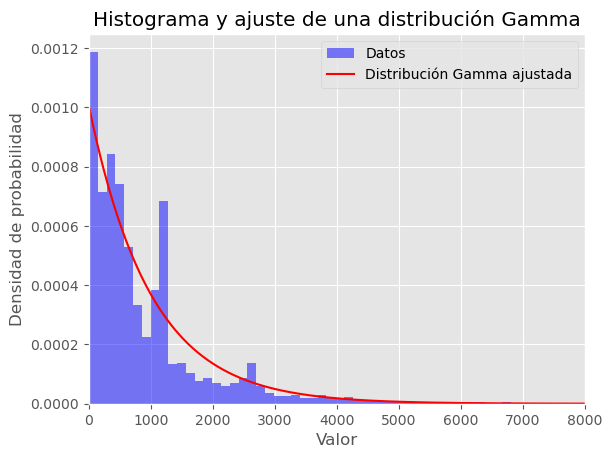

In [10]:
# import numpy as np
# from scipy.stats import gamma
# import matplotlib.pyplot as plt

# Supongamos que tienes un conjunto de datos llamado `data`
data = pg17trainclaim['claim_amount']

# 1. Visualiza el histograma de los datos
plt.hist(data, bins=1000, density=True, alpha=0.5, color='blue', label='Datos')

# 2. Ajusta una distribución gamma a los datos
# shape, loc, scale = gamma.fit(data)
shape = 1
loc = 0
scale = np.mean(pg17trainclaim['claim_amount'])/shape

# 3. Grafica la distribución gamma ajustada
x_plot = np.linspace(0, 20000, 1000)  # Define el rango de valores en el eje x
distribucion_ajustada = gamma(shape, loc=loc, scale=scale)
y_plot = distribucion_ajustada.pdf(x_plot)
plt.plot(x_plot, y_plot, 'r-', label='Distribución Gamma ajustada')

# Ajusta los límites del eje x
plt.xlim(0, 8000)

# Añade etiquetas y título al gráfico
plt.xlabel('Valor')
plt.ylabel('Densidad de probabilidad')
plt.title('Histograma y ajuste de una distribución Gamma')
plt.legend()

# Muestra el gráfico
plt.show()

In [11]:
# Supongamos que data es tu conjunto de datos
data = pg17trainclaim['claim_amount']

# Ajusta una distribución gamma a los datos
E = np.mean(pg17trainclaim['claim_amount'])
V = np.var(pg17trainclaim['claim_amount'])

shape = 1
loc = 0
scale = np.mean(pg17trainclaim['claim_amount'])/shape

# Realiza el test de Kolmogorov-Smirnov
resultado_ks = kstest(data, 'gamma', args=(shape, loc, scale))
print("Estadístico KS:", resultado_ks.statistic)
print("Valor p:", resultado_ks.pvalue)

Estadístico KS: 0.08215343753060966
Valor p: 3.38671157916525e-73


In [ ]:
shape, loc, scale

In [ ]:
# import numpy as np
# from scipy.stats import gamma
# import matplotlib.pyplot as plt

# Supongamos que tienes un conjunto de datos llamado `data`
data = pg17trainclaim['claim_amount']

# 1. Visualiza el histograma de los datos
plt.hist(data, bins=2000, density=True, alpha=0.5, color='blue', label='Datos')

# 2. Ajusta una distribución gamma a los datos
# shape, loc, scale = gamma.fit(data)

# E = np.mean(pg17trainclaim['claim_amount'])
# V = np.var(pg17trainclaim['claim_amount'])

# shape = E**2/V
# loc = 0
# scale = V/E

# shape = 1
# loc = 0
# scale = np.mean(pg17trainclaim['claim_amount'])/shape


scale = np.mean(pg17trainclaim['claim_amount'])
shape = 1
loc = 0

# 3. Grafica la distribución gamma ajustada
x_plot = np.linspace(0, 5000, 1000)  # Define el rango de valores en el eje x
distribucion_ajustada = gamma(shape, loc=loc, scale=scale)
y_plot = distribucion_ajustada.pdf(x)
plt.plot(x_plot, y_plot, 'r-', label='Distribución Gamma ajustada')

# Ajusta los límites del eje x
plt.xlim(0, 5000)
plt.ylim(0, 0.002)

# Añade etiquetas y título al gráfico
plt.xlabel('Valor')
plt.ylabel('Densidad de probabilidad')
plt.title('Histograma y ajuste de una distribución Gamma')
plt.legend()

# Muestra el gráfico
plt.show()

In [ ]:
# Supongamos que data es tu conjunto de datos
data = pg17trainclaim['claim_amount']

# Ajusta una distribución gamma a los datos
# E = np.mean(pg17trainclaim['claim_amount'])
# V = np.var(pg17trainclaim['claim_amount'])

# shape = E**2/V
# loc = 0
# scale = V/E

scale = np.mean(pg17trainclaim['claim_amount'])
shape = 1
loc = 0

# Realiza el test de Kolmogorov-Smirnov
resultado_ks = kstest(data, 'gamma', args=(shape, loc, scale))
print("Estadístico KS:", resultado_ks.statistic)
print("Valor p:", resultado_ks.pvalue)

In [ ]:
np.mean(pg17trainclaim['claim_amount'])

In [ ]:
# import numpy as np
# from scipy.stats import gamma
# import matplotlib.pyplot as plt

# Supongamos que tienes un conjunto de datos llamado `data`
data = pg17trainclaim['claim_amount']

# 1. Visualiza el histograma de los datos
plt.hist(data, bins=1000, density=True, alpha=0.5, color='blue', label='Datos')

# 2. Ajusta una distribución gamma a los datos
loc = 0
scale = np.mean(pg17trainclaim['claim_amount'])

# 3. Grafica la distribución gamma ajustada
x_plot = np.linspace(0, 20000, 1000)  # Define el rango de valores en el eje x
distribucion_ajustada = expon(loc=loc, scale=scale)
y_plot = distribucion_ajustada.pdf(x)
plt.plot(x_plot, y_plot, 'r-', label='Distribución Exponencial ajustada')

# Ajusta los límites del eje x
plt.xlim(0, 20000)

# Añade etiquetas y título al gráfico
plt.xlabel('Valor')
plt.ylabel('Densidad de probabilidad')
plt.title('Histograma y ajuste de una distribución Exponencial')
plt.legend()

# Muestra el gráfico
plt.show()

In [ ]:
# Supongamos que data es tu conjunto de datos
data = pg17trainclaim['claim_amount']

# Ajusta una distribución eponencial a los datos
loc = 0
scale = np.mean(pg17trainclaim['claim_amount'])

# Realiza el test de Kolmogorov-Smirnov
resultado_ks = kstest(data, 'expon', args=(loc, scale))
print("Estadístico KS:", resultado_ks.statistic)
print("Valor p:", resultado_ks.pvalue)

In [ ]:
# import numpy as np
# from scipy.stats import gamma
# import matplotlib.pyplot as plt

# Supongamos que tienes un conjunto de datos llamado `data`
data = y[y['mean_claim_amount'] > 0]['mean_claim_amount']

# 1. Visualiza el histograma de los datos
plt.hist(data, bins=2000, density=True, alpha=0.5, color='blue', label='Datos')

# 2. Ajusta una distribución gamma a los datos
# shape, loc, scale = gamma.fit(data)

shape = 1
scale = np.mean(data)*2
loc = 0

# 3. Grafica la distribución gamma ajustada
x_plot = np.linspace(0, 5000, 1000)  # Define el rango de valores en el eje x
distribucion_ajustada = gamma(shape, loc=loc, scale=scale)
y_plot = distribucion_ajustada.pdf(x_plot)
plt.plot(x_plot, y_plot, 'r-', label='Distribución Gamma ajustada')

# Ajusta los límites del eje x
plt.xlim(0, 5000)
plt.ylim(0, 0.002)

# Añade etiquetas y título al gráfico
plt.xlabel('Valor')
plt.ylabel('Densidad de probabilidad')
plt.title('Histograma y ajuste de una distribución Gamma')
plt.legend()

# Muestra el gráfico
plt.show()

In [ ]:
y[y['mean_claim_amount'] > 0]

In [ ]:
pg17trainclaim.sort_values('claim_amount').head(20)

In [ ]:
pg17trainclaim.sort_values('claim_amount', ascending=False).head(20)

In [ ]:
distribucion_ajustada.mean()

In [ ]:
np.mean(pg17trainclaim['claim_amount'])

In [ ]:
np.mean(data)

(4.1. Ajuste de una GLM Gamma)

In [12]:
# # Aplicamos una GLM Gamma

# modelo_glm_Gamma = sm.GLM(y_train[y_train['mean_claim_amount'] > 0]['mean_claim_amount'], sm.add_constant(X_train[y_train['mean_claim_amount'] > 0]), family=sm.families.Gamma(sm.families.links.Log()))
# resultado_modelo_glm_Gamma = modelo_glm_Gamma.fit()
# y_pred_glm_Gamma_train = resultado_modelo_glm_Gamma.predict(sm.add_constant(X_train))
# y_pred_glm_Gamma_test = resultado_modelo_glm_Gamma.predict(sm.add_constant(X_test))

In [16]:
# # Error con la media
# mse_glm_Gamma_train_med = mean_squared_error(y_train[y_train['mean_claim_amount'] > 0]['mean_claim_amount'], np.full(len(y_train[y_train['mean_claim_amount'] > 0]), np.mean(y_train[y_train['mean_claim_amount'] > 0]['mean_claim_amount'])))
# mse_glm_Gamma_train_med

5312217.692038235

In [17]:
# # Error de train con GLM
# mse_glm_Gamma_train_pred = mean_squared_error(y_train[y_train['mean_claim_amount'] > 0]['mean_claim_amount'], y_pred_glm_Gamma_train[y_train['mean_claim_amount'] > 0])
# mse_glm_Gamma_train_pred

5243585.69480062

In [18]:
# # Error de test con GLM
# mse_glm_Gamma_test_pred = mean_squared_error(y_test[y_test['mean_claim_amount'] > 0]['mean_claim_amount'], y_pred_glm_Gamma_test[y_test['mean_claim_amount'] > 0])
# mse_glm_Gamma_test_pred

9987554.07299845

In [19]:
# Error de todos los claims contrastando con media
mean_squared_error(y_train['mean_claim_amount'], np.full(len(y_train), np.mean(y_train[y_train['mean_claim_amount'] > 0]['mean_claim_amount'])))

1495439.1698999775

In [20]:
# Error de todos los claims con GLM train
mean_squared_error(y_train['mean_claim_amount'], y_pred_glm_Gamma_train)

1442407.4896482504

In [21]:
# Error de todos los claims con GLM test
mean_squared_error(y_test['mean_claim_amount'], y_pred_glm_Gamma_test)

1975099.0886092465

In [22]:
# Error de los claims > 0 contrastando con media
mean_squared_error(y_train[y_train['mean_claim_amount'] > 0]['mean_claim_amount'], np.full(len(y_train[y_train['mean_claim_amount'] > 0]), np.mean(y_train[y_train['mean_claim_amount'] > 0]['mean_claim_amount'])))

5312217.692038235

In [23]:
# Error de los claims > 0 con GLM train
mean_squared_error(y_train[y_train['mean_claim_amount'] > 0]['mean_claim_amount'], y_pred_glm_Gamma_train[y_train['mean_claim_amount'] > 0])

5243585.69480062

In [24]:
# Error de los claims > 0 contrastando con media en test
mean_squared_error(y_test[y_test['mean_claim_amount'] > 0]['mean_claim_amount'], np.full(len(y_test[y_test['mean_claim_amount'] > 0]), np.mean(y_train[y_train['mean_claim_amount'] > 0]['mean_claim_amount'])))

9966247.103387933

In [25]:
# Error de los claims > 0 con GLM test
mean_squared_error(y_test[y_test['mean_claim_amount'] > 0]['mean_claim_amount'], y_pred_glm_Gamma_test[y_test['mean_claim_amount'] > 0])

9987554.07299845

In [ ]:
# Supongamos que tienes un conjunto de datos llamado `data`
data = y_train[y_train['mean_claim_amount'] > 0]['mean_claim_amount']

# 1. Visualiza el histograma de los datos
plt.hist(data, bins=2000, density=True, alpha=0.5, color='blue', label='Datos')

# Ajusta los límites del eje x
plt.xlim(0, 5000)
plt.ylim(0, 0.002)

In [ ]:
# Supongamos que tienes un conjunto de datos llamado `data`
data = y_test[y_test['mean_claim_amount'] > 0]['mean_claim_amount']

# 1. Visualiza el histograma de los datos
plt.hist(data, bins=2000, density=True, alpha=0.5, color='blue', label='Datos')

# Ajusta los límites del eje x
plt.xlim(0, 5000)
plt.ylim(0, 0.002)

In [ ]:
# Supongamos que tienes un conjunto de datos llamado `data`
data = y_train[y_train['mean_claim_amount'] > 0]['mean_claim_amount']

# 1. Visualiza el histograma de los datos
plt.hist(data, bins=2000, density=True, alpha=0.5, color='blue', label='Datos train')

# Supongamos que tienes un conjunto de datos llamado `data`
data = y_test[y_test['mean_claim_amount'] > 0]['mean_claim_amount']

# 1. Visualiza el histograma de los datos
plt.hist(data, bins=2000, density=True, alpha=0.5, color='green', label='Datos test')

# Ajusta los límites del eje x
plt.xlim(0, 5000)
plt.ylim(0, 0.002)

## GLM Gamma particionado

In [ ]:
# import numpy as np
# from scipy.stats import gamma
# import matplotlib.pyplot as plt

# Supongamos que tienes un conjunto de datos llamado `data`
data =  y[y['mean_claim_amount']>0]['mean_claim_amount']

# 1. Visualiza el histograma de los datos
plt.hist(data, bins=2000, density=True, alpha=0.5, color='blue', label='Datos')

# 2. Ajusta una distribución gamma a los datos
# shape, loc, scale = gamma.fit(data)

E = np.mean(data)
V = np.var(data)

shape = (E**2)/V
loc = 0
scale = V/E

# 3. Grafica la distribución gamma ajustada
x_plot = np.linspace(0, 5000, 1000)  # Define el rango de valores en el eje x
distribucion_ajustada = gamma(shape, loc=loc, scale=scale)
y_plot = distribucion_ajustada.pdf(x_plot)
plt.plot(x_plot, y_plot, 'r-', label='Distribución Gamma ajustada')

# Ajusta los límites del eje x
plt.xlim(0, 5000)
plt.ylim(0, 0.002)

# Añade etiquetas y título al gráfico
plt.xlabel('Valor')
plt.ylabel('Densidad de probabilidad')
plt.title('Histograma y ajuste de una distribución Gamma')
plt.legend()

# Muestra el gráfico
plt.show()

# Realiza el test de Kolmogorov-Smirnov
resultado_ks = kstest(data, 'gamma', args=(shape, loc, scale))
print("Estadístico KS:", resultado_ks.statistic)
print("Valor p:", resultado_ks.pvalue)

In [ ]:
# import numpy as np
# from scipy.stats import gamma
# import matplotlib.pyplot as plt

corte = 20

# Supongamos que tienes un conjunto de datos llamado `data`
data =  y[(y['mean_claim_amount']>0) & (y['mean_claim_amount']<=corte)]['mean_claim_amount']

# 1. Visualiza el histograma de los datos
plt.hist(data, bins=20, density=True, alpha=0.5, color='blue', label='Datos')

# 2. Ajusta una distribución gamma a los datos
shape, loc, scale = gamma.fit(data)

# E = np.mean(data)
# V = np.var(data)

# shape = (E**2)/V
# loc = 0
# scale = V/E

# 3. Grafica la distribución gamma ajustada
x_plot = np.linspace(0, 5000, 1000)  # Define el rango de valores en el eje x
# x_plot = np.linspace(0, corte, 1000)  # Define el rango de valores en el eje x
distribucion_ajustada = gamma(shape, loc=loc, scale=scale)
y_plot = distribucion_ajustada.pdf(x_plot)
plt.plot(x_plot, y_plot, 'r-', label='Distribución Gamma ajustada')

# Ajusta los límites del eje x
plt.xlim(0, corte)
# plt.ylim(0, 0.002)

# Añade etiquetas y título al gráfico
plt.xlabel('Valor')
plt.ylabel('Densidad de probabilidad')
plt.title('Histograma y ajuste de una distribución Gamma')
plt.legend()

# Muestra el gráfico
plt.show()

# Realiza el test de Kolmogorov-Smirnov
resultado_ks = kstest(data, 'gamma', args=(shape, loc, scale))
print("Estadístico KS:", resultado_ks.statistic)
print("Valor p:", resultado_ks.pvalue)

In [ ]:
# import numpy as np
# from scipy.stats import gamma
# import matplotlib.pyplot as plt

corte_bajo = 20
corte_alto = 200

# Supongamos que tienes un conjunto de datos llamado `data`
data =  y[(y['mean_claim_amount']>corte_bajo) & (y['mean_claim_amount']<=corte_alto)]['mean_claim_amount']

# 1. Visualiza el histograma de los datos
plt.hist(data, bins=50, density=True, alpha=0.5, color='blue', label='Datos')

# 2. Ajusta una distribución gamma a los datos
# shape, loc, scale = gamma.fit(data)

E = np.mean(data)
V = np.var(data)

shape = (E**2)/V
loc = 0
scale = V/E

# 3. Grafica la distribución gamma ajustada
x_plot = np.linspace(corte_bajo, corte_alto, 1000)  # Define el rango de valores en el eje x
# x_plot = np.linspace(0, corte, 1000)  # Define el rango de valores en el eje x
distribucion_ajustada = gamma(shape, loc=loc, scale=scale)
y_plot = distribucion_ajustada.pdf(x_plot)
plt.plot(x_plot, y_plot, 'r-', label='Distribución Gamma ajustada')

# Ajusta los límites del eje x
plt.xlim(corte_bajo, corte_alto)
# plt.ylim(0, 0.002)

# Añade etiquetas y título al gráfico
plt.xlabel('Valor')
plt.ylabel('Densidad de probabilidad')
plt.title('Histograma y ajuste de una distribución Gamma')
plt.legend()

# Muestra el gráfico
plt.show()

# Realiza el test de Kolmogorov-Smirnov
resultado_ks = kstest(data, 'gamma', args=(shape, loc, scale))
print("Estadístico KS:", resultado_ks.statistic)
print("Valor p:", resultado_ks.pvalue)

## 4.0. Ajuste e interpretabilidad de una regresión lineal

### 4.0.1. Ajustes de una regresión lineal

In [4]:
# Tomamos los conjuntos de datos pertinentes para la estimación de E[X]|p

X_train_severity = X_train[y_train['mean_claim_amount'] > 0]
y_train_severity = y_train[y_train['mean_claim_amount'] > 0]['mean_claim_amount']
X_test_severity = X_test[y_test['mean_claim_amount'] > 0]
y_test_severity = y_test[y_test['mean_claim_amount'] > 0]['mean_claim_amount']

In [5]:
# Crear y ajustar el modelo
modelo_LR_severity = sm.OLS(y_train_severity, sm.add_constant(X_train_severity)).fit()

# Realizar predicciones
y_pred_LR_severity_train = modelo_LR_severity.predict(sm.add_constant(X_train_severity))
y_pred_LR_severity_test = modelo_LR_severity.predict(sm.add_constant(X_test_severity))

# Evaluar el modelo
mse_LR_severity_train_pred = mean_squared_error(y_train_severity, y_pred_LR_severity_train)
mse_LR_severity_test_pred = mean_squared_error(y_test_severity, y_pred_LR_severity_test)
print(f"mse_LR_severity_train_pred: {mse_LR_severity_train_pred}")
print(f"mse_LR_severity_test_pred: {mse_LR_severity_test_pred}")

mse_LR_severity_train_pred: 5244909.7062882045
mse_LR_severity_test_pred: 9986597.879329171


In [6]:
sum_LR_severity_train_pred = sum(y_pred_LR_severity_train)
sum_LR_severity_train_pred

9014545.629167601

In [7]:
sum_LR_severity_test_pred = sum(y_pred_LR_severity_test)
sum_LR_severity_test_pred

2247904.695241223

### 4.0.2. Interpretabilidad directa de una regresión lineal

In [8]:
LR_severity_explainer_low = Kernel_SHAP_shap_values(modelo_LR_severity.predict, sm.add_constant(X_train_severity), 1000)

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [9]:
X_train_severity_mean = np.insert(X_train_severity.mean().values, 0, 1)
X_train_severity_mean

array([1.00000000e+00, 5.43348978e-01, 1.06846575e+01, 2.40507319e+00,
       5.38982009e+01, 1.65346966e+01, 3.18222148e+01, 9.82601408e+00,
       7.26550453e+00, 1.69919365e+03, 9.84025031e+01, 9.14817298e+00,
       6.53592580e+00, 1.75426528e+02, 1.99168964e+04, 1.18747525e+03,
       3.27142698e+00, 7.76623086e-01, 6.77170634e-02, 1.36328081e-01,
       1.93317689e-02, 2.89194323e-01, 3.21488434e-01, 2.97239915e-02,
       3.59593251e-01, 9.71058219e-01, 2.89417812e-02, 2.01139792e-03,
       9.26360487e-02, 2.49078109e-01, 6.56274444e-01, 4.05743659e-01,
       5.94256341e-01, 2.19577606e-01, 1.38451224e-01, 6.41859426e-01,
       3.56911387e-01, 1.22918762e-03, 8.41434797e-02, 9.15856520e-01,
       1.21801319e-02, 4.13454017e-03, 2.71426975e-01, 1.59570902e-01,
       9.10716281e-02, 4.14347972e-01, 4.72678512e-02])

In [10]:
general_atrib_LR_severity = atrib_global_LR(modelo_LR_severity,X_train_severity_mean)
order_general_atrib_LR_severity = get_order_list(general_atrib_LR_severity)

In [ ]:
t_Kendall_local_shap_LR_severity = []
t_Kendall_local_global_LR_severity = []
mse_local_shap_LR_severity = []
mse_local_global_LR_severity = []
sign_local_shap_LR_severity = []
sign_local_global_LR_severity = []
compare_LR_severity_results = []

n_sample = 2000
i = 0
print(i, "|", i*100/n_sample, "%,", datetime.now().time())

for X_interpret_severity in X_test_severity[0:n_sample].iloc:
    
    X_interpret_severity_i = np.insert(np.array(X_interpret_severity), 0, 1)
    atrib = atrib_local_LR(modelo_LR_severity, X_interpret_severity_i, X_train_severity_mean)
    orden = get_order_list(atrib)

    LR_severity_shap_values = LR_severity_explainer_low.shap_values(np.array(X_interpret_severity_i))

    # Comparación de resultados de interpretabilidad de atribución local directa contra KernelSHAP

    LR_severity_shap_values_feat = atrib.copy()
    LR_severity_shap_values_feat[0:len(LR_severity_shap_values_feat)] = LR_severity_shap_values
    order_shap = get_order_list(LR_severity_shap_values_feat)
    
    compare_LR_severity_results_i = pd.DataFrame({'LR local attribution': atrib, 'LR local attribution order': orden, 'SHAP values': LR_severity_shap_values_feat, 'SHAP values order': order_shap, 'LR general attribution': general_atrib_LR_severity, 'LR general attribution order': order_general_atrib_LR_severity})
    compare_LR_severity_results.append(compare_LR_severity_results_i)

    t_Kendall_local_shap_i, _ = kendalltau(abs(compare_LR_severity_results_i['LR local attribution']), abs(compare_LR_severity_results_i['SHAP values']))
    t_Kendall_global_shap_i, _ = kendalltau(abs(compare_LR_severity_results_i['LR local attribution']), abs(compare_LR_severity_results_i['LR general attribution']))
    
    t_Kendall_local_shap_LR_severity.append(t_Kendall_local_shap_i)
    t_Kendall_local_global_LR_severity.append(t_Kendall_global_shap_i)
    mse_local_shap_LR_severity.append(mean_squared_error(compare_LR_severity_results_i['LR local attribution'], compare_LR_severity_results_i['SHAP values']))
    mse_local_global_LR_severity.append(mean_squared_error(compare_LR_severity_results_i['LR local attribution'], compare_LR_severity_results_i['LR general attribution']))
    sign_local_shap_LR_severity.append(sum(np.sign(compare_LR_severity_results_i['LR local attribution']) == np.sign(compare_LR_severity_results_i['SHAP values']))/len(compare_LR_severity_results_i))
    sign_local_global_LR_severity.append(sum(np.sign(compare_LR_severity_results_i['LR local attribution']) == np.sign(compare_LR_severity_results_i['LR general attribution']))/len(compare_LR_severity_results_i))
    
    i = i+1
    if i/10 == int(i/10):
        print(i, "|", i*100/n_sample, "%,", datetime.now().time())

%store t_Kendall_local_shap_LR_severity
%store t_Kendall_local_global_LR_severity
%store mse_local_shap_LR_severity
%store mse_local_global_LR_severity
%store sign_local_shap_LR_severity
%store sign_local_global_LR_severity
%store compare_LR_severity_results

compare_LR_severity_indexes = pd.DataFrame({'Tau Kendall: local vs SHAP': np.array(t_Kendall_local_shap_LR_severity), 'Tau Kendall: local vs global': np.array(t_Kendall_local_global_LR_severity), 'MSE: local vs SHAP': np.array(mse_local_shap_LR_severity), 'MSE: local vs global': np.array(mse_local_global_LR_severity), 'Sign: local vs SHAP': np.array(sign_local_shap_LR_severity), 'Sign: local vs global': np.array(sign_local_global_LR_severity)})
%store compare_LR_severity_indexes
compare_LR_severity_indexes

0 | 0.0 %, 13:26:04.013701
10 | 0.5 %, 13:27:39.819208
20 | 1.0 %, 13:29:16.684511
30 | 1.5 %, 13:30:56.331530
40 | 2.0 %, 13:32:29.317293
50 | 2.5 %, 13:34:06.830669
60 | 3.0 %, 13:35:40.877615
70 | 3.5 %, 13:37:13.706211
80 | 4.0 %, 13:38:46.349407
90 | 4.5 %, 13:40:18.499445
100 | 5.0 %, 13:41:50.585207
110 | 5.5 %, 13:43:23.886395
120 | 6.0 %, 13:45:02.011048
130 | 6.5 %, 13:46:38.579275
140 | 7.0 %, 13:48:15.352584
150 | 7.5 %, 13:49:48.459074
160 | 8.0 %, 13:51:21.578948
170 | 8.5 %, 13:52:53.551568
180 | 9.0 %, 13:54:29.081049
190 | 9.5 %, 13:56:03.855735
200 | 10.0 %, 13:57:41.353376
210 | 10.5 %, 13:59:16.661657


In [24]:
# mean_squared_error(compare_LR_severity_results_i['LR local attribution'],compare_LR_severity_results_i['SHAP values'])
# mse_local_shap_LR_severity
print(compare_LR_severity_results_i['LR local attribution'])
print(compare_LR_severity_results_i['SHAP values'])
print(compare_LR_severity_results_i['LR general attribution'])

const                        -0.000000
pol_bonus                   -20.280603
pol_duration                -48.513583
pol_sit_duration              5.378898
drv_age1                    269.891617
drv_age2                   -211.982317
drv_age_lic1                -19.860561
drv_age_lic2                120.520546
vh_age                      -63.924343
vh_cyl                       48.046833
vh_din                        8.154687
vh_sale_begin                67.889450
vh_sale_end                 -68.071585
vh_speed                     14.861899
vh_value                      0.011828
vh_weight                    -5.026003
pol_insee_density            33.384386
pol_coverage_Maxi            15.654885
pol_coverage_Median1          9.468407
pol_coverage_Median2         34.189559
pol_coverage_Mini            -3.798467
pol_pay_freq_Biannual         6.326723
pol_pay_freq_Monthly          4.357349
pol_pay_freq_Quarterly        0.279634
pol_pay_freq_Yearly         -50.721678
pol_payd_No              

## 4.1. Ajuste de una GLM Gamma

In [5]:
modelo_glm_Gamma = sm.GLM(y_train_severity, sm.add_constant(X_train_severity), family=sm.families.Gamma(sm.families.links.Log()))
resultado_modelo_glm_Gamma = modelo_glm_Gamma.fit()
y_pred_glm_Gamma_train = resultado_modelo_glm_Gamma.predict(sm.add_constant(X_train_severity))
y_pred_glm_Gamma_test = resultado_modelo_glm_Gamma.predict(sm.add_constant(X_test_severity))

In [34]:
# Error con la media
mse_glm_Gamma_train_med = mean_squared_error(y_train[y_train['mean_claim_amount'] > 0]['mean_claim_amount'], np.full(len(y_train[y_train['mean_claim_amount'] > 0]), np.mean(y_train[y_train['mean_claim_amount'] > 0]['mean_claim_amount'])))
mse_glm_Gamma_train_med

C:\Users\Usuario\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


ValueError: could not broadcast input array from shape (46,) into shape (8949,)

In [7]:
# Error de train con GLM
mse_glm_Gamma_train_pred = mean_squared_error(y_train[y_train['mean_claim_amount'] > 0]['mean_claim_amount'], y_pred_glm_Gamma_train[y_train['mean_claim_amount'] > 0])
mse_glm_Gamma_train_pred

5243585.69480062

In [8]:
# Error de test con GLM
mse_glm_Gamma_test_pred = mean_squared_error(y_test[y_test['mean_claim_amount'] > 0]['mean_claim_amount'], y_pred_glm_Gamma_test[y_test['mean_claim_amount'] > 0])
mse_glm_Gamma_test_pred

9987554.07299845

## 4.3. Ajuste de un árbol de decisión CART

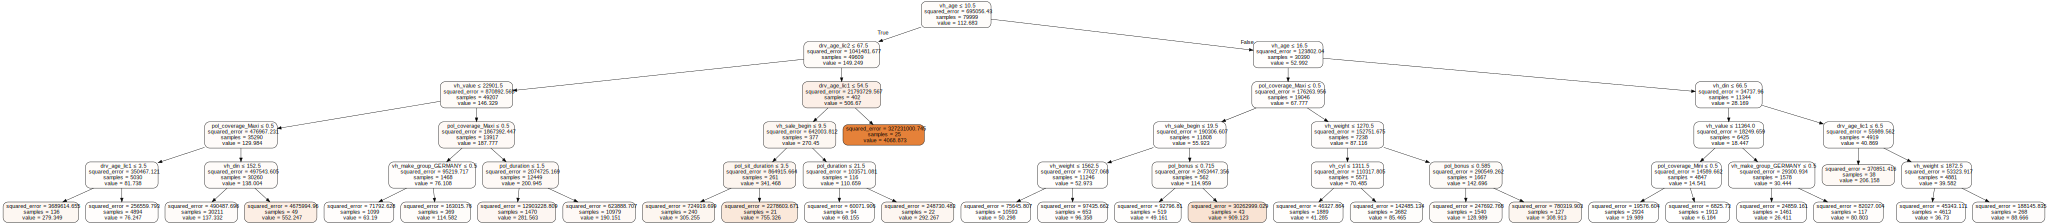

In [32]:
# Crear un modelo de árbol de decisión
tree_model_severity = DecisionTreeRegressor(max_depth=5, min_samples_leaf=20)  # Puedes ajustar max_depth según sea necesario

# Entrenar el modelo
tree_model_severity.fit(X_train, y_train['mean_claim_amount'])

# Realizar predicciones en el conjunto de entrenamiento
y_pred_CART_severity_train = tree_model_severity.predict(X_train)
y_pred_CART_severity_test = tree_model_severity.predict(X_test)

# Visualizar el árbol usando plot_tree
# plt.figure(figsize=(12, 8))

# Exportar el árbol a un archivo DOT
dot_data_severity = export_graphviz(tree_model_severity, out_file=None, 
                           feature_names=X_train.columns,  
                           filled=True, rounded=True,  
                           special_characters=True)  

# Usar graphviz para visualizar el archivo DOT
graph_severity = graphviz.Source(dot_data_severity)  
graph_severity.render("decision_tree")  # Esto guarda el árbol como un archivo PDF llamado 'decision_tree.pdf'

# Mostrar el gráfico directamente en el notebook (si estás usando Jupyter Notebook)
graph_severity

In [33]:
mse_CART_severity_train_pred = mean_squared_error(y_train['mean_claim_amount'], y_pred_CART_severity_train)
mse_CART_severity_train_pred

685909.017584587

In [34]:
mse_CART_severity_test_pred = mean_squared_error(y_test['mean_claim_amount'], y_pred_CART_severity_test)
mse_CART_severity_test_pred

1212303.6523477728

Ahora entrenando sólo con siniestros con importe no nulo

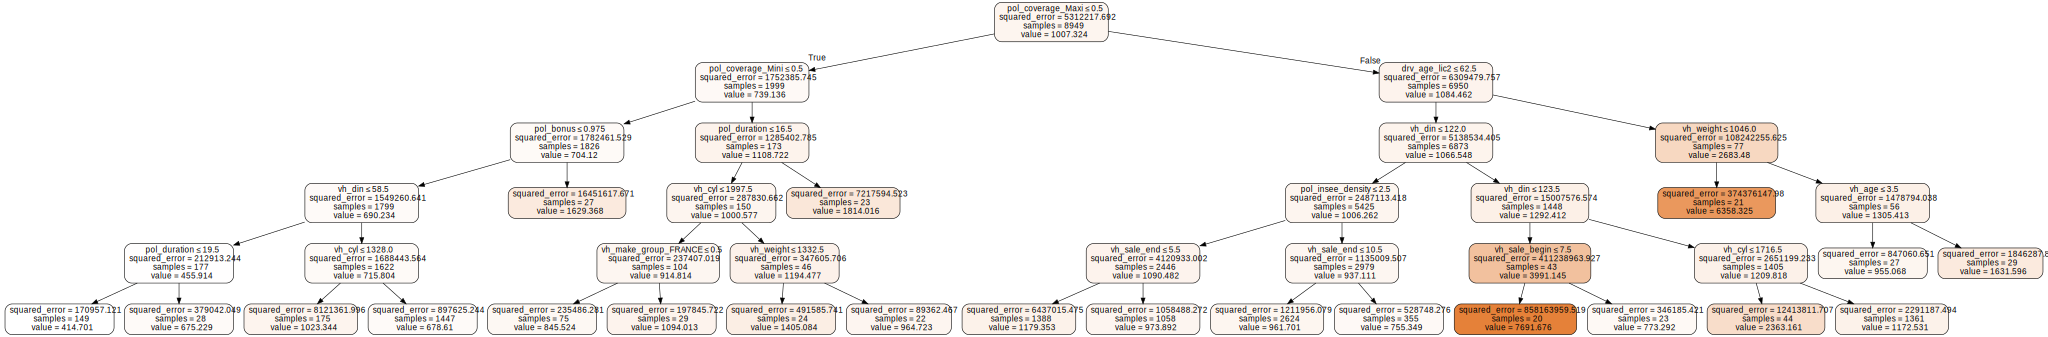

In [9]:
# Crear un modelo de árbol de decisión
tree_model_severity_0 = DecisionTreeRegressor(max_depth=5, min_samples_leaf=20)  # Puedes ajustar max_depth según sea necesario

# Entrenar el modelo
tree_model_severity_0.fit(X_train_severity, y_train_severity)

# Realizar predicciones en el conjunto de entrenamiento
y_pred_CART_severity_train_0 = tree_model_severity_0.predict(X_train_severity)
y_pred_CART_severity_test_0 = tree_model_severity_0.predict(X_test_severity)

# Visualizar el árbol usando plot_tree
# plt.figure(figsize=(12, 8))

# Exportar el árbol a un archivo DOT
dot_data_severity_0 = export_graphviz(tree_model_severity_0, out_file=None, 
                           feature_names=X_train_severity.columns,  
                           filled=True, rounded=True,  
                           special_characters=True)  

# Usar graphviz para visualizar el archivo DOT
graph_severity_0 = graphviz.Source(dot_data_severity_0)  
graph_severity_0.render("decision_tree_0")  # Esto guarda el árbol como un archivo PDF llamado 'decision_tree.pdf'

# Mostrar el gráfico directamente en el notebook (si estás usando Jupyter Notebook)
graph_severity_0

In [10]:
mse_CART_severity_train_pred_0 = mean_squared_error(y_train_severity, y_pred_CART_severity_train_0)
mse_CART_severity_train_pred_0

5095536.165827541

In [11]:
mse_CART_severity_test_pred_0 = mean_squared_error(y_test_severity, y_pred_CART_severity_test_0)
mse_CART_severity_test_pred_0

10106253.477639122

## 4.4. Ajuste de un Random Forest

In [35]:
random_forest_severity = RandomForestRegressor(random_state=0, min_samples_leaf=20).fit(X_train, y_train['mean_claim_amount'])

y_pred_RF_severity_train = random_forest_severity.predict(X_train)
y_pred_RF_severity_test = random_forest_severity.predict(X_test)

In [37]:
mse_RF_severity_train_pred = mean_squared_error(y_train['mean_claim_amount'], y_pred_RF_severity_train)
mse_RF_severity_train_pred

636584.233504534

In [38]:
mse_RF_severity_test_pred = mean_squared_error(y_test['mean_claim_amount'], y_pred_RF_severity_test)
mse_RF_severity_test_pred

1214914.597251928

Ahora entrenando sólo con siniestros con importe no nulo

In [12]:
random_forest_severity_0 = RandomForestRegressor(random_state=0, min_samples_leaf=20).fit(X_train_severity, y_train_severity)

y_pred_RF_severity_train_0 = random_forest_severity_0.predict(X_train_severity)
y_pred_RF_severity_test_0 = random_forest_severity_0.predict(X_test_severity)

In [13]:
mse_RF_severity_train_pred_0 = mean_squared_error(y_train_severity, y_pred_RF_severity_train_0)
mse_RF_severity_train_pred_0

4822665.775968177

In [14]:
mse_RF_severity_test_pred_0 = mean_squared_error(y_test_severity, y_pred_RF_severity_test_0)
mse_RF_severity_test_pred_0

10040625.311301975

## 4.6. Ajuste de un XGBoosting

In [41]:
# Crear la matriz DMatrix
dtrain_severity = xgb.DMatrix(X_train, label=y_train['mean_claim_amount'])
dtest_severity = xgb.DMatrix(X_test, label=y_test['mean_claim_amount'])

params = {
    'objective': 'count:poisson',
    'eval_metric': 'poisson-nloglik',  # Métrica de evaluación para Poisson
    'max_depth': 5,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}
num_rounds = 1000  # Número de rondas de entrenamiento (puedes ajustar según sea necesario)
# model = xgb.train(params, dtrain, num_rounds, evals=[(dtest, 'eval')], early_stopping_rounds=10)
xgboosting_severity = xgb.train(params, dtrain_severity, num_rounds, evals=[(dtest_severity, 'eval')], early_stopping_rounds=10)

y_pred_XGB_severity_train = xgboosting_severity.predict(dtrain_severity)
y_pred_XGB_severity_test = xgboosting_severity.predict(dtest_severity)

[0]	eval-poisson-nloglik:1160149529807197489332224.00000
[1]	eval-poisson-nloglik:1103943957939267357900800.00000
[2]	eval-poisson-nloglik:1050461370492436485242880.00000
[3]	eval-poisson-nloglik:999569830012021425307648.00000
[4]	eval-poisson-nloglik:951143812169208107630592.00000
[5]	eval-poisson-nloglik:905063845473081647693824.00000
[6]	eval-poisson-nloglik:861216367155438271070208.00000
[7]	eval-poisson-nloglik:819493146710033009999872.00000
[8]	eval-poisson-nloglik:779791285892579703390208.00000
[9]	eval-poisson-nloglik:742012858432780807176192.00000
[10]	eval-poisson-nloglik:706064693861545280536576.00000
[11]	eval-poisson-nloglik:671858089280612434182144.00000
[12]	eval-poisson-nloglik:639308665247363854499840.00000
[13]	eval-poisson-nloglik:608336221659635327696896.00000
[14]	eval-poisson-nloglik:578864233352558574305280.00000
[15]	eval-poisson-nloglik:550820102300140381929472.00000
[16]	eval-poisson-nloglik:524134581154510301822976.00000
[17]	eval-poisson-nloglik:498741917361

[298]	eval-poisson-nloglik:434074202664861696.00000
[299]	eval-poisson-nloglik:413044668394110976.00000
[300]	eval-poisson-nloglik:393033969085448192.00000
[301]	eval-poisson-nloglik:373992695435100160.00000
[302]	eval-poisson-nloglik:355873946400194560.00000
[303]	eval-poisson-nloglik:338632985601376256.00000
[304]	eval-poisson-nloglik:322227275682545664.00000
[305]	eval-poisson-nloglik:306616375231643648.00000
[306]	eval-poisson-nloglik:291761766981959680.00000
[307]	eval-poisson-nloglik:277626840632262656.00000
[308]	eval-poisson-nloglik:264176703868239872.00000
[309]	eval-poisson-nloglik:251378165182627840.00000
[310]	eval-poisson-nloglik:239199699515473920.00000
[311]	eval-poisson-nloglik:227611224915836928.00000
[312]	eval-poisson-nloglik:216584171261263872.00000
[313]	eval-poisson-nloglik:206091359998705664.00000
[314]	eval-poisson-nloglik:196106883885432832.00000
[315]	eval-poisson-nloglik:186606124168904704.00000
[316]	eval-poisson-nloglik:177565647507554304.00000
[317]	eval-p

[461]	eval-poisson-nloglik:132480430505564.56250
[462]	eval-poisson-nloglik:126062172307036.56250
[463]	eval-poisson-nloglik:119954854641244.56250
[464]	eval-poisson-nloglik:114143419956828.56250
[465]	eval-poisson-nloglik:108613532122716.56250
[466]	eval-poisson-nloglik:103351551262300.56250
[467]	eval-poisson-nloglik:98344491810396.56250
[468]	eval-poisson-nloglik:93580014124636.56250
[469]	eval-poisson-nloglik:89046357376604.56250
[470]	eval-poisson-nloglik:84732339551836.56250
[471]	eval-poisson-nloglik:80627323895388.56250
[472]	eval-poisson-nloglik:76721336352348.56250
[473]	eval-poisson-nloglik:73004570639964.56250
[474]	eval-poisson-nloglik:69467858009902.28125
[475]	eval-poisson-nloglik:66102486892334.28125
[476]	eval-poisson-nloglik:62900148371246.28125
[477]	eval-poisson-nloglik:59852948766510.28125
[478]	eval-poisson-nloglik:56953371885358.28125
[479]	eval-poisson-nloglik:54194262245166.28125
[480]	eval-poisson-nloglik:51568820879150.28125
[481]	eval-poisson-nloglik:4907056

[637]	eval-poisson-nloglik:21208338562.96960
[638]	eval-poisson-nloglik:20180899975.16800
[639]	eval-poisson-nloglik:19203235980.80000
[640]	eval-poisson-nloglik:18272934035.25120
[641]	eval-poisson-nloglik:17387700377.29280
[642]	eval-poisson-nloglik:16545353884.46720
[643]	eval-poisson-nloglik:15743813792.97280
[644]	eval-poisson-nloglik:14981103782.80960
[645]	eval-poisson-nloglik:14255343787.98080
[646]	eval-poisson-nloglik:13564742833.10080
[647]	eval-poisson-nloglik:12907599029.96480
[648]	eval-poisson-nloglik:12282289337.80480
[649]	eval-poisson-nloglik:11687273662.51520
[650]	eval-poisson-nloglik:11121083588.40320
[651]	eval-poisson-nloglik:10582321354.13760
[652]	eval-poisson-nloglik:10069660879.56480
[653]	eval-poisson-nloglik:9581835476.68480
[654]	eval-poisson-nloglik:9117642969.13920
[655]	eval-poisson-nloglik:8675938525.03040
[656]	eval-poisson-nloglik:8255632622.79680
[657]	eval-poisson-nloglik:7855687923.37920
[658]	eval-poisson-nloglik:7475118840.72960
[659]	eval-poiss

[829]	eval-poisson-nloglik:1533152.71149
[830]	eval-poisson-nloglik:1458847.10031
[831]	eval-poisson-nloglik:1388141.64499
[832]	eval-poisson-nloglik:1320861.80976
[833]	eval-poisson-nloglik:1256841.46933
[834]	eval-poisson-nloglik:1195923.40513
[835]	eval-poisson-nloglik:1137956.78838
[836]	eval-poisson-nloglik:1082798.33026
[837]	eval-poisson-nloglik:1030313.12238
[838]	eval-poisson-nloglik:980370.51218
[839]	eval-poisson-nloglik:932847.50022
[840]	eval-poisson-nloglik:887626.92289
[841]	eval-poisson-nloglik:844597.78838
[842]	eval-poisson-nloglik:803653.23673
[843]	eval-poisson-nloglik:764692.27531
[844]	eval-poisson-nloglik:727619.46034
[845]	eval-poisson-nloglik:692342.75785
[846]	eval-poisson-nloglik:658775.11963
[847]	eval-poisson-nloglik:626834.28996
[848]	eval-poisson-nloglik:596441.04694
[849]	eval-poisson-nloglik:567520.61684
[850]	eval-poisson-nloglik:540001.76725
[851]	eval-poisson-nloglik:513816.08657
[852]	eval-poisson-nloglik:488899.20780
[853]	eval-poisson-nloglik:4651

In [42]:
mse_XGB_severity_train_pred = mean_squared_error(y_train['mean_claim_amount'], y_pred_XGB_severity_train)
mse_XGB_severity_train_pred

663390.5524569431

In [43]:
mse_XGB_severity_test_pred = mean_squared_error(y_test['mean_claim_amount'], y_pred_XGB_severity_test)
mse_XGB_severity_test_pred

1318542.902132804

Ahora entrenando sólo con siniestros con importe no nulo

In [17]:
# Crear la matriz DMatrix
dtrain_severity_0 = xgb.DMatrix(X_train_severity, label=y_train_severity)
dtest_severity_0 = xgb.DMatrix(X_test_severity, label=y_test_severity)

params_0 = {
    'objective': 'reg:gamma',
    'eval_metric': 'rmse',
    'learning_rate': 0.1,
    'max_depth': 6,
    'lambda': 1
}
num_rounds = 1000  # Número de rondas de entrenamiento (puedes ajustar según sea necesario)
# model = xgb.train(params, dtrain, num_rounds, evals=[(dtest, 'eval')], early_stopping_rounds=10)
xgboosting_severity_0 = xgb.train(params_0, dtrain_severity_0, num_rounds, evals=[(dtest_severity_0, 'eval')], early_stopping_rounds=10)

y_pred_XGB_severity_train_0 = xgboosting_severity_0.predict(dtrain_severity_0)
y_pred_XGB_severity_test_0 = xgboosting_severity_0.predict(dtest_severity_0)

[0]	eval-rmse:3310.49804
[1]	eval-rmse:3310.40345
[2]	eval-rmse:3310.29892
[3]	eval-rmse:3310.18339
[4]	eval-rmse:3310.05607
[5]	eval-rmse:3309.91540
[6]	eval-rmse:3309.76025
[7]	eval-rmse:3309.58911
[8]	eval-rmse:3309.39988
[9]	eval-rmse:3309.19158
[10]	eval-rmse:3308.96169
[11]	eval-rmse:3308.70821
[12]	eval-rmse:3308.42890
[13]	eval-rmse:3308.12083
[14]	eval-rmse:3307.78164
[15]	eval-rmse:3307.40788
[16]	eval-rmse:3306.99673
[17]	eval-rmse:3306.54381
[18]	eval-rmse:3306.04599
[19]	eval-rmse:3305.49848
[20]	eval-rmse:3304.89674
[21]	eval-rmse:3304.23613
[22]	eval-rmse:3303.51124
[23]	eval-rmse:3302.71653
[24]	eval-rmse:3301.84536
[25]	eval-rmse:3300.89154
[26]	eval-rmse:3299.84843
[27]	eval-rmse:3298.70841
[28]	eval-rmse:3297.46401
[29]	eval-rmse:3296.10741
[30]	eval-rmse:3294.63115
[31]	eval-rmse:3293.02705
[32]	eval-rmse:3291.28641
[33]	eval-rmse:3289.40154
[34]	eval-rmse:3287.36381
[35]	eval-rmse:3285.16520
[36]	eval-rmse:3282.79547
[37]	eval-rmse:3280.25164
[38]	eval-rmse:3277.52

In [19]:
mse_XGB_severity_train_pred_0 = mean_squared_error(y_train_severity, y_pred_XGB_severity_train_0)
mse_XGB_severity_train_pred_0

4767464.963170247

In [20]:
mse_XGB_severity_test_pred_0 = mean_squared_error(y_test_severity, y_pred_XGB_severity_test_0)
mse_XGB_severity_test_pred_0

10039323.134647977

## 4.7. Ajuste de una Red Neuronal

In [45]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(46, 100)  # 46 entradas, 50 neuronas en la capa oculta
        self.fc2 = nn.Linear(100, 50)   # 50 entradas desde la capa oculta, 1 salida
        self.fc3 = nn.Linear(50, 20)   # 50 entradas desde la capa oculta, 1 salida
        self.fc4 = nn.Linear(20, 1)   # 50 entradas desde la capa oculta, 1 salida
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

nerual_network_severity_model = SimpleNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(nerual_network_severity_model.parameters(), lr=0.001)

In [47]:
# Convertir los datos a tensores de PyTorch
X_train_severity_tensor = torch.tensor(np.array(X_train).astype(np.float32))
y_train_severity_tensor = torch.tensor(np.array(y_train['mean_claim_amount']).astype(np.float32))

# Crear un DataLoader
tensordataset_severity = TensorDataset(X_train_severity_tensor, y_train_severity_tensor)
tensordataloader_severity = DataLoader(tensordataset_severity, batch_size=32, shuffle=True)

In [49]:
num_epochs = 2000

for epoch in range(num_epochs):
    print(datetime.now().time())
    for inputs, targets in tensordataloader_severity:
        optimizer.zero_grad()  # Limpiar los gradientes
        
        outputs = nerual_network_severity_model(inputs)  # Forward pass
        loss = criterion(outputs, targets)  # Calcular la pérdida
        
        loss.backward()  # Backward pass
        optimizer.step()  # Actualizar los parámetros
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

00:03:21.575473
Epoch 1/2000, Loss: 186665.0625
00:03:29.306845
Epoch 2/2000, Loss: 521386.75
00:03:36.730496
Epoch 3/2000, Loss: 83509.796875
00:03:44.931153
Epoch 4/2000, Loss: 73316.8359375
00:03:53.801233
Epoch 5/2000, Loss: 224391.53125
00:04:03.799171
Epoch 6/2000, Loss: 486569.5
00:04:15.592907
Epoch 7/2000, Loss: 54633.9921875
00:04:26.927286
Epoch 8/2000, Loss: 10814.861328125
00:04:35.614369
Epoch 9/2000, Loss: 51000.19140625
00:04:44.278025
Epoch 10/2000, Loss: 64982.55859375
00:04:52.721211
Epoch 11/2000, Loss: 760838.1875
00:05:01.109866
Epoch 12/2000, Loss: 58500.18359375
00:05:09.937227
Epoch 13/2000, Loss: 50569.265625
00:05:18.706831
Epoch 14/2000, Loss: 15267.4794921875
00:05:27.453800
Epoch 15/2000, Loss: 356270.625
00:05:36.171646
Epoch 16/2000, Loss: 596725.125
00:05:44.829450
Epoch 17/2000, Loss: 141786.84375
00:05:53.360806
Epoch 18/2000, Loss: 370672.4375
00:06:02.294407
Epoch 19/2000, Loss: 447511.15625
00:06:10.699875
Epoch 20/2000, Loss: 120877.4140625
00:06:

Epoch 162/2000, Loss: 56931.11328125
00:28:06.515750
Epoch 163/2000, Loss: 83096.0
00:28:15.733302
Epoch 164/2000, Loss: 16511.591796875
00:28:24.707336
Epoch 165/2000, Loss: 100500.9140625
00:28:33.786738
Epoch 166/2000, Loss: 185026.09375
00:28:42.845761
Epoch 167/2000, Loss: 1193202.125
00:28:51.815500
Epoch 168/2000, Loss: 213263.453125
00:29:01.163062
Epoch 169/2000, Loss: 227383.09375
00:29:09.973558
Epoch 170/2000, Loss: 54724.9296875
00:29:19.366573
Epoch 171/2000, Loss: 151433.671875
00:29:28.447519
Epoch 172/2000, Loss: 55014.2265625
00:29:37.560714
Epoch 173/2000, Loss: 414086.40625
00:29:46.595851
Epoch 174/2000, Loss: 42286.04296875
00:29:55.512144
Epoch 175/2000, Loss: 411462.21875
00:30:04.919514
Epoch 176/2000, Loss: 35253.1640625
00:30:13.849435
Epoch 177/2000, Loss: 41443.0625
00:30:23.147883
Epoch 178/2000, Loss: 148010.75
00:30:31.995658
Epoch 179/2000, Loss: 757107.0
00:30:40.359342
Epoch 180/2000, Loss: 277742.125
00:30:50.011811
Epoch 181/2000, Loss: 1916193.125


Epoch 322/2000, Loss: 37566.734375
00:52:41.966468
Epoch 323/2000, Loss: 12612.6337890625
00:52:51.124094
Epoch 324/2000, Loss: 22299.72265625
00:53:00.657610
Epoch 325/2000, Loss: 894489.4375
00:53:09.776994
Epoch 326/2000, Loss: 84546.296875
00:53:19.150267
Epoch 327/2000, Loss: 18000.546875
00:53:28.316552
Epoch 328/2000, Loss: 13835.236328125
00:53:37.443897
Epoch 329/2000, Loss: 58432.640625
00:53:46.744423
Epoch 330/2000, Loss: 604599.5
00:53:55.648748
Epoch 331/2000, Loss: 11417.033203125
00:54:05.161992
Epoch 332/2000, Loss: 170584.171875
00:54:14.304702
Epoch 333/2000, Loss: 223839.203125
00:54:23.803098
Epoch 334/2000, Loss: 10251.908203125
00:54:32.858185
Epoch 335/2000, Loss: 335379.78125
00:54:42.067882
Epoch 336/2000, Loss: 101476.640625
00:54:51.332556
Epoch 337/2000, Loss: 14913.4296875
00:55:00.245111
Epoch 338/2000, Loss: 313892.90625
00:55:09.709914
Epoch 339/2000, Loss: 30005.08203125
00:55:18.780694
Epoch 340/2000, Loss: 12295.4072265625
00:55:28.219760
Epoch 341/2

Epoch 481/2000, Loss: 40304.59765625
01:17:17.278886
Epoch 482/2000, Loss: 53817.453125
01:17:26.173186
Epoch 483/2000, Loss: 1087057.75
01:17:35.640959
Epoch 484/2000, Loss: 235905.265625
01:17:44.900308
Epoch 485/2000, Loss: 59953.45703125
01:17:54.228540
Epoch 486/2000, Loss: 111946.90625
01:18:03.511617
Epoch 487/2000, Loss: 90969.9453125
01:18:12.548027
Epoch 488/2000, Loss: 21873.232421875
01:18:21.888511
Epoch 489/2000, Loss: 174912.671875
01:18:31.037423
Epoch 490/2000, Loss: 19459.837890625
01:18:40.392062
Epoch 491/2000, Loss: 19841.15625
01:18:49.441531
Epoch 492/2000, Loss: 456856.9375
01:18:58.569176
Epoch 493/2000, Loss: 204092.859375
01:19:07.939889
Epoch 494/2000, Loss: 77809.2890625
01:19:16.896980
Epoch 495/2000, Loss: 99437.7734375
01:19:26.207996
Epoch 496/2000, Loss: 132658.5625
01:19:35.091144
Epoch 497/2000, Loss: 504547.0625
01:19:44.603144
Epoch 498/2000, Loss: 257244.171875
01:19:53.674401
Epoch 499/2000, Loss: 105309.6328125
01:20:02.739654
Epoch 500/2000, Lo

Epoch 640/2000, Loss: 224514.046875
01:41:50.853276
Epoch 641/2000, Loss: 592361.1875
01:41:59.862791
Epoch 642/2000, Loss: 145450.328125
01:42:12.944023
Epoch 643/2000, Loss: 229365.015625
01:42:22.977006
Epoch 644/2000, Loss: 71650.5078125
01:42:32.094985
Epoch 645/2000, Loss: 140138.078125
01:42:41.374074
Epoch 646/2000, Loss: 31491.0859375
01:42:50.505444
Epoch 647/2000, Loss: 18283.87890625
01:42:59.545567
Epoch 648/2000, Loss: 539708.3125
01:43:09.044636
Epoch 649/2000, Loss: 11813.6669921875
01:43:18.249049
Epoch 650/2000, Loss: 162817.703125
01:43:27.812479
Epoch 651/2000, Loss: 18302.203125
01:43:36.920284
Epoch 652/2000, Loss: 97897.6171875
01:43:46.300404
Epoch 653/2000, Loss: 14751.1962890625
01:43:55.542274
Epoch 654/2000, Loss: 11583.0439453125
01:44:04.616196
Epoch 655/2000, Loss: 71935.75
01:44:14.141101
Epoch 656/2000, Loss: 20760.482421875
01:44:23.312677
Epoch 657/2000, Loss: 87412.3046875
01:44:32.798901
Epoch 658/2000, Loss: 191385.5
01:44:41.885227
Epoch 659/2000,

Epoch 799/2000, Loss: 14830.09375
02:06:26.523950
Epoch 800/2000, Loss: 1124776.0
02:06:35.787882
Epoch 801/2000, Loss: 15026.853515625
02:06:44.728831
Epoch 802/2000, Loss: 491513.28125
02:06:54.070694
Epoch 803/2000, Loss: 1102391.625
02:07:03.137702
Epoch 804/2000, Loss: 14967.3916015625
02:07:12.510372
Epoch 805/2000, Loss: 52751.375
02:07:21.549277
Epoch 806/2000, Loss: 64286.96875
02:07:30.550001
Epoch 807/2000, Loss: 22866.671875
02:07:39.703039
Epoch 808/2000, Loss: 65731.390625
02:07:48.709503
Epoch 809/2000, Loss: 1330680.0
02:07:57.961038
Epoch 810/2000, Loss: 186941.375
02:08:06.888878
Epoch 811/2000, Loss: 90180.1015625
02:08:16.355747
Epoch 812/2000, Loss: 155427.59375
02:08:25.349013
Epoch 813/2000, Loss: 217956.5625
02:08:34.515142
Epoch 814/2000, Loss: 167712.328125
02:08:43.576796
Epoch 815/2000, Loss: 41224.0234375
02:08:52.441445
Epoch 816/2000, Loss: 42767.2421875
02:09:01.816320
Epoch 817/2000, Loss: 485337.40625
02:09:10.730269
Epoch 818/2000, Loss: 35346.8398437

Epoch 959/2000, Loss: 230252.65625
02:30:54.857298
Epoch 960/2000, Loss: 10365.998046875
02:31:03.778895
Epoch 961/2000, Loss: 308089.09375
02:31:13.136975
Epoch 962/2000, Loss: 52658.1328125
02:31:22.237561
Epoch 963/2000, Loss: 80729.7890625
02:31:31.259919
Epoch 964/2000, Loss: 971179.5
02:31:40.679500
Epoch 965/2000, Loss: 113157.84375
02:31:49.823933
Epoch 966/2000, Loss: 134855.96875
02:31:59.212038
Epoch 967/2000, Loss: 79721.546875
02:32:08.171250
Epoch 968/2000, Loss: 34929.265625
02:32:17.416892
Epoch 969/2000, Loss: 982905.5625
02:32:26.544476
Epoch 970/2000, Loss: 28046.775390625
02:32:35.488982
Epoch 971/2000, Loss: 21888.654296875
02:32:44.828841
Epoch 972/2000, Loss: 134879.03125
02:32:53.846185
Epoch 973/2000, Loss: 1360122.125
02:33:03.312169
Epoch 974/2000, Loss: 53562.33984375
02:33:12.441694
Epoch 975/2000, Loss: 50370.87890625
02:33:21.630173
Epoch 976/2000, Loss: 285858.34375
02:33:30.683308
Epoch 977/2000, Loss: 370727.1875
02:33:39.723838
Epoch 978/2000, Loss: 2

Epoch 1117/2000, Loss: 800815.375
02:55:10.606255
Epoch 1118/2000, Loss: 390220.78125
02:55:19.767599
Epoch 1119/2000, Loss: 24406.953125
02:55:28.941730
Epoch 1120/2000, Loss: 27432.294921875
02:55:37.959865
Epoch 1121/2000, Loss: 27203.7578125
02:55:46.990888
Epoch 1122/2000, Loss: 20206.189453125
02:55:56.350603
Epoch 1123/2000, Loss: 510226.09375
02:56:05.423454
Epoch 1124/2000, Loss: 15007.5087890625
02:56:14.841867
Epoch 1125/2000, Loss: 832045.0625
02:56:23.909711
Epoch 1126/2000, Loss: 53861.0703125
02:56:33.192703
Epoch 1127/2000, Loss: 13055.4580078125
02:56:42.274014
Epoch 1128/2000, Loss: 54205.6015625
02:56:51.248585
Epoch 1129/2000, Loss: 186165.78125
02:57:00.514275
Epoch 1130/2000, Loss: 52495.44921875
02:57:09.427014
Epoch 1131/2000, Loss: 55755.42578125
02:57:18.685014
Epoch 1132/2000, Loss: 72103.390625
02:57:27.626449
Epoch 1133/2000, Loss: 60256.80078125
02:57:36.929487
Epoch 1134/2000, Loss: 231399.296875
02:57:46.054006
Epoch 1135/2000, Loss: 56372.9140625
02:57:

Epoch 1274/2000, Loss: 31976.37890625
03:19:17.260018
Epoch 1275/2000, Loss: 302561.15625
03:19:26.683952
Epoch 1276/2000, Loss: 30478.408203125
03:19:35.672394
Epoch 1277/2000, Loss: 83850.921875
03:19:45.013984
Epoch 1278/2000, Loss: 18413.197265625
03:19:54.002453
Epoch 1279/2000, Loss: 147248.671875
03:20:02.970236
Epoch 1280/2000, Loss: 39022.84375
03:20:12.300830
Epoch 1281/2000, Loss: 39014.375
03:20:21.292653
Epoch 1282/2000, Loss: 13365.015625
03:20:30.697701
Epoch 1283/2000, Loss: 27234.818359375
03:20:39.620162
Epoch 1284/2000, Loss: 18682.04296875
03:20:48.993911
Epoch 1285/2000, Loss: 732988.625
03:20:58.002703
Epoch 1286/2000, Loss: 748744.1875
03:21:07.084999
Epoch 1287/2000, Loss: 205363.21875
03:21:16.506189
Epoch 1288/2000, Loss: 102309.5625
03:21:25.537701
Epoch 1289/2000, Loss: 285931.34375
03:21:34.930238
Epoch 1290/2000, Loss: 47197.5
03:21:43.907675
Epoch 1291/2000, Loss: 17976.552734375
03:21:53.174251
Epoch 1292/2000, Loss: 26619.00390625
03:22:02.287671
Epoch 

Epoch 1431/2000, Loss: 53716.296875
07:27:05.269574
Epoch 1432/2000, Loss: 60271.58203125
07:27:14.560036
Epoch 1433/2000, Loss: 18601.689453125
07:27:23.669428
Epoch 1434/2000, Loss: 249640.484375
07:27:33.079668
Epoch 1435/2000, Loss: 250512.78125
07:27:42.051349
Epoch 1436/2000, Loss: 54847.23046875
07:27:51.398338
Epoch 1437/2000, Loss: 69845.0703125
07:28:00.586102
Epoch 1438/2000, Loss: 60328.46875
07:28:09.834303
Epoch 1439/2000, Loss: 75050.515625
07:28:19.258139
Epoch 1440/2000, Loss: 51694.4921875
07:28:28.176493
Epoch 1441/2000, Loss: 885724.875
07:28:37.740482
Epoch 1442/2000, Loss: 11566.28515625
07:28:46.637181
Epoch 1443/2000, Loss: 45831.19140625
07:28:55.917005
Epoch 1444/2000, Loss: 19779.08203125
07:29:04.984407
Epoch 1445/2000, Loss: 32244.06640625
07:29:14.142014
Epoch 1446/2000, Loss: 306098.6875
07:29:24.097609
Epoch 1447/2000, Loss: 20511.1640625
07:29:36.629764
Epoch 1448/2000, Loss: 122840.8359375
07:29:45.849751
Epoch 1449/2000, Loss: 25662.859375
07:29:55.03

Epoch 1588/2000, Loss: 16207.298828125
07:51:16.588802
Epoch 1589/2000, Loss: 262642.6875
07:51:25.546683
Epoch 1590/2000, Loss: 163963.78125
07:51:34.997178
Epoch 1591/2000, Loss: 215073.796875
07:51:44.053864
Epoch 1592/2000, Loss: 14136.5166015625
07:51:53.418175
Epoch 1593/2000, Loss: 150812.625
07:52:02.544567
Epoch 1594/2000, Loss: 27492.9296875
07:52:11.566772
Epoch 1595/2000, Loss: 38901.6015625
07:52:20.952726
Epoch 1596/2000, Loss: 81858.921875
07:52:29.973363
Epoch 1597/2000, Loss: 127637.7421875
07:52:39.393302
Epoch 1598/2000, Loss: 69607.3984375
07:52:48.477125
Epoch 1599/2000, Loss: 56297.5703125
07:52:57.713495
Epoch 1600/2000, Loss: 14304.01953125
07:53:06.970045
Epoch 1601/2000, Loss: 410787.625
07:53:16.050045
Epoch 1602/2000, Loss: 82654.140625
07:53:25.567165
Epoch 1603/2000, Loss: 63971.6953125
07:53:34.650357
Epoch 1604/2000, Loss: 315740.15625
07:53:44.069307
Epoch 1605/2000, Loss: 10929.1025390625
07:53:53.182337
Epoch 1606/2000, Loss: 61410.61328125
07:54:02.3

Epoch 1745/2000, Loss: 621389.375
08:15:45.120954
Epoch 1746/2000, Loss: 11218.0185546875
08:15:54.319773
Epoch 1747/2000, Loss: 514526.34375
08:16:03.527256
Epoch 1748/2000, Loss: 263640.84375
08:16:12.616295
Epoch 1749/2000, Loss: 120277.0234375
08:16:22.054544
Epoch 1750/2000, Loss: 12663.1416015625
08:16:31.011984
Epoch 1751/2000, Loss: 18639.748046875
08:16:40.450655
Epoch 1752/2000, Loss: 355859.125
08:16:49.640306
Epoch 1753/2000, Loss: 23690.103515625
08:16:58.803896
Epoch 1754/2000, Loss: 171860.625
08:17:08.226690
Epoch 1755/2000, Loss: 29854.818359375
08:17:17.308693
Epoch 1756/2000, Loss: 121471.8203125
08:17:26.680927
Epoch 1757/2000, Loss: 403106.625
08:17:35.684887
Epoch 1758/2000, Loss: 412459.28125
08:17:45.309576
Epoch 1759/2000, Loss: 841563.75
08:17:54.469275
Epoch 1760/2000, Loss: 65338.1328125
08:18:03.731974
Epoch 1761/2000, Loss: 112934.453125
08:18:13.235670
Epoch 1762/2000, Loss: 98928.328125
08:18:22.195112
Epoch 1763/2000, Loss: 13758.9912109375
08:18:31.549

Epoch 1902/2000, Loss: 67328.7265625
08:40:02.619892
Epoch 1903/2000, Loss: 75654.5234375
08:40:11.814473
Epoch 1904/2000, Loss: 12246.021484375
08:40:21.325567
Epoch 1905/2000, Loss: 395069.59375
08:40:30.478343
Epoch 1906/2000, Loss: 351730.21875
08:40:40.038977
Epoch 1907/2000, Loss: 60154.74609375
08:40:49.061220
Epoch 1908/2000, Loss: 292220.75
08:40:58.201750
Epoch 1909/2000, Loss: 221895.71875
08:41:07.360788
Epoch 1910/2000, Loss: 69736.3984375
08:41:16.306638
Epoch 1911/2000, Loss: 52585.84375
08:41:25.678490
Epoch 1912/2000, Loss: 376561.4375
08:41:34.649023
Epoch 1913/2000, Loss: 230573.359375
08:41:44.056055
Epoch 1914/2000, Loss: 225079.203125
08:41:53.049755
Epoch 1915/2000, Loss: 52573.1640625
08:42:02.309614
Epoch 1916/2000, Loss: 445701.59375
08:42:11.544598
Epoch 1917/2000, Loss: 2504408.0
08:42:20.676574
Epoch 1918/2000, Loss: 74047.3515625
08:42:30.053224
Epoch 1919/2000, Loss: 215124.078125
08:42:39.174861
Epoch 1920/2000, Loss: 73871.703125
08:42:48.584091
Epoch 1

In [51]:
# Convertir los datos a tensores de PyTorch
X_test_severity_tensor = torch.tensor(np.array(X_test).astype(np.float32))
y_test_severity_tensor = torch.tensor(np.array(y_test['mean_claim_amount']).astype(np.float32))

# Evaluar el modelo
nerual_network_severity_model.eval()  # Poner el modelo en modo de evaluación
with torch.no_grad():  # No necesitamos calcular los gradientes en el modo de evaluación
    predictions_severity_test = nerual_network_severity_model(X_test_severity_tensor)
    test_loss_severity = criterion(predictions_severity_test, y_test_severity_tensor)

print(f'Test Loss: {test_loss_severity.item()}')

C:\Users\Usuario\anaconda3\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([20000])) that is different to the input size (torch.Size([20000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Loss: 1211829.5


In [52]:
mean_squared_error(predictions_severity_test, y_test['mean_claim_amount'])

1211829.7641750895

In [53]:
# Evaluar el modelo
nerual_network_severity_model.eval()  # Poner el modelo en modo de evaluación
with torch.no_grad():  # No necesitamos calcular los gradientes en el modo de evaluación
    predictions_severity_train = nerual_network_severity_model(X_train_severity_tensor)
    train_loss_severity = criterion(predictions_severity_train, y_train_severity_tensor)

print(f'Test Loss: {train_loss_severity.item()}')

C:\Users\Usuario\anaconda3\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([79999])) that is different to the input size (torch.Size([79999, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: [enforce fail at C:\b\abs_bao0hdcrdh\croot\pytorch_1675190257512\work\c10\core\impl\alloc_cpu.cpp:81] data. DefaultCPUAllocator: not enough memory: you tried to allocate 25599360004 bytes.

In [54]:
mean_squared_error(predictions_severity_train, y_train['mean_claim_amount'])

695058.4902634003

Ahora entrenando sólo con siniestros con importe no nulo

In [21]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(46, 100)  # 46 entradas, 50 neuronas en la capa oculta
        self.fc2 = nn.Linear(100, 50)   # 50 entradas desde la capa oculta, 1 salida
        self.fc3 = nn.Linear(50, 20)   # 50 entradas desde la capa oculta, 1 salida
        self.fc4 = nn.Linear(20, 1)   # 50 entradas desde la capa oculta, 1 salida
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

nerual_network_severity_model_0 = SimpleNN()
criterion_0 = nn.MSELoss()
optimizer_0 = optim.Adam(nerual_network_severity_model_0.parameters(), lr=0.001)

In [22]:
# Convertir los datos a tensores de PyTorch
X_train_severity_tensor_0 = torch.tensor(np.array(X_train_severity).astype(np.float32))
y_train_severity_tensor_0 = torch.tensor(np.array(y_train_severity).astype(np.float32))

# Crear un DataLoader
tensordataset_severity_0 = TensorDataset(X_train_severity_tensor_0, y_train_severity_tensor_0)
tensordataloader_severity_0 = DataLoader(tensordataset_severity_0, batch_size=32, shuffle=True)

In [28]:
num_epochs = 2000

for epoch in range(num_epochs):
    print(datetime.now().time())
    for inputs, targets in tensordataloader_severity_0:
        optimizer_0.zero_grad()  # Limpiar los gradientes
        
        outputs = nerual_network_severity_model_0(inputs)  # Forward pass
        loss = criterion_0(outputs, targets)  # Calcular la pérdida
        
        loss.backward()  # Backward pass
        optimizer_0.step()  # Actualizar los parámetros
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

09:09:31.172001


C:\Users\Usuario\anaconda3\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Usuario\anaconda3\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/2000, Loss: 604909.125
09:09:32.071966
Epoch 2/2000, Loss: 1142784.75
09:09:33.194139
Epoch 3/2000, Loss: 1087148.25
09:09:34.271609
Epoch 4/2000, Loss: 400460.125
09:09:35.322787
Epoch 5/2000, Loss: 4518684.0
09:09:36.323251
Epoch 6/2000, Loss: 508385.0625
09:09:37.471765
Epoch 7/2000, Loss: 625292.25
09:09:38.463075
Epoch 8/2000, Loss: 864476.3125
09:09:39.502063
Epoch 9/2000, Loss: 635358.0625
09:09:40.443678
Epoch 10/2000, Loss: 16776707.0
09:09:41.551913
Epoch 11/2000, Loss: 323185.96875
09:09:42.506221
Epoch 12/2000, Loss: 1431097.125
09:09:43.414290
Epoch 13/2000, Loss: 557151.0625
09:09:44.345324
Epoch 14/2000, Loss: 1561513.375
09:09:45.272999
Epoch 15/2000, Loss: 930440.75
09:09:46.524240
Epoch 16/2000, Loss: 378853.46875
09:09:47.692746
Epoch 17/2000, Loss: 1316551.375
09:09:48.624083
Epoch 18/2000, Loss: 694163.0625
09:09:49.536639
Epoch 19/2000, Loss: 1344885.375
09:09:50.441669
Epoch 20/2000, Loss: 1133188.25
09:09:51.373122
Epoch 21/2000, Loss: 401087.46875
09:09

Epoch 170/2000, Loss: 597451.125
09:12:21.478661
Epoch 171/2000, Loss: 945802.1875
09:12:22.390991
Epoch 172/2000, Loss: 802019.3125
09:12:23.294575
Epoch 173/2000, Loss: 2176220.0
09:12:24.236041
Epoch 174/2000, Loss: 2525018.75
09:12:25.163013
Epoch 175/2000, Loss: 429381.09375
09:12:26.256523
Epoch 176/2000, Loss: 587753.125
09:12:27.441717
Epoch 177/2000, Loss: 478197.34375
09:12:28.433154
Epoch 178/2000, Loss: 430341.9375
09:12:29.315992
Epoch 179/2000, Loss: 2303564.0
09:12:30.215550
Epoch 180/2000, Loss: 2753022.0
09:12:31.120901
Epoch 181/2000, Loss: 543362.75
09:12:32.010025
Epoch 182/2000, Loss: 954094.25
09:12:32.903577
Epoch 183/2000, Loss: 1821964.25
09:12:33.824740
Epoch 184/2000, Loss: 790684.8125
09:12:34.844386
Epoch 185/2000, Loss: 1123459.875
09:12:35.730027
Epoch 186/2000, Loss: 1508460.5
09:12:36.671984
Epoch 187/2000, Loss: 1407728.5
09:12:37.605925
Epoch 188/2000, Loss: 395804.125
09:12:38.503586
Epoch 189/2000, Loss: 579425.75
09:12:39.441878
Epoch 190/2000, Los

Epoch 337/2000, Loss: 952889.8125
09:15:25.799840
Epoch 338/2000, Loss: 2108302.5
09:15:27.824521
Epoch 339/2000, Loss: 661540.25
09:15:29.899872
Epoch 340/2000, Loss: 1003247.625
09:15:31.300283
Epoch 341/2000, Loss: 1055706.75
09:15:33.115995
Epoch 342/2000, Loss: 1125875.0
09:15:34.431191
Epoch 343/2000, Loss: 272915.375
09:15:35.779082
Epoch 344/2000, Loss: 648657.5625
09:15:37.062048
Epoch 345/2000, Loss: 1904403.5
09:15:38.331215
Epoch 346/2000, Loss: 1526282.25
09:15:39.374336
Epoch 347/2000, Loss: 1356263.625
09:15:40.539956
Epoch 348/2000, Loss: 997480.9375
09:15:41.739210
Epoch 349/2000, Loss: 1672856.125
09:15:42.910050
Epoch 350/2000, Loss: 295073.9375
09:15:44.219883
Epoch 351/2000, Loss: 1176772.875
09:15:45.522825
Epoch 352/2000, Loss: 1423641.5
09:15:46.900284
Epoch 353/2000, Loss: 973405.6875
09:15:48.212446
Epoch 354/2000, Loss: 6966857.0
09:15:49.220203
Epoch 355/2000, Loss: 565864.125
09:15:50.279855
Epoch 356/2000, Loss: 371319.96875
09:15:51.411873
Epoch 357/2000,

Epoch 504/2000, Loss: 521189.25
09:19:05.731419
Epoch 505/2000, Loss: 47540868.0
09:19:07.090123
Epoch 506/2000, Loss: 1897768.75
09:19:08.690967
Epoch 507/2000, Loss: 1058334.75
09:19:10.293972
Epoch 508/2000, Loss: 3929780.5
09:19:11.679946
Epoch 509/2000, Loss: 501169.5
09:19:12.761588
Epoch 510/2000, Loss: 1519501.625
09:19:13.804370
Epoch 511/2000, Loss: 1411189.75
09:19:14.850118
Epoch 512/2000, Loss: 507560.84375
09:19:15.939477
Epoch 513/2000, Loss: 1204614.625
09:19:17.103258
Epoch 514/2000, Loss: 812490.0625
09:19:18.424015
Epoch 515/2000, Loss: 922414.6875
09:19:19.763598
Epoch 516/2000, Loss: 564149.6875
09:19:21.124787
Epoch 517/2000, Loss: 1497106.25
09:19:22.284484
Epoch 518/2000, Loss: 733560.875
09:19:23.335053
Epoch 519/2000, Loss: 603509.125
09:19:24.495086
Epoch 520/2000, Loss: 411389.3125
09:19:25.771410
Epoch 521/2000, Loss: 714751.8125
09:19:27.023186
Epoch 522/2000, Loss: 771630.4375
09:19:28.546625
Epoch 523/2000, Loss: 1318342.875
09:19:29.881793
Epoch 524/200

Epoch 671/2000, Loss: 865841.1875
09:22:35.094008
Epoch 672/2000, Loss: 1281382.125
09:22:36.227495
Epoch 673/2000, Loss: 552842.875
09:22:37.482867
Epoch 674/2000, Loss: 529308.0
09:22:38.699986
Epoch 675/2000, Loss: 869868.625
09:22:39.776656
Epoch 676/2000, Loss: 972082.5625
09:22:41.099145
Epoch 677/2000, Loss: 1098116.375
09:22:42.441214
Epoch 678/2000, Loss: 821610.6875
09:22:43.844726
Epoch 679/2000, Loss: 366554.78125
09:22:45.159882
Epoch 680/2000, Loss: 409299.59375
09:22:46.225914
Epoch 681/2000, Loss: 378315.6875
09:22:47.290143
Epoch 682/2000, Loss: 412518.53125
09:22:48.345545
Epoch 683/2000, Loss: 485867.75
09:22:49.432318
Epoch 684/2000, Loss: 2507808.25
09:22:50.573691
Epoch 685/2000, Loss: 1406257.625
09:22:52.173620
Epoch 686/2000, Loss: 1994249.75
09:22:53.791603
Epoch 687/2000, Loss: 600560.5
09:22:55.270292
Epoch 688/2000, Loss: 396493.8125
09:22:56.386891
Epoch 689/2000, Loss: 1259377.625
09:22:57.470206
Epoch 690/2000, Loss: 824713.375
09:22:58.691234
Epoch 691/

Epoch 837/2000, Loss: 535171.875
09:26:19.101288
Epoch 838/2000, Loss: 2803561.75
09:26:20.281485
Epoch 839/2000, Loss: 306216.25
09:26:21.563402
Epoch 840/2000, Loss: 2079570.125
09:26:22.829841
Epoch 841/2000, Loss: 561449.0625
09:26:24.187684
Epoch 842/2000, Loss: 503613.8125
09:26:25.560184
Epoch 843/2000, Loss: 1191569.875
09:26:26.999142
Epoch 844/2000, Loss: 6782149.0
09:26:28.474184
Epoch 845/2000, Loss: 1647700.875
09:26:29.667296
Epoch 846/2000, Loss: 2390343.5
09:26:30.895078
Epoch 847/2000, Loss: 637126.375
09:26:32.061143
Epoch 848/2000, Loss: 2306233.5
09:26:33.225856
Epoch 849/2000, Loss: 502373.84375
09:26:34.694601
Epoch 850/2000, Loss: 460360.9375
09:26:36.213890
Epoch 851/2000, Loss: 1709866.375
09:26:37.947468
Epoch 852/2000, Loss: 2137603.25
09:26:39.193732
Epoch 853/2000, Loss: 1531858.75
09:26:40.435989
Epoch 854/2000, Loss: 1728457.75
09:26:41.634371
Epoch 855/2000, Loss: 1306099.0
09:26:42.845291
Epoch 856/2000, Loss: 341981.8125
09:26:44.097811
Epoch 857/2000,

Epoch 1004/2000, Loss: 1318005.0
09:30:03.021918
Epoch 1005/2000, Loss: 1144366.75
09:30:04.181504
Epoch 1006/2000, Loss: 1016056.8125
09:30:05.490067
Epoch 1007/2000, Loss: 1713987.875
09:30:07.078163
Epoch 1008/2000, Loss: 923235.3125
09:30:08.517005
Epoch 1009/2000, Loss: 48542916.0
09:30:09.956314
Epoch 1010/2000, Loss: 1110710.625
09:30:11.212623
Epoch 1011/2000, Loss: 602652.9375
09:30:12.389194
Epoch 1012/2000, Loss: 1967949.625
09:30:13.612499
Epoch 1013/2000, Loss: 770975.4375
09:30:14.809878
Epoch 1014/2000, Loss: 1031521.6875
09:30:16.052519
Epoch 1015/2000, Loss: 1813747.375
09:30:17.369155
Epoch 1016/2000, Loss: 1099710.125
09:30:18.774309
Epoch 1017/2000, Loss: 492399.46875
09:30:20.306006
Epoch 1018/2000, Loss: 1076883.75
09:30:21.671106
Epoch 1019/2000, Loss: 356605.78125
09:30:22.903838
Epoch 1020/2000, Loss: 650580.5625
09:30:24.155762
Epoch 1021/2000, Loss: 559680.875
09:30:25.332872
Epoch 1022/2000, Loss: 579381.5
09:30:26.565270
Epoch 1023/2000, Loss: 1516061.5
09:

Epoch 1167/2000, Loss: 3783953.0
09:33:01.044170
Epoch 1168/2000, Loss: 505272.125
09:33:02.627360
Epoch 1169/2000, Loss: 711384.0625
09:33:03.936911
Epoch 1170/2000, Loss: 2866994.0
09:33:05.078816
Epoch 1171/2000, Loss: 1791525.875
09:33:06.229310
Epoch 1172/2000, Loss: 2249548.75
09:33:07.346881
Epoch 1173/2000, Loss: 845306.6875
09:33:08.352645
Epoch 1174/2000, Loss: 2207240.25
09:33:09.352502
Epoch 1175/2000, Loss: 531083.0
09:33:10.367978
Epoch 1176/2000, Loss: 377693.96875
09:33:11.369417
Epoch 1177/2000, Loss: 919085.625
09:33:12.367402
Epoch 1178/2000, Loss: 3824185.0
09:33:13.337378
Epoch 1179/2000, Loss: 2241906.25
09:33:14.348269
Epoch 1180/2000, Loss: 1713930.875
09:33:15.364432
Epoch 1181/2000, Loss: 711221.8125
09:33:16.304773
Epoch 1182/2000, Loss: 2270128.25
09:33:17.203526
Epoch 1183/2000, Loss: 777928.0
09:33:18.167522
Epoch 1184/2000, Loss: 1719508.125
09:33:19.194757
Epoch 1185/2000, Loss: 542431.5625
09:33:20.211884
Epoch 1186/2000, Loss: 750046.0625
09:33:21.2285

Epoch 1330/2000, Loss: 605423.0625
09:35:51.102531
Epoch 1331/2000, Loss: 538924.9375
09:35:52.149917
Epoch 1332/2000, Loss: 1368600.625
09:35:53.152376
Epoch 1333/2000, Loss: 631583.1875
09:35:54.167762
Epoch 1334/2000, Loss: 1541594.25
09:35:55.184702
Epoch 1335/2000, Loss: 241835.125
09:35:56.155238
Epoch 1336/2000, Loss: 9336468.0
09:35:57.033386
Epoch 1337/2000, Loss: 919458.75
09:35:58.067345
Epoch 1338/2000, Loss: 415189.65625
09:35:59.114544
Epoch 1339/2000, Loss: 884182.4375
09:36:00.146191
Epoch 1340/2000, Loss: 639416.625
09:36:01.164288
Epoch 1341/2000, Loss: 670688.75
09:36:02.194767
Epoch 1342/2000, Loss: 820876.75
09:36:03.226978
Epoch 1343/2000, Loss: 390488.40625
09:36:04.274779
Epoch 1344/2000, Loss: 1088332.5
09:36:05.306576
Epoch 1345/2000, Loss: 7515740.5
09:36:06.354903
Epoch 1346/2000, Loss: 1037734.3125
09:36:07.371017
Epoch 1347/2000, Loss: 868589.4375
09:36:08.386789
Epoch 1348/2000, Loss: 632943.8125
09:36:09.450109
Epoch 1349/2000, Loss: 494730.96875
09:36:1

Epoch 1493/2000, Loss: 1223283.0
09:38:35.760034
Epoch 1494/2000, Loss: 616825.5
09:38:36.653316
Epoch 1495/2000, Loss: 901590.1875
09:38:37.593721
Epoch 1496/2000, Loss: 408410.3125
09:38:38.440349
Epoch 1497/2000, Loss: 1513807.375
09:38:39.487518
Epoch 1498/2000, Loss: 292512.96875
09:38:40.519803
Epoch 1499/2000, Loss: 582807.75
09:38:41.536739
Epoch 1500/2000, Loss: 986459.75
09:38:42.583999
Epoch 1501/2000, Loss: 713208.3125
09:38:43.630908
Epoch 1502/2000, Loss: 437366.90625
09:38:44.647074
Epoch 1503/2000, Loss: 987511.8125
09:38:45.678478
Epoch 1504/2000, Loss: 861594432.0
09:38:46.694563
Epoch 1505/2000, Loss: 482545.5625
09:38:47.804387
Epoch 1506/2000, Loss: 703178.0
09:38:48.789712
Epoch 1507/2000, Loss: 1398995.875
09:38:49.805226
Epoch 1508/2000, Loss: 934638.125
09:38:50.852839
Epoch 1509/2000, Loss: 2165384.25
09:38:51.836983
Epoch 1510/2000, Loss: 1172563.25
09:38:52.746318
Epoch 1511/2000, Loss: 1406176.625
09:38:53.672067
Epoch 1512/2000, Loss: 900070.875
09:38:54.6

Epoch 1656/2000, Loss: 1150930.125
09:41:19.567849
Epoch 1657/2000, Loss: 371105.625
09:41:20.598824
Epoch 1658/2000, Loss: 418029.875
09:41:21.646170
Epoch 1659/2000, Loss: 1199860.375
09:41:22.708511
Epoch 1660/2000, Loss: 355578.5625
09:41:23.677722
Epoch 1661/2000, Loss: 418698.75
09:41:24.741163
Epoch 1662/2000, Loss: 1008679.5
09:41:25.757666
Epoch 1663/2000, Loss: 768076.625
09:41:26.774437
Epoch 1664/2000, Loss: 841649.1875
09:41:27.774500
Epoch 1665/2000, Loss: 3299894.0
09:41:28.743459
Epoch 1666/2000, Loss: 564136.375
09:41:29.760540
Epoch 1667/2000, Loss: 461130.15625
09:41:30.793245
Epoch 1668/2000, Loss: 438060.84375
09:41:31.793591
Epoch 1669/2000, Loss: 390764.9375
09:41:32.731917
Epoch 1670/2000, Loss: 1065289.25
09:41:33.641417
Epoch 1671/2000, Loss: 1935678.125
09:41:34.502555
Epoch 1672/2000, Loss: 3609448.5
09:41:35.534041
Epoch 1673/2000, Loss: 456678.53125
09:41:36.565951
Epoch 1674/2000, Loss: 297774.46875
09:41:37.629501
Epoch 1675/2000, Loss: 727803.625
09:41:

Epoch 1820/2000, Loss: 1142917.5
09:44:04.700264
Epoch 1821/2000, Loss: 829520.5
09:44:05.762786
Epoch 1822/2000, Loss: 810301.25
09:44:06.748008
Epoch 1823/2000, Loss: 594394.125
09:44:07.779972
Epoch 1824/2000, Loss: 536988.3125
09:44:08.750349
Epoch 1825/2000, Loss: 485520.6875
09:44:09.735134
Epoch 1826/2000, Loss: 373524.03125
09:44:10.768192
Epoch 1827/2000, Loss: 4251677.5
09:44:11.802116
Epoch 1828/2000, Loss: 1455252.625
09:44:12.694630
Epoch 1829/2000, Loss: 935057.4375
09:44:13.665430
Epoch 1830/2000, Loss: 617127.8125
09:44:14.496817
Epoch 1831/2000, Loss: 1037534.75
09:44:15.559067
Epoch 1832/2000, Loss: 916578.625
09:44:16.621890
Epoch 1833/2000, Loss: 1282066.0
09:44:17.609298
Epoch 1834/2000, Loss: 804644.875
09:44:18.626054
Epoch 1835/2000, Loss: 624195.3125
09:44:19.642225
Epoch 1836/2000, Loss: 1546140.625
09:44:20.673645
Epoch 1837/2000, Loss: 696001.75
09:44:21.705414
Epoch 1838/2000, Loss: 355914.125
09:44:22.721936
Epoch 1839/2000, Loss: 1862311.875
09:44:23.7696

Epoch 1983/2000, Loss: 545873.625
09:46:49.177543
Epoch 1984/2000, Loss: 923117.375
09:46:50.146858
Epoch 1985/2000, Loss: 934529.1875
09:46:51.177755
Epoch 1986/2000, Loss: 717416.625
09:46:52.151734
Epoch 1987/2000, Loss: 512932.71875
09:46:53.028810
Epoch 1988/2000, Loss: 805332.0
09:46:53.955653
Epoch 1989/2000, Loss: 1934369.625
09:46:54.879863
Epoch 1990/2000, Loss: 1285074.375
09:46:55.911778
Epoch 1991/2000, Loss: 584395.875
09:46:56.959305
Epoch 1992/2000, Loss: 365294.5
09:46:57.959575
Epoch 1993/2000, Loss: 752526.6875
09:46:58.959759
Epoch 1994/2000, Loss: 1699608.25
09:46:59.991090
Epoch 1995/2000, Loss: 1234704.75
09:47:01.038951
Epoch 1996/2000, Loss: 806148.5625
09:47:02.023591
Epoch 1997/2000, Loss: 509516.625
09:47:03.055223
Epoch 1998/2000, Loss: 734187.625
09:47:04.071929
Epoch 1999/2000, Loss: 2525753.75
09:47:05.056613
Epoch 2000/2000, Loss: 623822.25


In [32]:
# Convertir los datos a tensores de PyTorch
X_test_severity_tensor_0 = torch.tensor(np.array(X_test_severity).astype(np.float32))
y_test_severity_tensor_0 = torch.tensor(np.array(y_test_severity).astype(np.float32))

# Evaluar el modelo
nerual_network_severity_model_0.eval()  # Poner el modelo en modo de evaluación
with torch.no_grad():  # No necesitamos calcular los gradientes en el modo de evaluación
    predictions_severity_test_0 = nerual_network_severity_model_0(X_test_severity_tensor_0)
    test_loss_severity_0 = criterion_0(predictions_severity_test_0, y_test_severity_tensor_0)

print(f'Test Loss: {test_loss_severity_0.item()}')

Test Loss: 9970356.0


C:\Users\Usuario\anaconda3\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([2233])) that is different to the input size (torch.Size([2233, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [33]:
mse_NN_severity_test_pred_0 = mean_squared_error(predictions_severity_test_0, y_test_severity)
mse_NN_severity_test_pred_0

9977969.150425533

In [31]:
%store nerual_network_severity_model_0

  (fc1): Linear(in_features=46, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=1, bias=True)
)
                        Proper storage of interactively declared classes (or instances
                        of those classes) is not possible! Only instances
                        of classes in real modules on file system can be %store'd.



In [ ]:
%store pg17trainpol
%store pg17trainclaim
%store y
%store X
%store X_train
%store X_test
%store y_train
%store y_test
%store DensidadPoblacion
%store pg17trainpoldens
%store vh_make_group_dic
%store pg17trainclaim_group
%store pg17trainpolclaims
%store pg17trainpolclaims_pre
%store pg17trainpolclaims_pre2
%store pg17trainpolclaims_dum
%store dist_y_train
%store dist_y_test
%store dist_y
%store modelo_glm_Poisson
%store resultado_modelo_glm_Poisson
%store y_pred_glm_Poisson_train
%store y_pred_glm_Poisson_test
%store modelo_glm_Gamma
%store resultado_modelo_glm_Gamma
%store y_pred_glm_Gamma_train
%store y_pred_glm_Gamma_test
%store glm_Poisson_shap_values
%store glm_Poisson_explainer